# Set Cover problem

## Global code


In [1]:
import numpy as np
from itertools import accumulate
from matplotlib import pyplot as plt
from icecream import ic
import math

In [2]:
universe_size_instances = [100, 1000, 10_000, 100_000, 100_000, 100_000]
num_sets_instances = [10, 100, 1000, 10_000, 10_000, 10_000]
density_instances = [0.2, 0.2, 0.2, 0.1, 0.2, 0.3]
num_instances = len(universe_size_instances)

# assert all lists of instances have the same length
assert len(num_sets_instances) == num_instances and len(density_instances) == num_instances

file_path = "results.txt"

In [3]:
# Define a function to initialize the problem with given parameters
def initialize_set_cover_problem(universe_size, num_sets, density):
    global UNIVERSE_SIZE, NUM_SETS, DENSITY, SETS, COSTS, rng
    
    UNIVERSE_SIZE = universe_size
    NUM_SETS = num_sets
    DENSITY = density

    rng = np.random.Generator(np.random.PCG64([UNIVERSE_SIZE, NUM_SETS, int(10_000 * DENSITY)]))
    
    # Create the SETS and COSTS arrays based on the parameters
    SETS = np.random.random((NUM_SETS, UNIVERSE_SIZE)) < DENSITY
    for s in range(UNIVERSE_SIZE):
        if not np.any(SETS[:, s]):
            SETS[np.random.randint(NUM_SETS), s] = True
    COSTS = np.pow(SETS.sum(axis=1), 1.1)

## Helper Functions

In [4]:
def valid(solution):
    """Checks wether solution is valid (ie. covers all universe)"""
    return np.all(np.logical_or.reduce(SETS[solution]))

def cost(solution):
    """Returns the cost of a solution (to be minimized)"""
    return COSTS[solution].sum()

def fitness_plot(fitness_values, label1, label2, title="Hill Climbing Fitness Over Iterations - Related to both valid/invalid solutions"): 
    plt.figure(figsize=(14, 8))
    plt.plot(
       range(len(fitness_values)),
       list(accumulate(fitness_values, max)),
       color="red",
       label=label1
    )
    _ = plt.scatter(range(len(fitness_values)), fitness_values, marker=".", label=label2)
    plt.xlabel("Iteration")
    plt.ylabel("Fitness Value")
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.show()

## First dumb solutions

In [41]:
with open(file_path, 'w') as file:
    file.write("\t\t\tFIRST DUMB SOLUTION\n")
    for index in range(num_instances):
        initialize_set_cover_problem(universe_size_instances[index], num_sets_instances[index], density_instances[index])

        # A dumb solution of "all" sets
        solution = np.full(NUM_SETS, True)

        # Print and store statistics in the file
        stats = f"Instance {index + 1}:\n" \
                f"UNIVERSE_SIZE = {UNIVERSE_SIZE}, NUM_SETS = {NUM_SETS}, DENSITY = {DENSITY}\n" \
                f"Valid Solution: {valid(solution)}, Cost: {cost(solution)}, # steps: {0}\n\n"

        # Use icecream to print the stats to console
        ic(UNIVERSE_SIZE, NUM_SETS, DENSITY, valid(solution), cost(solution))

        # Write the stats to the file
        file.write(stats)
    file.write("\n\n")

ic| UNIVERSE_SIZE: 100
    NUM_SETS: 10
    DENSITY: 0.2
    valid(solution): np.True_
    cost(solution): np.float64(273.42886724778856)
ic| UNIVERSE_SIZE: 1000
    NUM_SETS: 100
    DENSITY: 0.2
    valid(solution): np.True_
    cost(solution): np.float64(33954.18506806749)
ic| UNIVERSE_SIZE: 10000
    NUM_SETS: 1000
    DENSITY: 0.2
    valid(solution): np.True_
    cost(solution): np.float64(4278629.764999278)
ic| UNIVERSE_SIZE: 100000
    NUM_SETS: 10000
    DENSITY: 0.1
    valid(solution): np.True_
    cost(solution): np.float64(251166130.0278682)
ic| UNIVERSE_SIZE: 100000
    NUM_SETS: 10000
    DENSITY: 0.2
    valid(solution): np.True_
    cost(solution): np.float64(538483067.533302)
ic| UNIVERSE_SIZE: 100000
    NUM_SETS: 10000
    DENSITY: 0.3
    valid(solution): np.True_
    cost(solution): np.float64(840968642.5639851)


In [42]:
with open(file_path, 'a') as file:
    file.write("\t\t\tSECOND DUMB SOLUTION\n")   
    for index in range(num_instances):
        initialize_set_cover_problem(universe_size_instances[index], num_sets_instances[index], density_instances[index])

        # A random solution with random 50% of the sets --> could be invalid (above all with a low number of sets)
        solution = np.random.random(NUM_SETS) < 0.5
        # Print and store statistics in the file
        stats = f"Instance {index + 1}:\n" \
                f"UNIVERSE_SIZE = {UNIVERSE_SIZE}, NUM_SETS = {NUM_SETS}, DENSITY = {DENSITY}\n" \
                f"Valid Solution: {valid(solution)}, Cost: {cost(solution)}, # steps: {0}\n\n"

        # Use icecream to print the stats to console
        ic(UNIVERSE_SIZE, NUM_SETS, DENSITY, valid(solution), cost(solution))

        # Write the stats to the file
        file.write(stats)
    file.write("\n\n")

ic| UNIVERSE_SIZE: 100
    NUM_SETS: 10
    DENSITY: 0.2
    valid(solution): np.False_
    cost(solution): np.float64(215.84832075594412)
ic| UNIVERSE_SIZE: 1000
    NUM_SETS: 100
    DENSITY: 0.2
    valid(solution): np.True_
    cost(solution): np.float64(14938.044263499745)
ic| UNIVERSE_SIZE: 10000
    NUM_SETS: 1000
    DENSITY: 0.2
    valid(solution): np.True_
    cost(solution): np.float64(2154873.916624073)
ic| UNIVERSE_SIZE: 100000
    NUM_SETS: 10000
    DENSITY: 0.1
    valid(solution): np.True_
    cost(solution): np.float64(125762836.17405891)
ic| UNIVERSE_SIZE: 100000
    NUM_SETS: 10000
    DENSITY: 0.2
    valid(solution): np.True_
    cost(solution): np.float64(272444411.15540767)
ic| UNIVERSE_SIZE: 100000
    NUM_SETS: 10000
    DENSITY: 0.3
    valid(solution): np.True_
    cost(solution): np.float64(420620078.55686915)


## Hill Climbing - main utility functions

In [5]:
# First simple tweak: add/remove a random set
# SINGLE MUTATION
def tweak_1(solution):
    """Tweaks a solution by adding/removing a random set"""
    new_solution = solution.copy()
    index = rng.integers(NUM_SETS)
    new_solution[index] = not new_solution[index]
    return new_solution

# Improved tweak: iterate with a 40% of chance of a new step
# MULTPLE MUTATIONS 
def tweak_2(solution):
    new_solution = solution.copy()
    index = None
    while index is None or rng.random() < 0.4:
        index = rng.integers(NUM_SETS)
        new_solution[index] = not new_solution[index]
    return new_solution

def tweak_3(solution):
    new_solution = solution.copy()
    # Randomly decide whether to activate or deactivate a set
    activate_set = rng.random() < 0.5
    # If we decide to activate a set, look for an inactive set
    if activate_set:
        candidates = np.where(new_solution == False)[0]
        if len(candidates) > 0:
            # Randomly select a set among the inactive ones
            index = rng.choice(candidates)
            new_solution[index] = True
    else:
        # Otherwise, randomly deactivate a set among the active ones
        candidates = np.where(new_solution == True)[0]
        if len(candidates) > 0:
            index = rng.choice(candidates)
            new_solution[index] = False
    # Add an additional probability for further tweaks
    while rng.random() < 0.5:
        index = rng.integers(NUM_SETS)
        new_solution[index] = ~new_solution[index]
    return new_solution


def fitness_1(solution):
    """Returns the fitness of a solution in terms of (validity, -cost)"""
    return (valid(solution), -cost(solution))

def fitness_2(solution):
    """Returns the fitness of a solution in terms of (# of covered items, -cost)"""
    return (np.sum(np.any(SETS[solution], axis=0)), -cost(solution))

# Starting point: all sets taken
def starting_point_1():
    return rng.random(NUM_SETS) < 1

# Starting point: chance of 0.1% for each set to be taken
def starting_point_2():
    return rng.random(NUM_SETS) < 0.001

# Define a fixed number of steps as a stopping criterion
def stopping_criterion(NUM_STEPS):
    return range(NUM_STEPS)

# A hill-climbing algorithm
def hill_climbing(tweak, fitness, starting_point):
    solution = starting_point()
    best_solution = solution  # Initialize best solution
    best_fitness = fitness(solution)  # Track the best fitness value
    history = [best_fitness]
    best_step = 0  # Track the step at which best solution was found

    for step in stopping_criterion(NUM_STEPS=150):
        new_solution = tweak(solution)
        new_fitness = fitness(new_solution)
        history.append(new_fitness)
        
        if new_fitness > fitness(solution):
            solution = new_solution
            # Check if the new solution is better than the best solution so far
            if new_fitness > best_fitness:
                best_solution = new_solution
                best_fitness = new_fitness
                best_step = step  # Update the step at which best solution was found
    return best_solution, history, best_step


### Hill Climbing - Single random mutation

#### Single random mutation with first fitness and starting point

ic| UNIVERSE_SIZE: 100
    NUM_SETS: 10
    DENSITY: 0.2
    valid(s): np.True_
    cost(s): np.float64(287.29345350711685)
    num_steps: 0


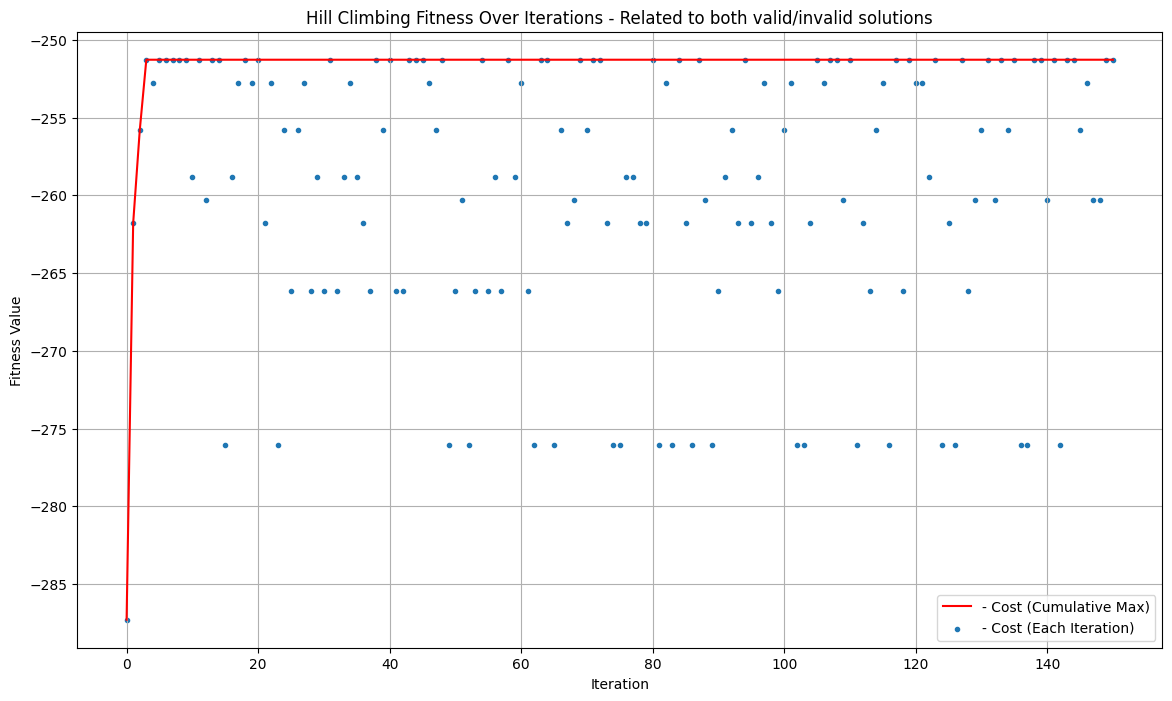

ic| UNIVERSE_SIZE: 1000
    NUM_SETS: 100
    DENSITY: 0.2
    valid(s): np.True_
    cost(s): np.float64(8429.75152130107)
    num_steps: 139


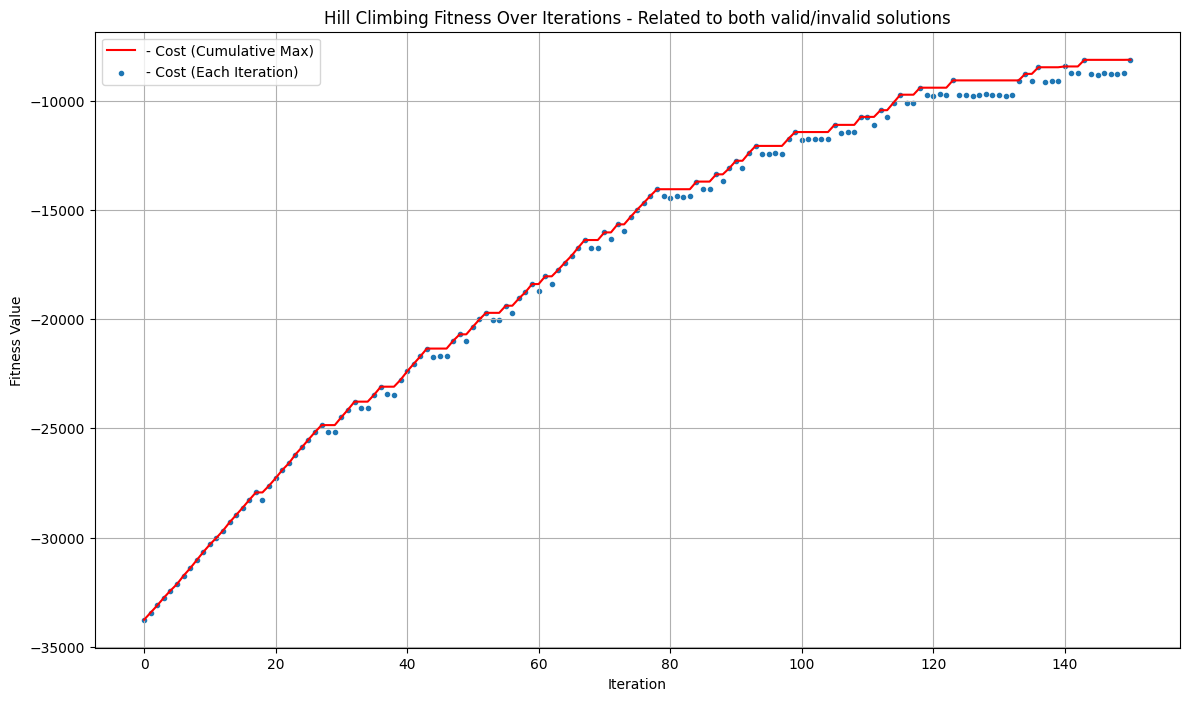

ic| UNIVERSE_SIZE: 10000
    NUM_SETS: 1000
    DENSITY: 0.2
    valid(s): np.True_
    cost(s): np.float64(3670746.1926857354)
    num_steps: 148


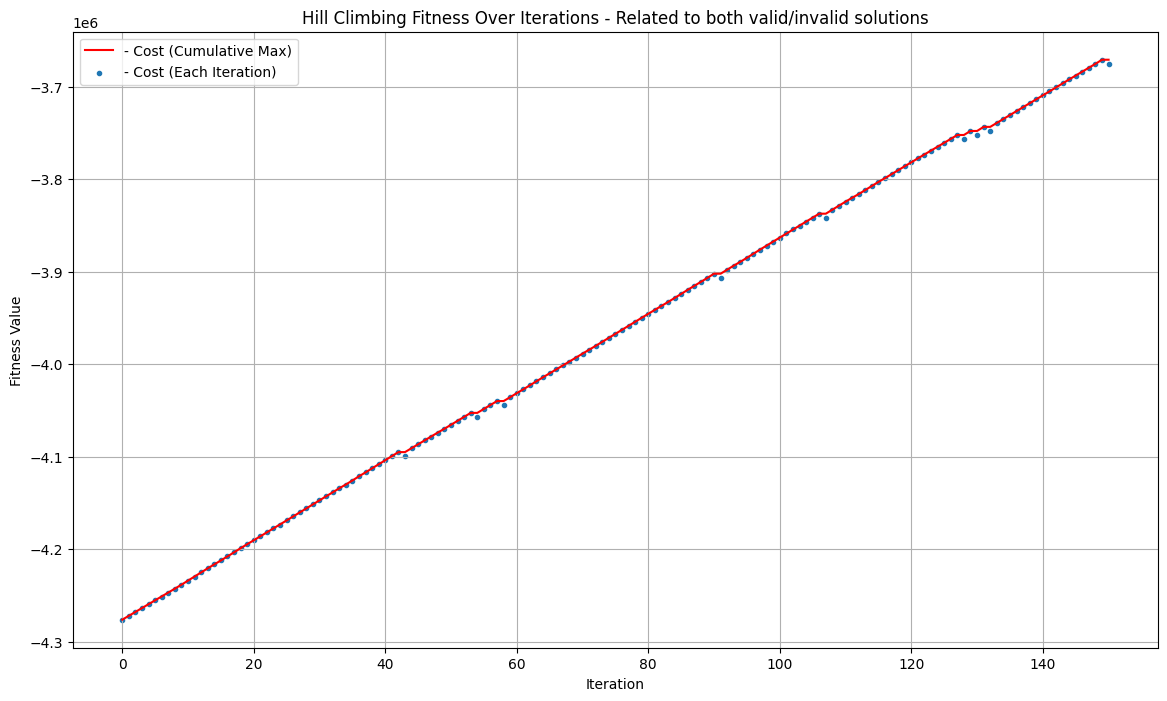

ic| UNIVERSE_SIZE: 100000
    NUM_SETS: 10000
    DENSITY: 0.1
    valid(s): np.True_
    cost(s): np.float64(247489000.899534)
    num_steps: 149


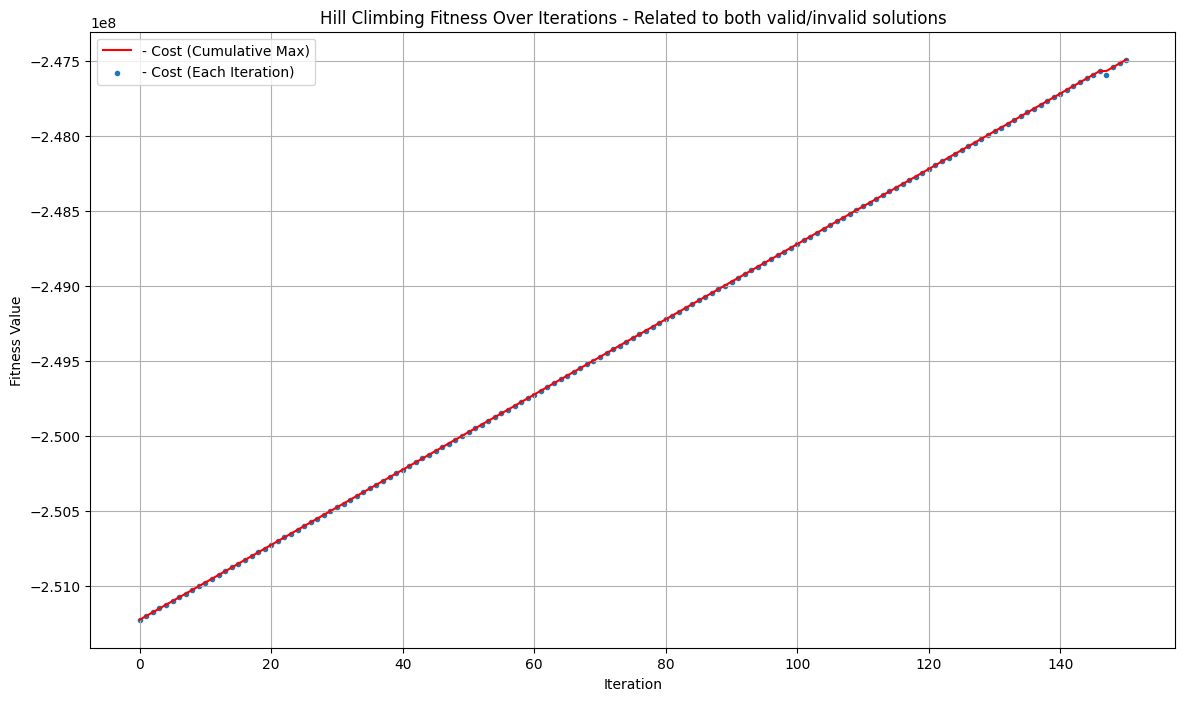

ic| UNIVERSE_SIZE: 100000
    NUM_SETS: 10000
    DENSITY: 0.2
    valid(s): np.True_
    cost(s): np.float64(530353019.0399084)
    num_steps: 149


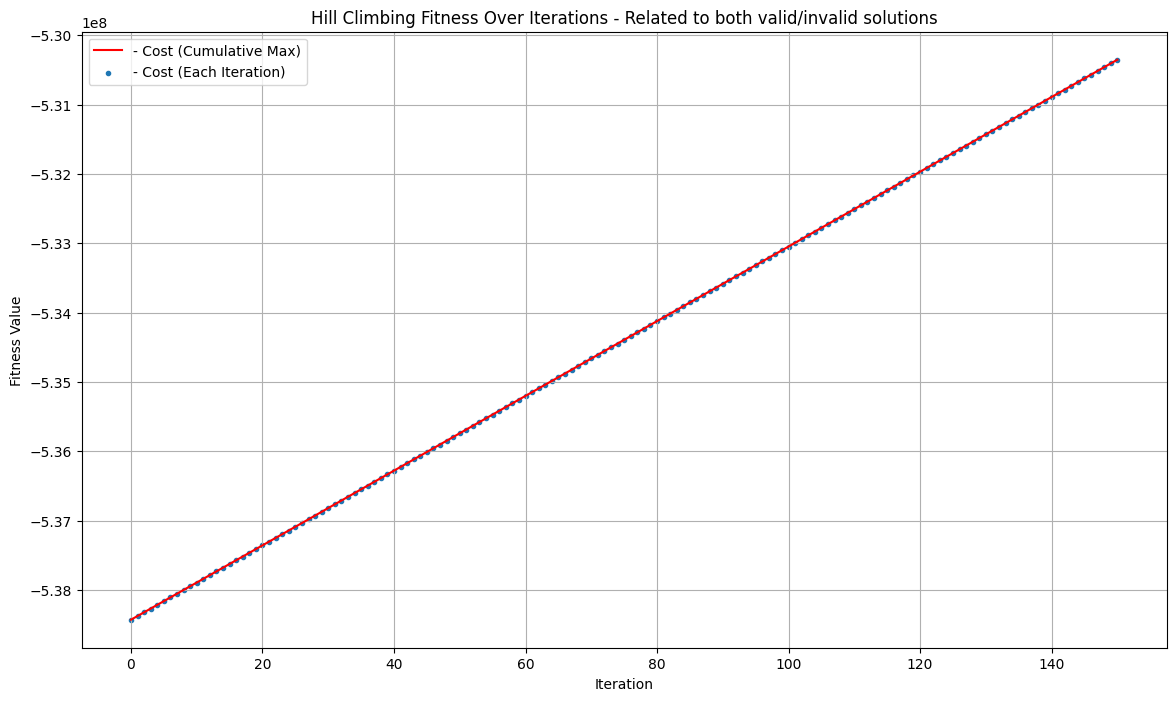

ic| UNIVERSE_SIZE: 100000
    NUM_SETS: 10000
    DENSITY: 0.3
    valid(s): np.True_
    cost(s): np.float64(828575686.5711573)
    num_steps: 148


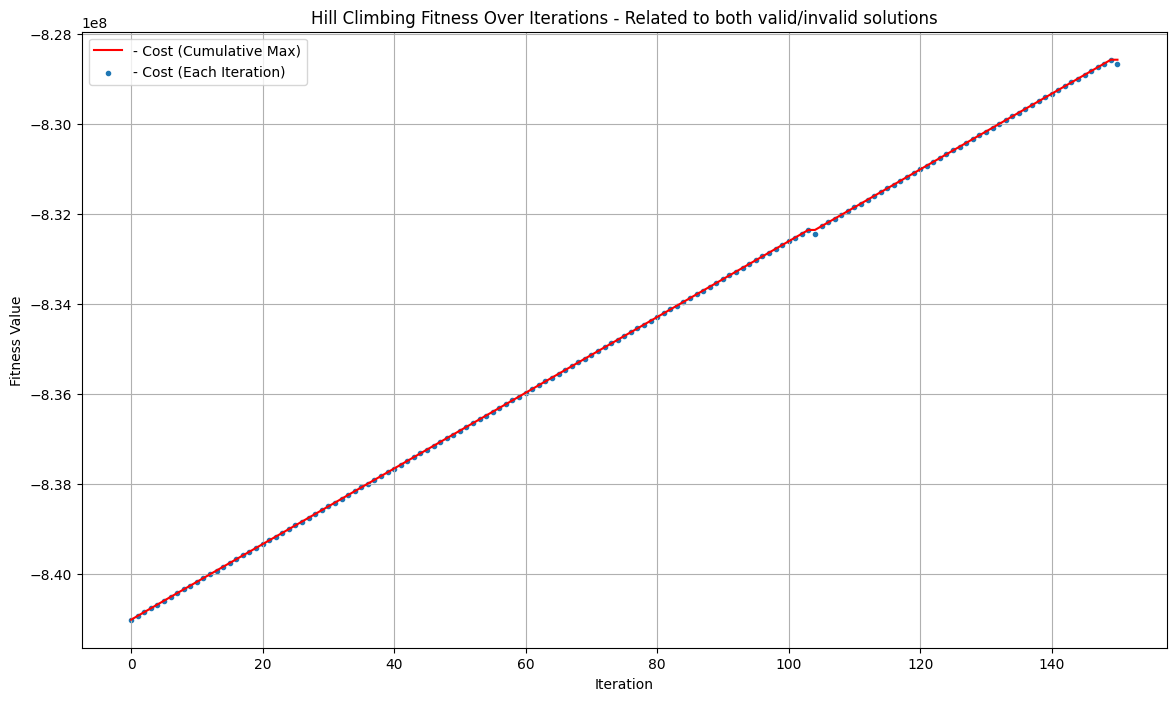

In [44]:
with open(file_path, 'a') as file:
    file.write("\t\t\tHILL CLIMBING - SINGLE RANDOM MUTATION - FIRST FITNESS AND STARTING POINT\n")
    for index in range(num_instances):
        initialize_set_cover_problem(universe_size_instances[index], num_sets_instances[index], density_instances[index])

        s, history, num_steps = hill_climbing(tweak=tweak_1, fitness=fitness_1, starting_point=starting_point_1)
        stats = f"Instance {index + 1}:\n" \
                f"UNIVERSE_SIZE = {UNIVERSE_SIZE}, NUM_SETS = {NUM_SETS}, DENSITY = {DENSITY}\n" \
                f"Valid Solution: {valid(s)}, Cost: {cost(s)}, # steps: {num_steps}\n\n"
        
        ic(UNIVERSE_SIZE, NUM_SETS, DENSITY, valid(s), cost(s), num_steps)
        file.write(stats)

        #first criterion: validity, second criterion: -cost
        fitness_values = [second_fitness_criterion for first_fitness_criterion, second_fitness_criterion in history]
        fitness_plot(fitness_values, "- Cost (Cumulative Max)", "- Cost (Each Iteration)")
    file.write("\n\n")

#### Single random mutation with second fitness and starting point

ic| UNIVERSE_SIZE: 100
    NUM_SETS: 10
    DENSITY: 0.2
    valid(s): np.True_
    cost(s): np.float64(268.95856715572165)
    num_steps: 24


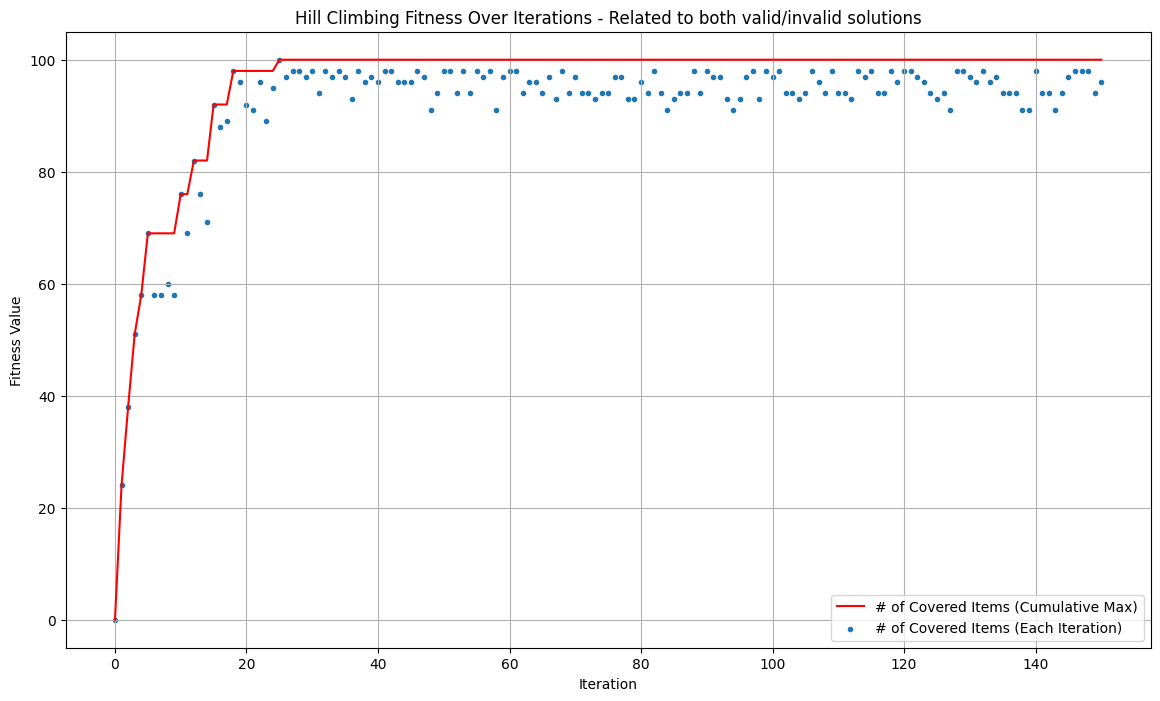

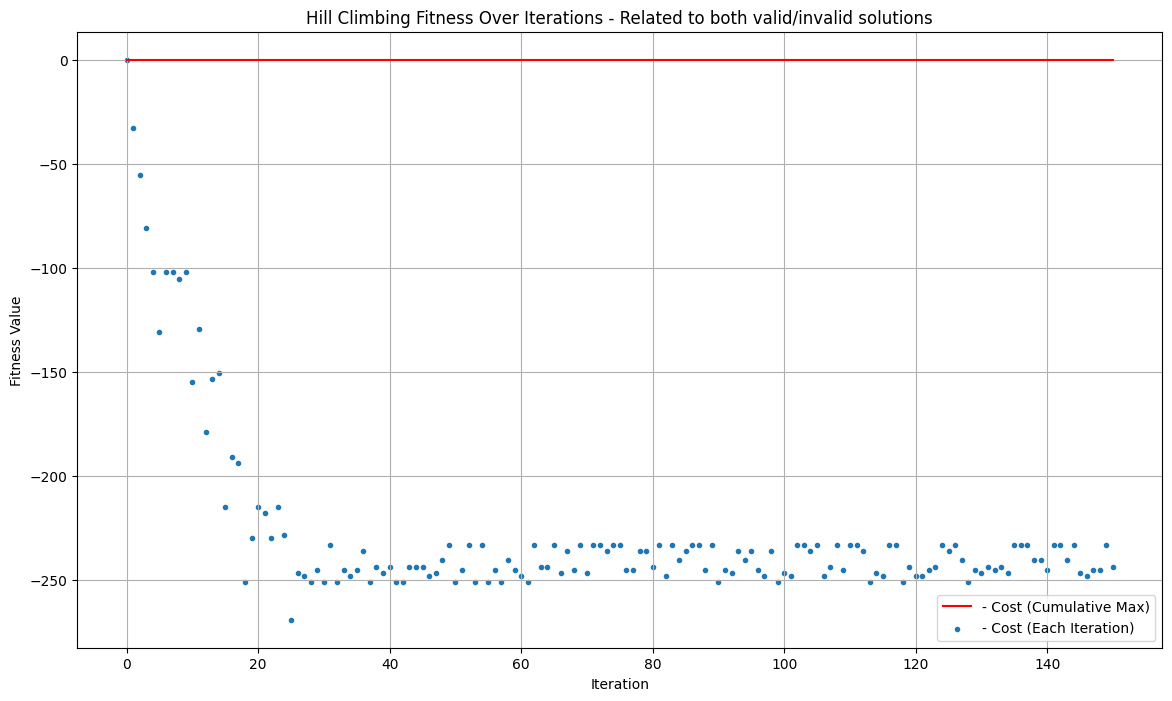

ic| UNIVERSE_SIZE: 1000
    NUM_SETS: 100
    DENSITY: 0.2
    valid(s): np.True_
    cost(s): np.float64(7126.424345513932)
    num_steps: 131


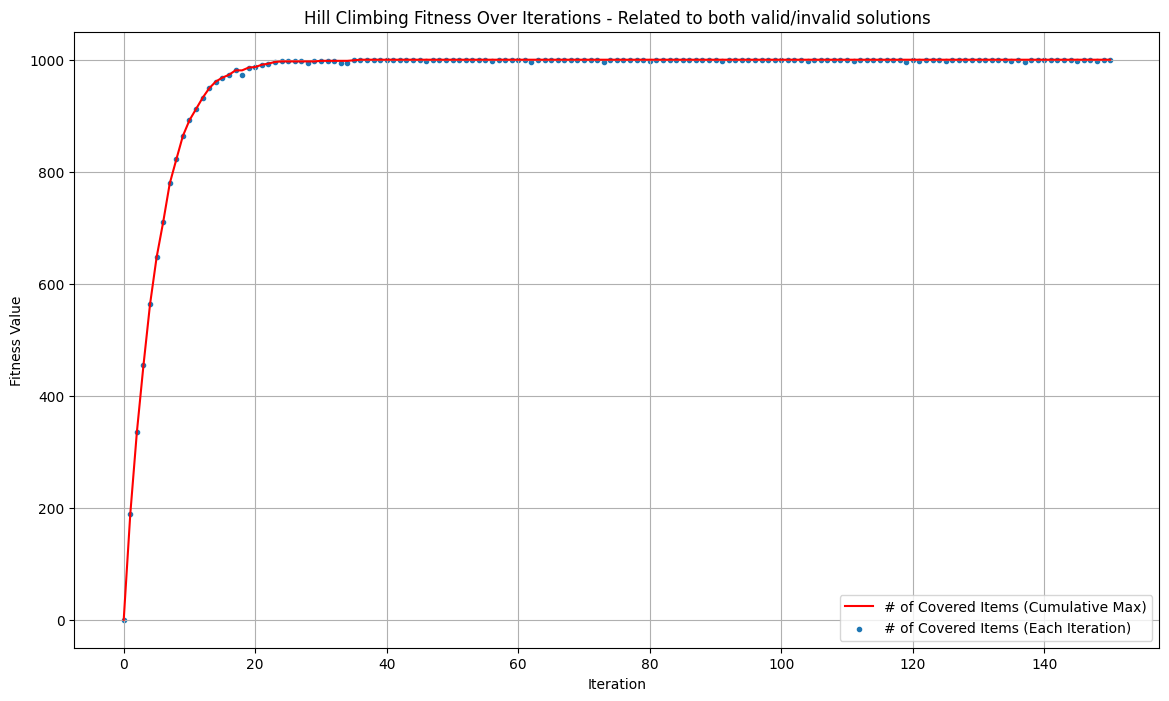

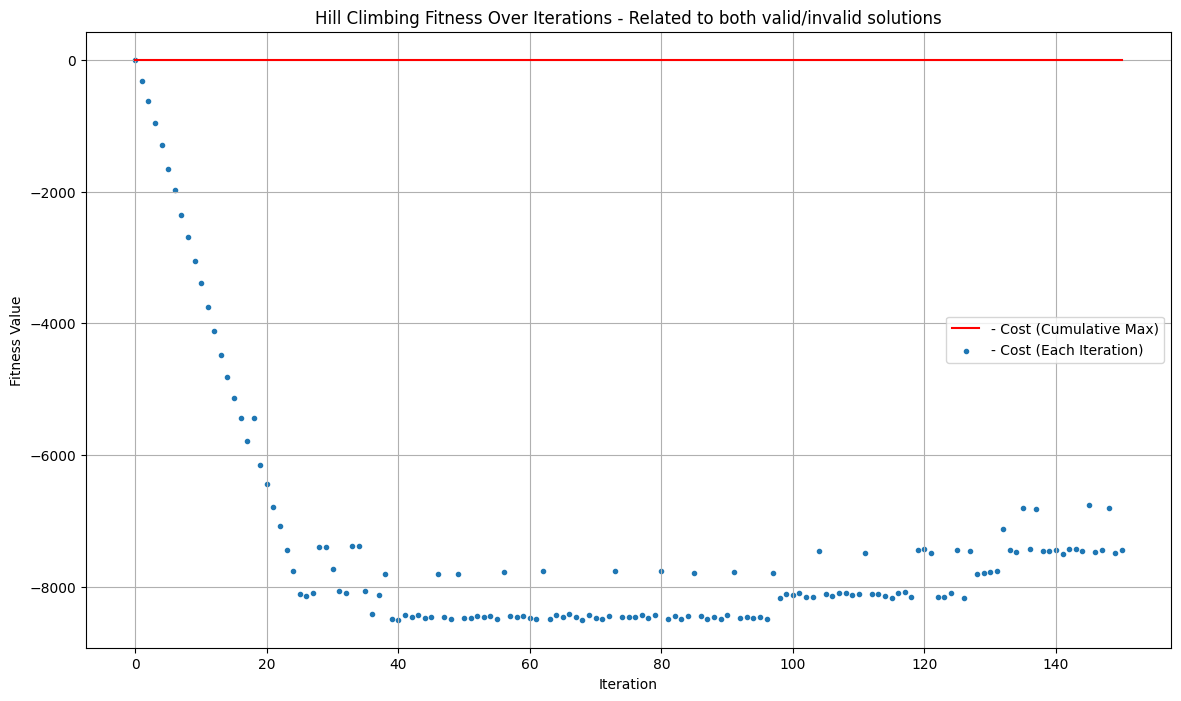

ic| UNIVERSE_SIZE: 10000
    NUM_SETS: 1000
    DENSITY: 0.2
    valid(s): np.True_
    cost(s): np.float64(157637.52961978395)
    num_steps: 57


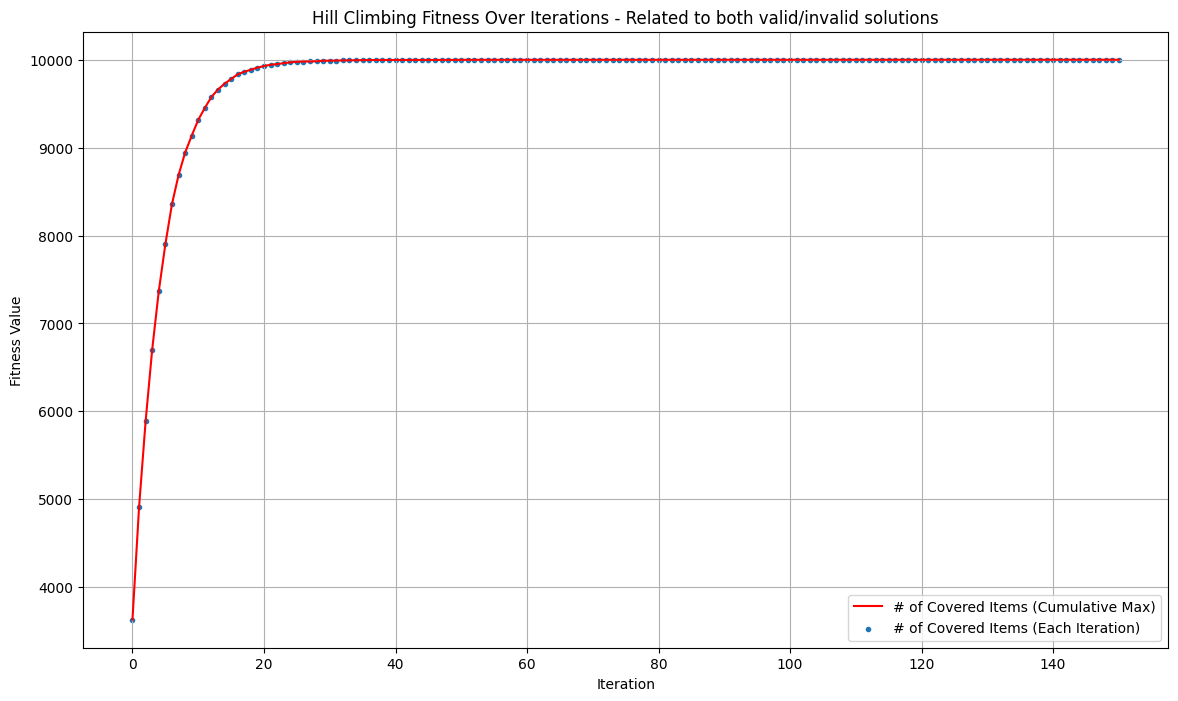

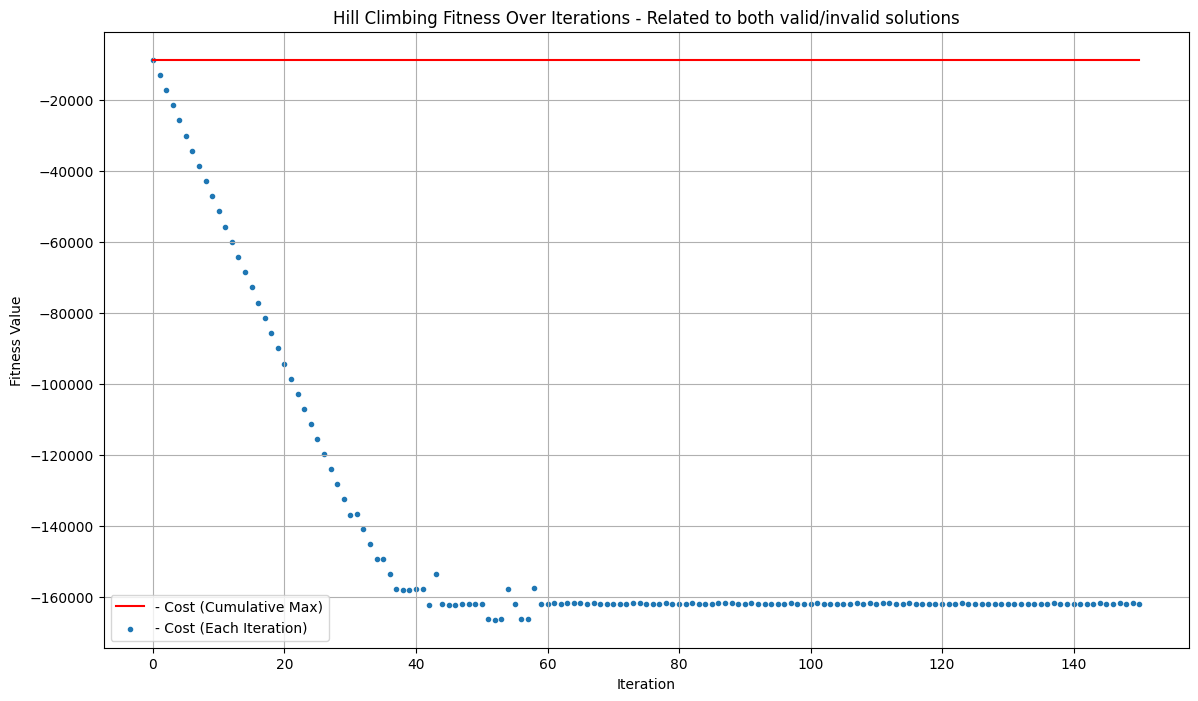

ic| UNIVERSE_SIZE: 100000
    NUM_SETS: 10000
    DENSITY: 0.1
    valid(s): np.True_
    cost(s): np.float64(2385827.3472725283)
    num_steps: 120


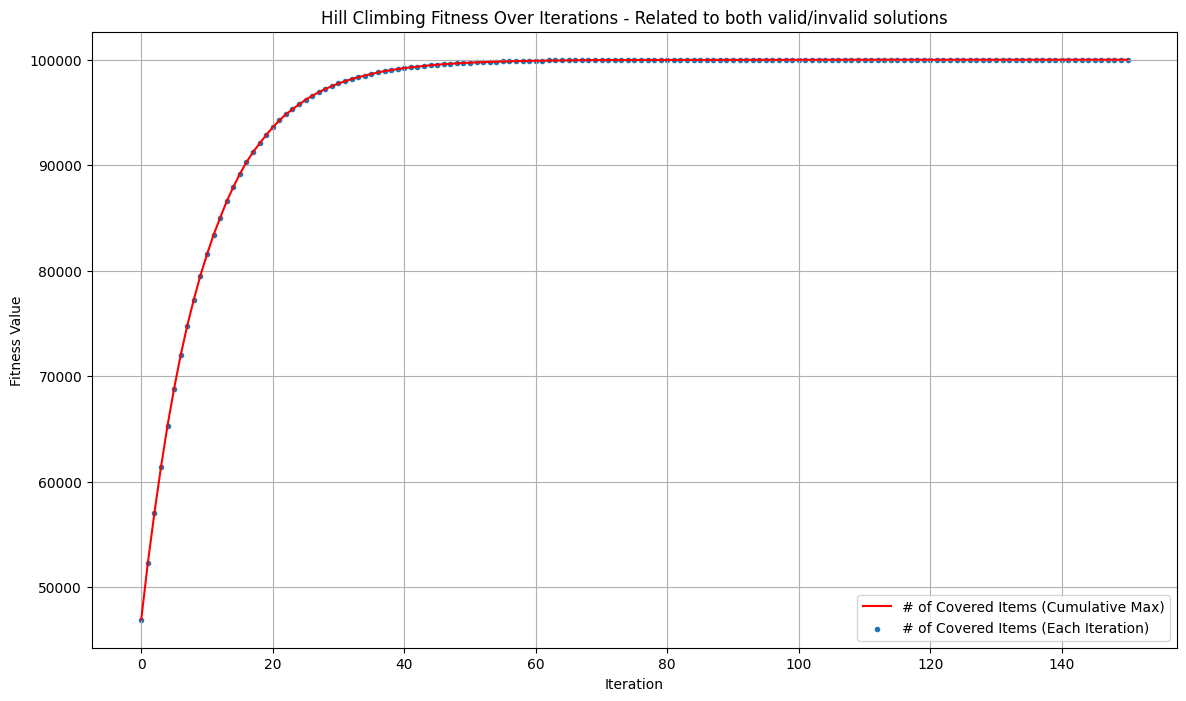

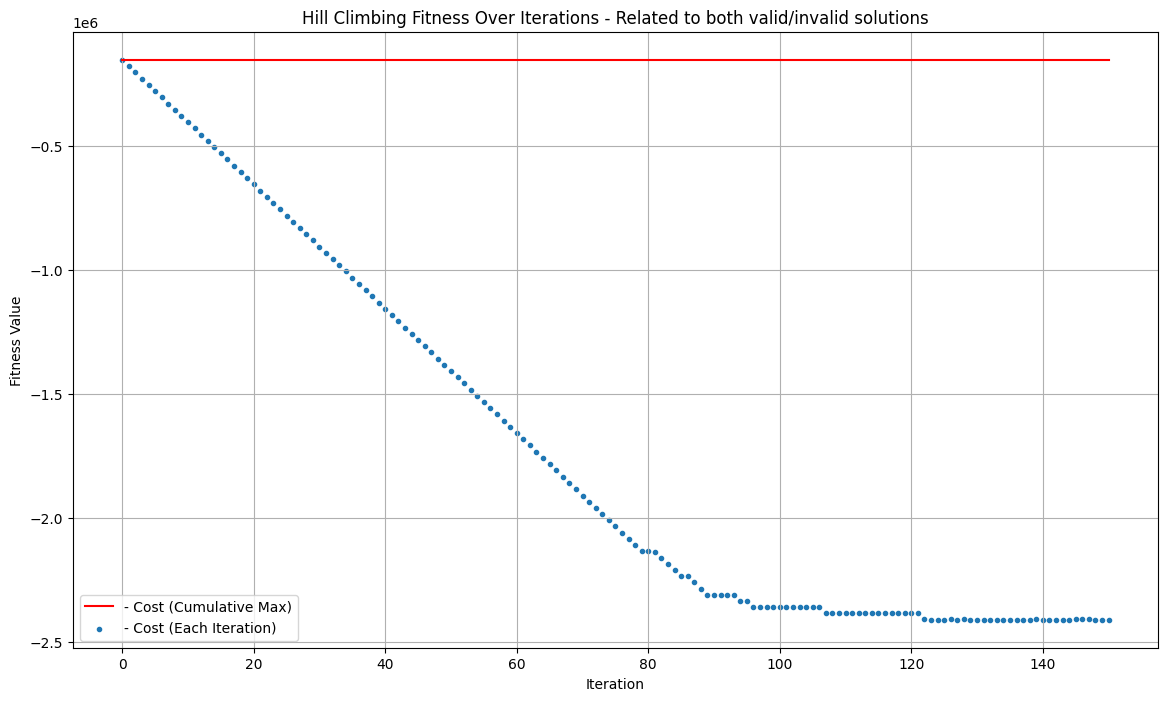

ic| UNIVERSE_SIZE: 100000
    NUM_SETS: 10000
    DENSITY: 0.2
    valid(s): np.True_
    cost(s): np.float64(2531749.5720853196)
    num_steps: 41


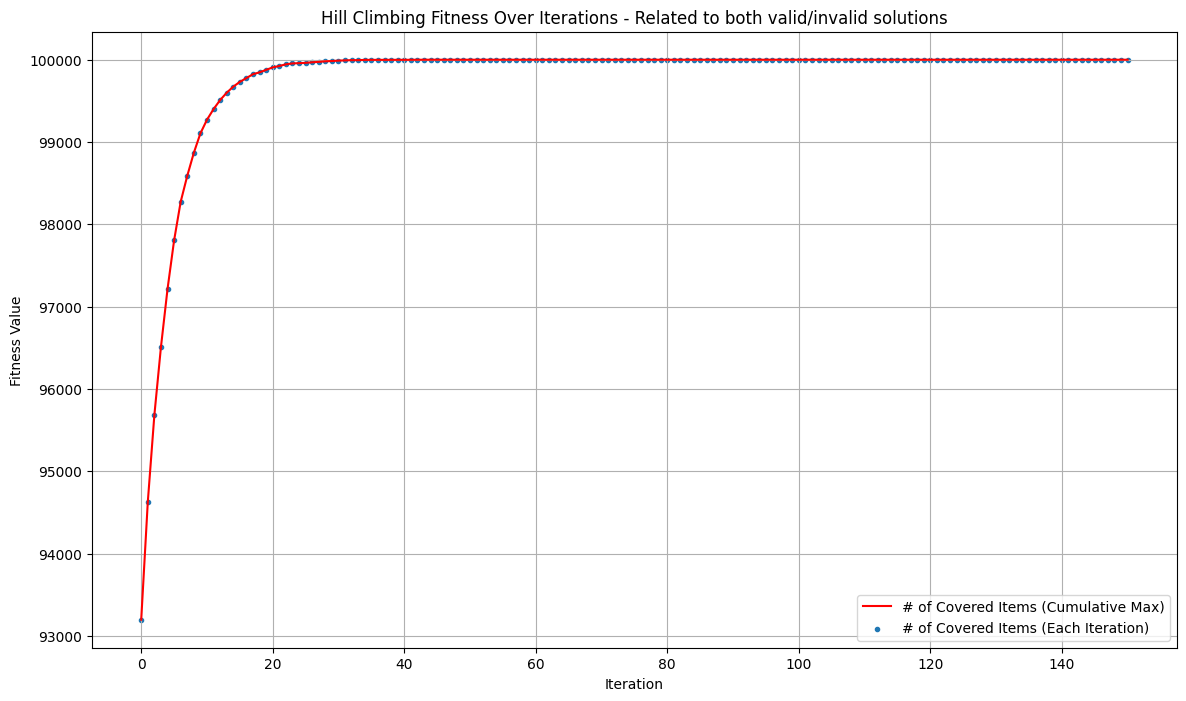

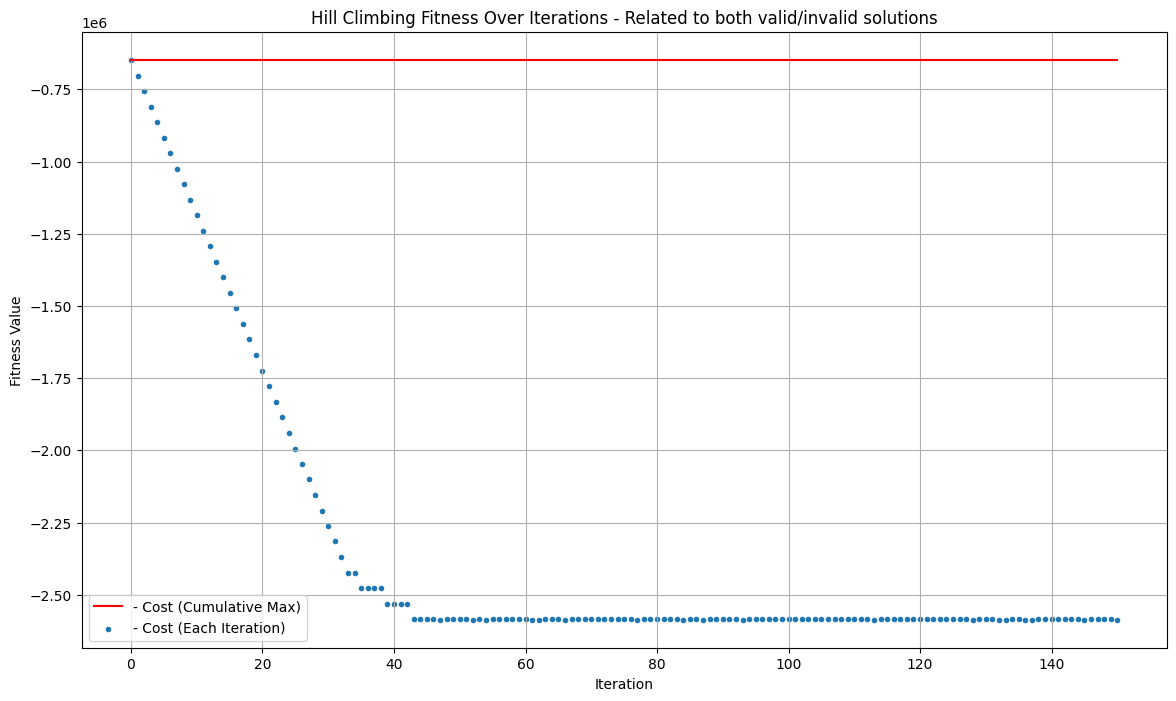

ic| UNIVERSE_SIZE: 100000
    NUM_SETS: 10000
    DENSITY: 0.3
    valid(s): np.True_
    cost(s): np.float64(2437888.891993546)
    num_steps: 11


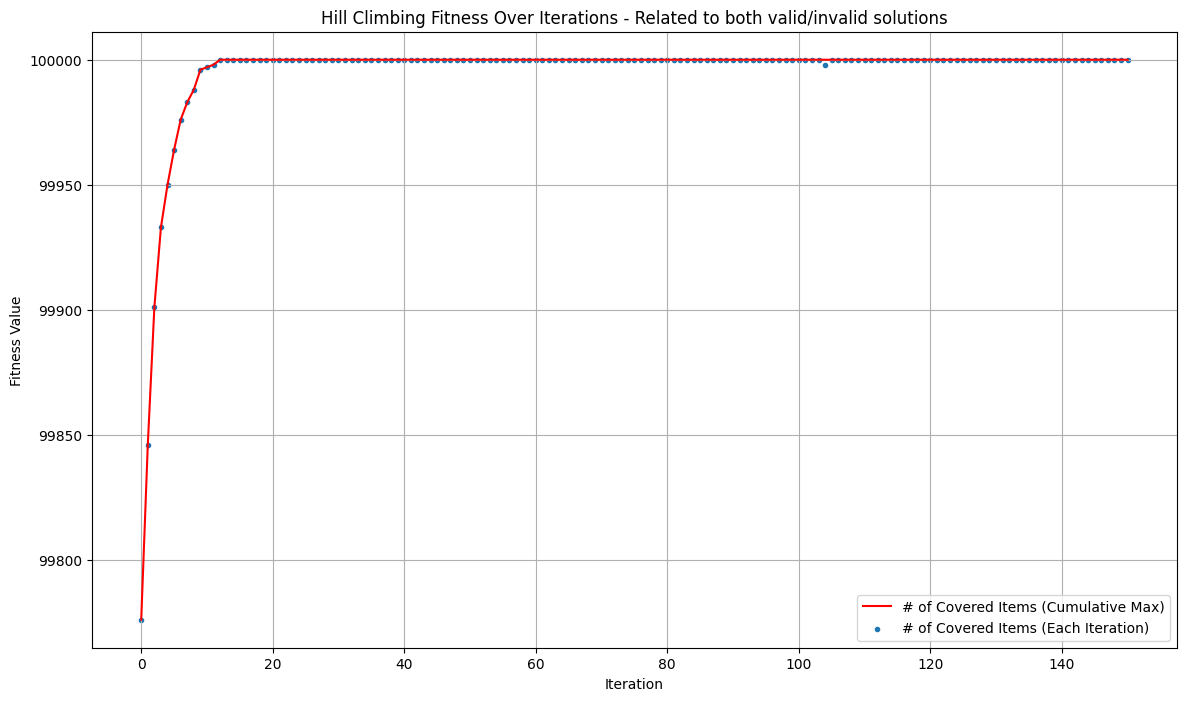

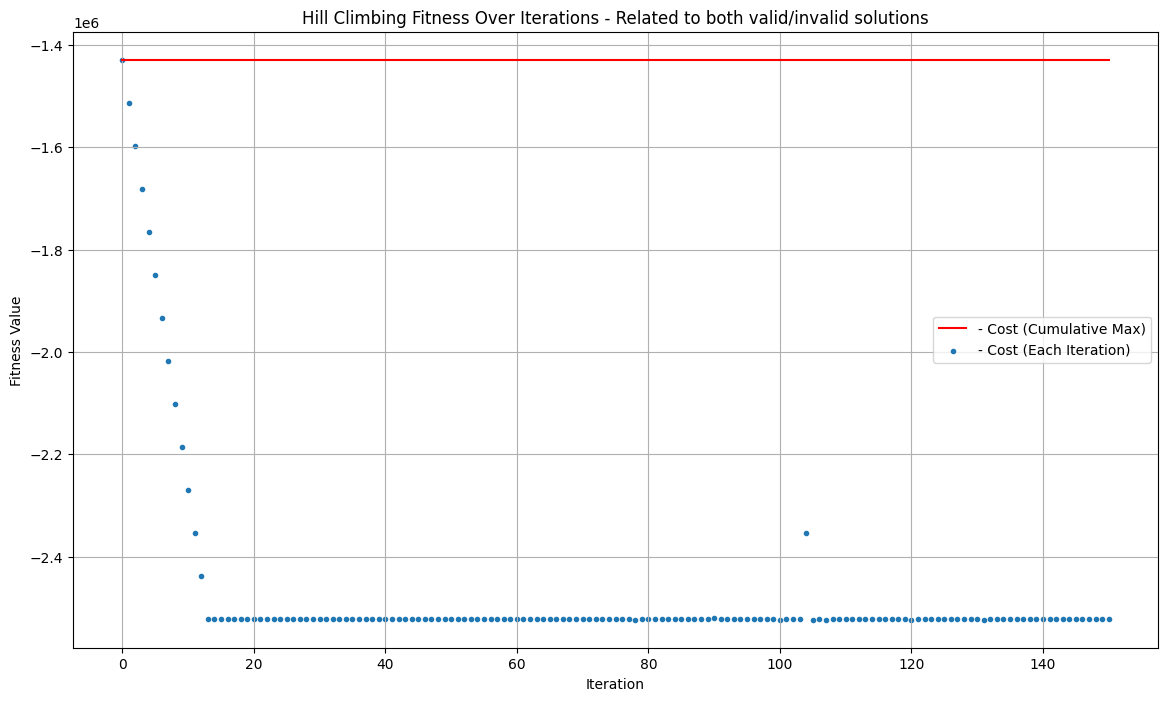

In [45]:
with open(file_path, 'a') as file:
    file.write("\t\t\tHILL CLIMBING - SINGLE RANDOM MUTATION - SECOND FITNESS AND STARTING POINT\n")
    for index in range(num_instances):
        initialize_set_cover_problem(universe_size_instances[index], num_sets_instances[index], density_instances[index])

        s, history, num_steps = hill_climbing(tweak=tweak_1, fitness=fitness_2, starting_point=starting_point_2)
        
        stats = f"Instance {index + 1}:\n" \
                f"UNIVERSE_SIZE = {UNIVERSE_SIZE}, NUM_SETS = {NUM_SETS}, DENSITY = {DENSITY}\n" \
                f"Valid Solution: {valid(s)}, Cost: {cost(s)}, # steps: {num_steps}\n\n"
        
        ic(UNIVERSE_SIZE, NUM_SETS, DENSITY, valid(s), cost(s), num_steps)
        file.write(stats)

        #first criterion: # of covered items, second criterion: -cost
        fitness_values = [first_fitness_criterion for first_fitness_criterion, second_fitness_criterion in history]
        fitness_plot(fitness_values, "# of Covered Items (Cumulative Max)", "# of Covered Items (Each Iteration)")

        #first criterion: validity, second criterion: -cost
        fitness_values = [second_fitness_criterion for first_fitness_criterion, second_fitness_criterion in history]
        fitness_plot(fitness_values, "- Cost (Cumulative Max)", "- Cost (Each Iteration)")
    file.write("\n\n")


### Hill Climbing - Multiple random mutations

#### Multiple random mutations with first fitness and starting point

ic| UNIVERSE_SIZE: 100
    NUM_SETS: 10
    DENSITY: 0.2
    valid(s): np.True_
    cost(s): np.float64(271.701939124068)
    num_steps: 0


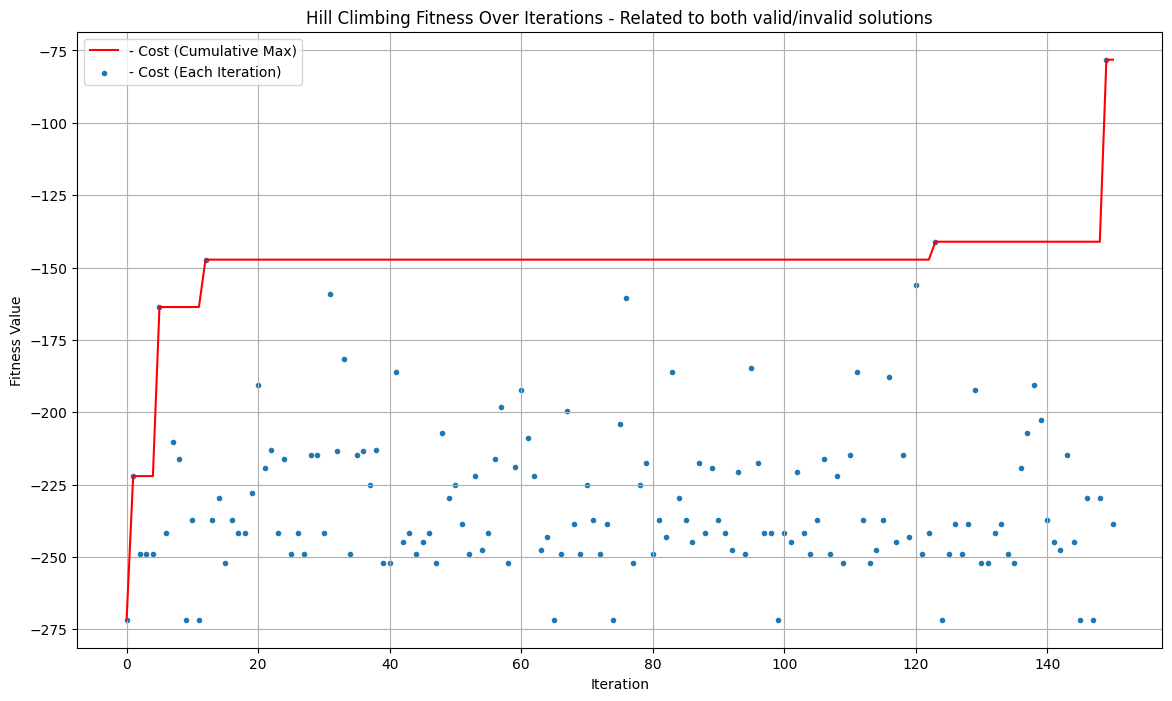

ic| UNIVERSE_SIZE: 1000
    NUM_SETS: 100
    DENSITY: 0.2
    valid(s): np.True_
    cost(s): np.float64(8589.954516251404)
    num_steps: 143


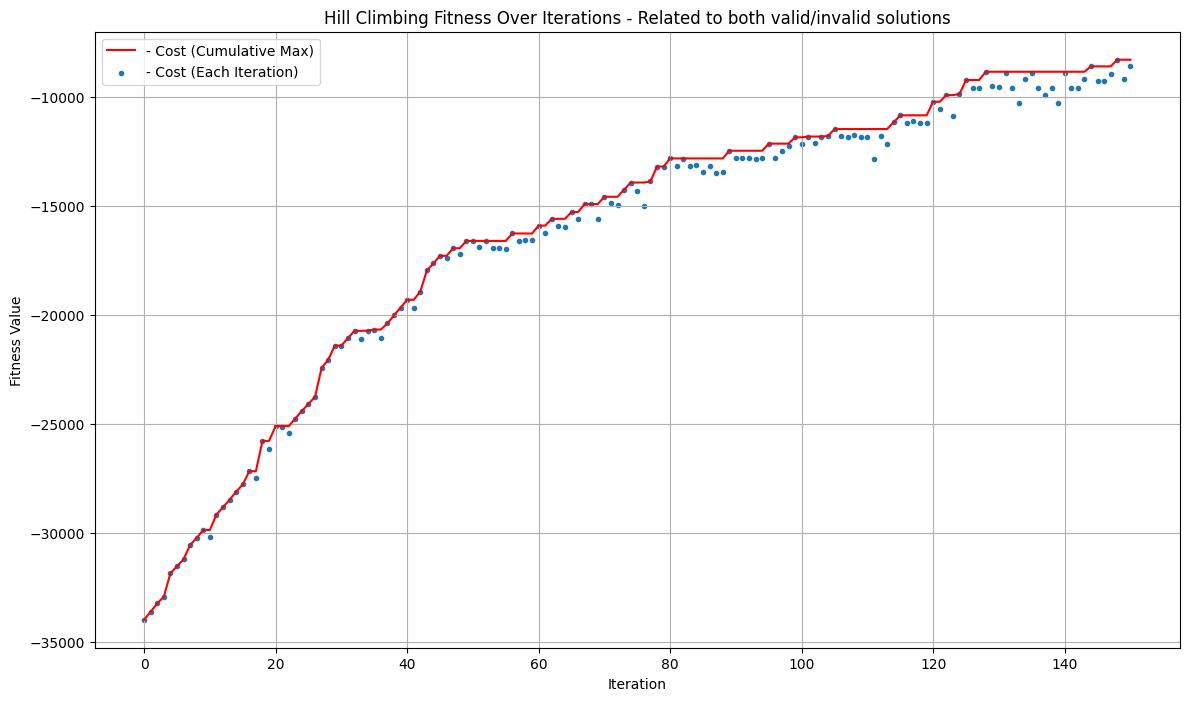

ic| UNIVERSE_SIZE: 10000
    NUM_SETS: 1000
    DENSITY: 0.2
    valid(s): np.True_
    cost(s): np.float64(3382647.085965343)
    num_steps: 149


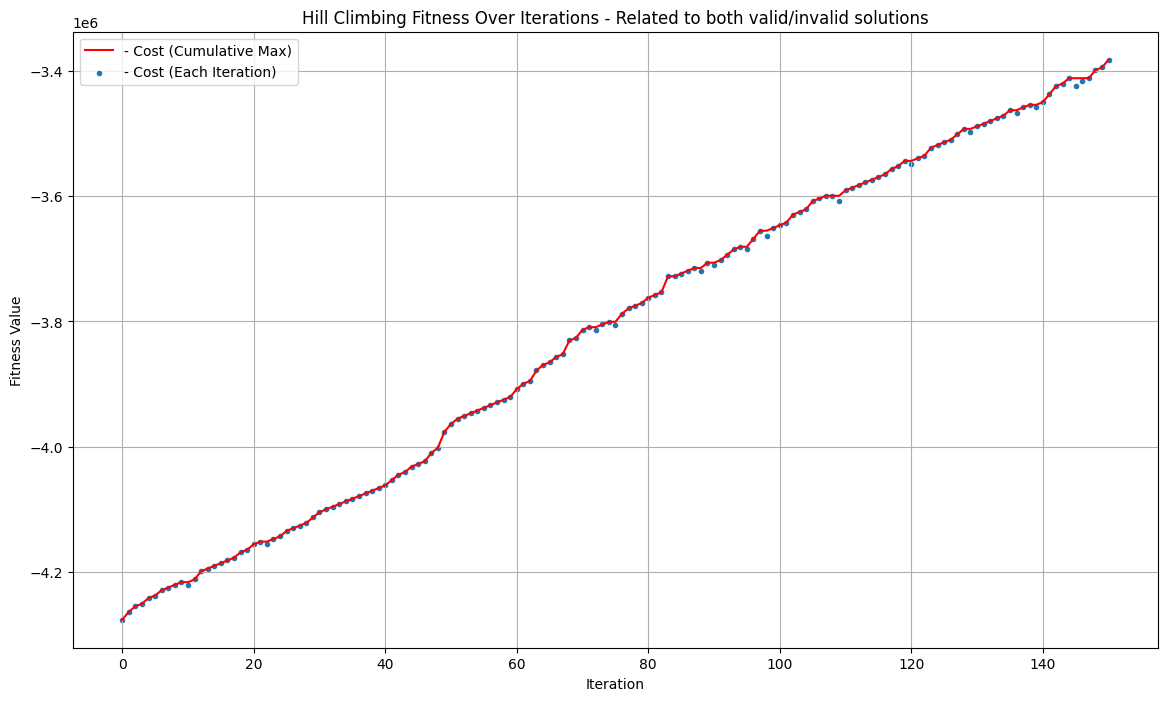

ic| UNIVERSE_SIZE: 100000
    NUM_SETS: 10000
    DENSITY: 0.1
    valid(s): np.True_
    cost(s): np.float64(244690773.56320685)
    num_steps: 149


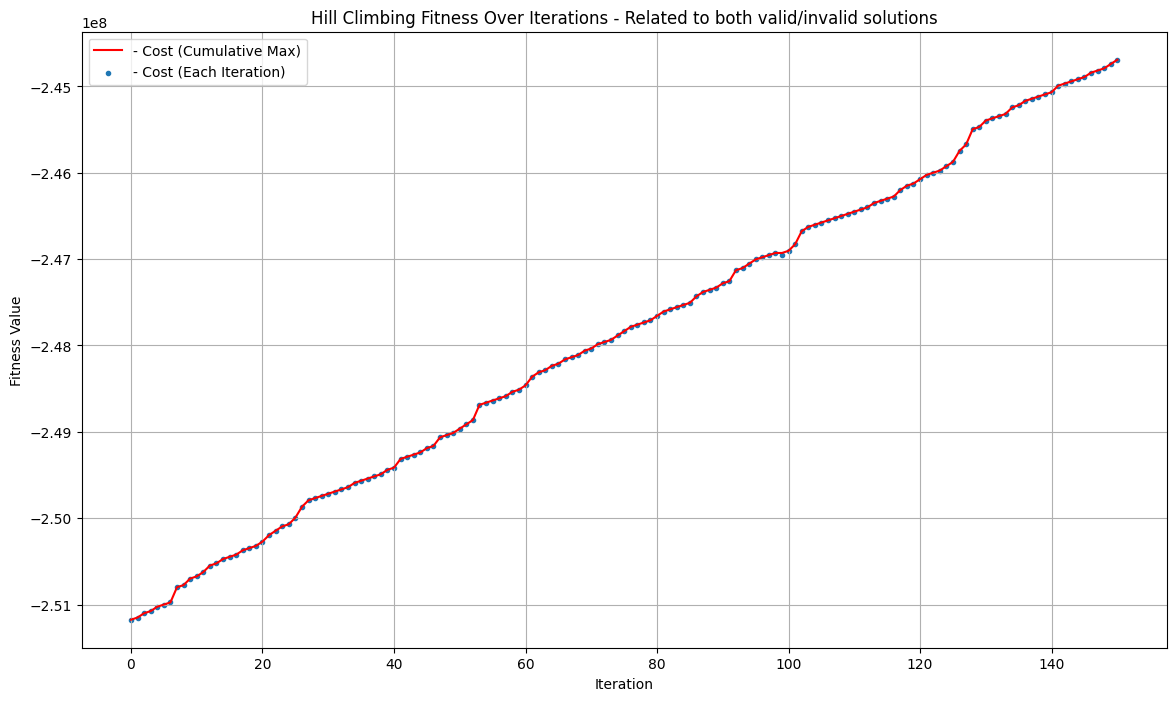

ic| UNIVERSE_SIZE: 100000
    NUM_SETS: 10000
    DENSITY: 0.2
    valid(s): np.True_
    cost(s): np.float64(525090013.89446354)
    num_steps: 149


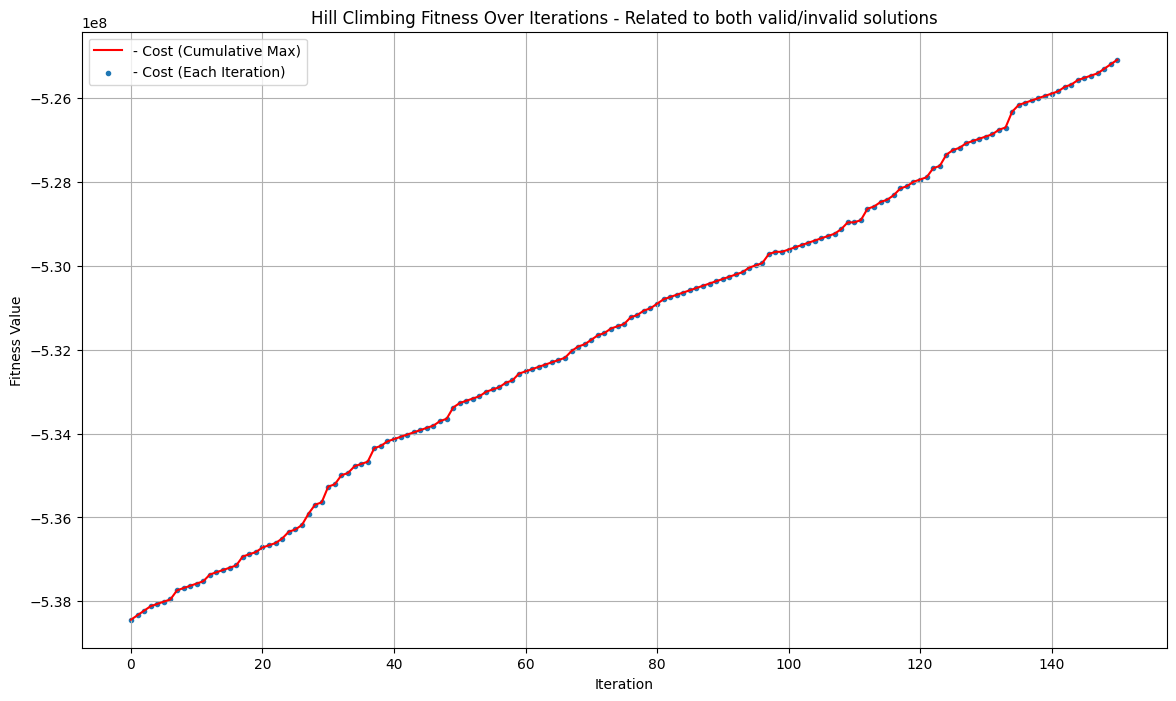

ic| UNIVERSE_SIZE: 100000
    NUM_SETS: 10000
    DENSITY: 0.3
    valid(s): np.True_
    cost(s): np.float64(819868808.814537)
    num_steps: 148


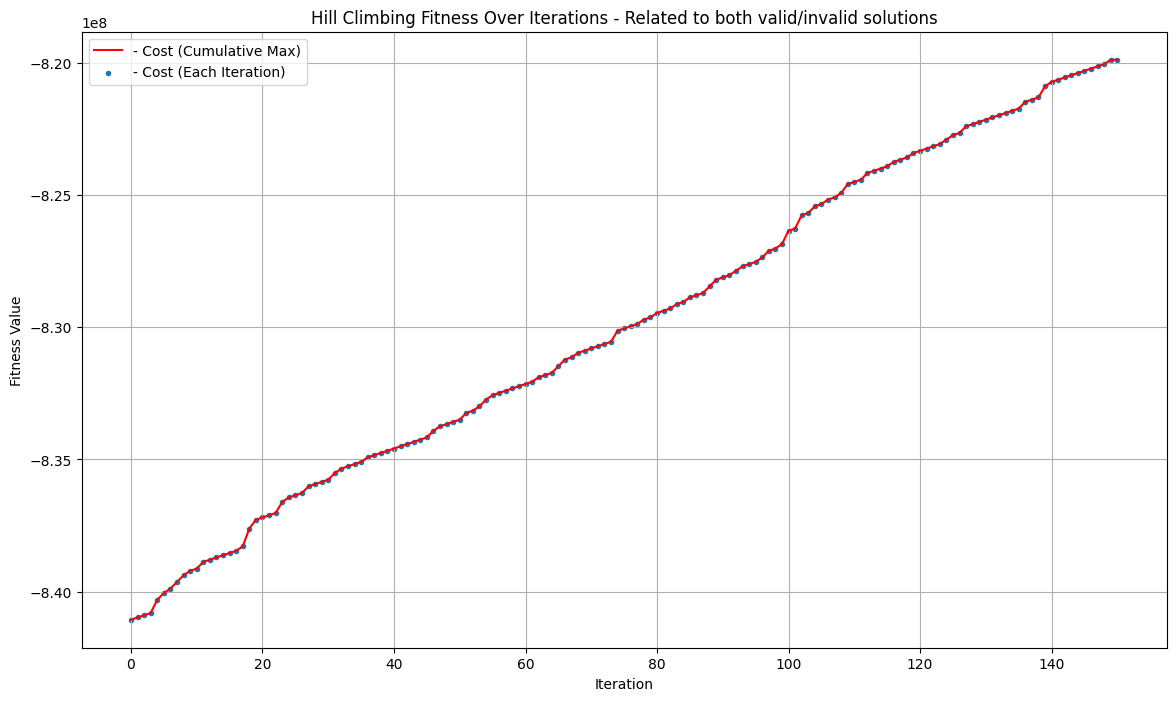

In [46]:
with open(file_path, 'a') as file:
    file.write("\t\t\tHILL CLIMBING - MULTIPLE RANDOM MUTATIONS - FIRST FITNESS AND STARTING POINT\n")    
    for index in range(num_instances):
        initialize_set_cover_problem(universe_size_instances[index], num_sets_instances[index], density_instances[index])

        s, history, num_steps = hill_climbing(tweak_2, fitness_1, starting_point_1)
        stats = f"Instance {index + 1}:\n" \
                f"UNIVERSE_SIZE = {UNIVERSE_SIZE}, NUM_SETS = {NUM_SETS}, DENSITY = {DENSITY}\n" \
                f"Valid Solution: {valid(s)}, Cost: {cost(s)}, # steps: {num_steps}\n\n"
        
        ic(UNIVERSE_SIZE, NUM_SETS, DENSITY, valid(s), cost(s), num_steps)
        file.write(stats)

        #first criterion: validity, second criterion: -cost
        fitness_values = [second_fitness_criterion for first_fitness_criterion, second_fitness_criterion in history]
        fitness_plot(fitness_values, "- Cost (Cumulative Max)", "- Cost (Each Iteration)")
    file.write("\n\n")

#### Multiple random mutations with second fitness and starting point

ic| UNIVERSE_SIZE: 100
    NUM_SETS: 10
    DENSITY: 0.2
    valid(s): np.True_
    cost(s): np.float64(295.53723878302964)
    num_steps: 23


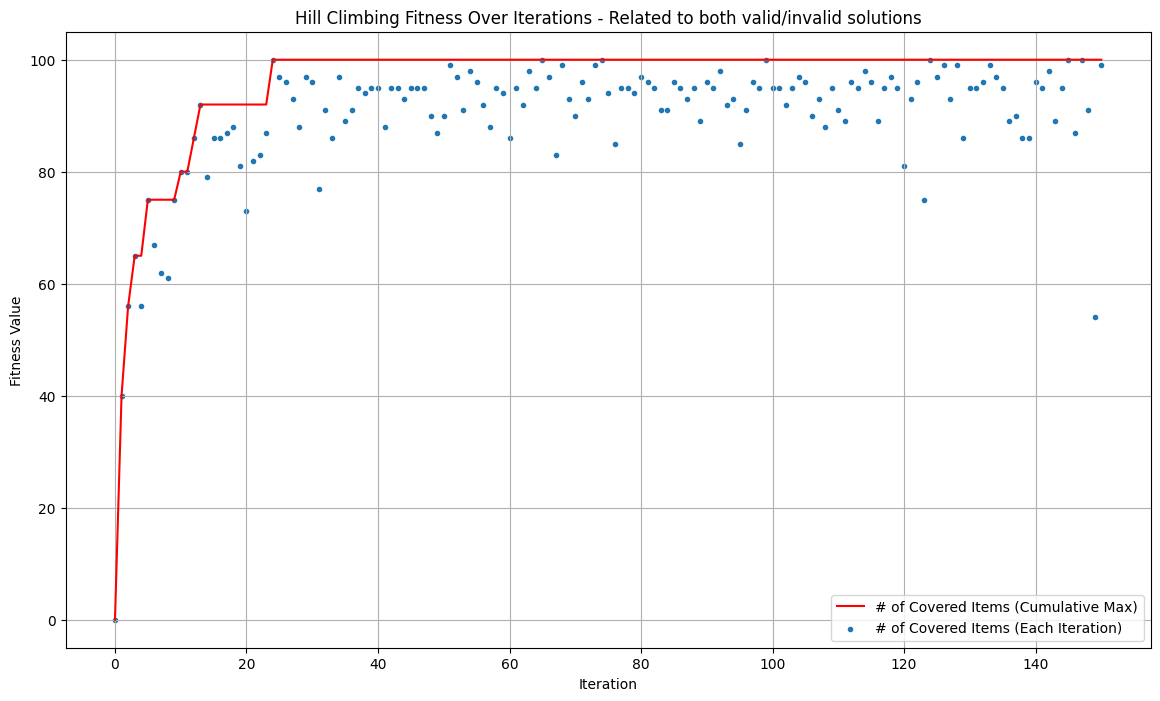

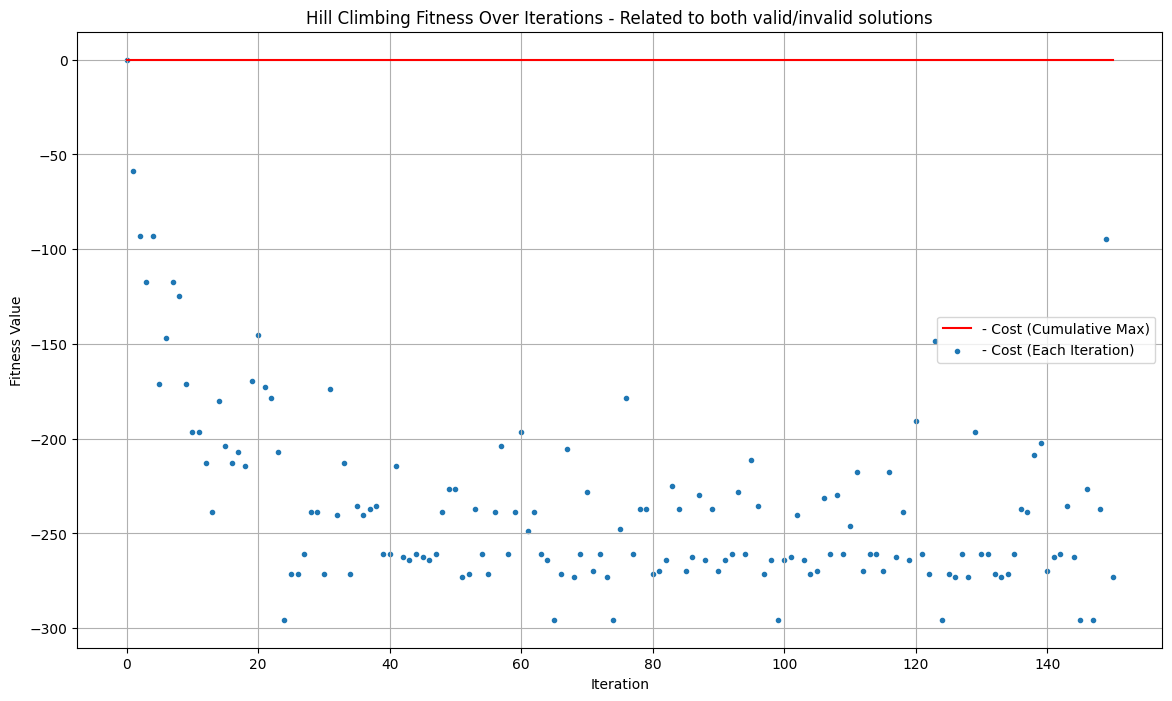

ic| UNIVERSE_SIZE: 1000
    NUM_SETS: 100
    DENSITY: 0.2
    valid(s): np.True_
    cost(s): np.float64(8070.6854250965725)
    num_steps: 108


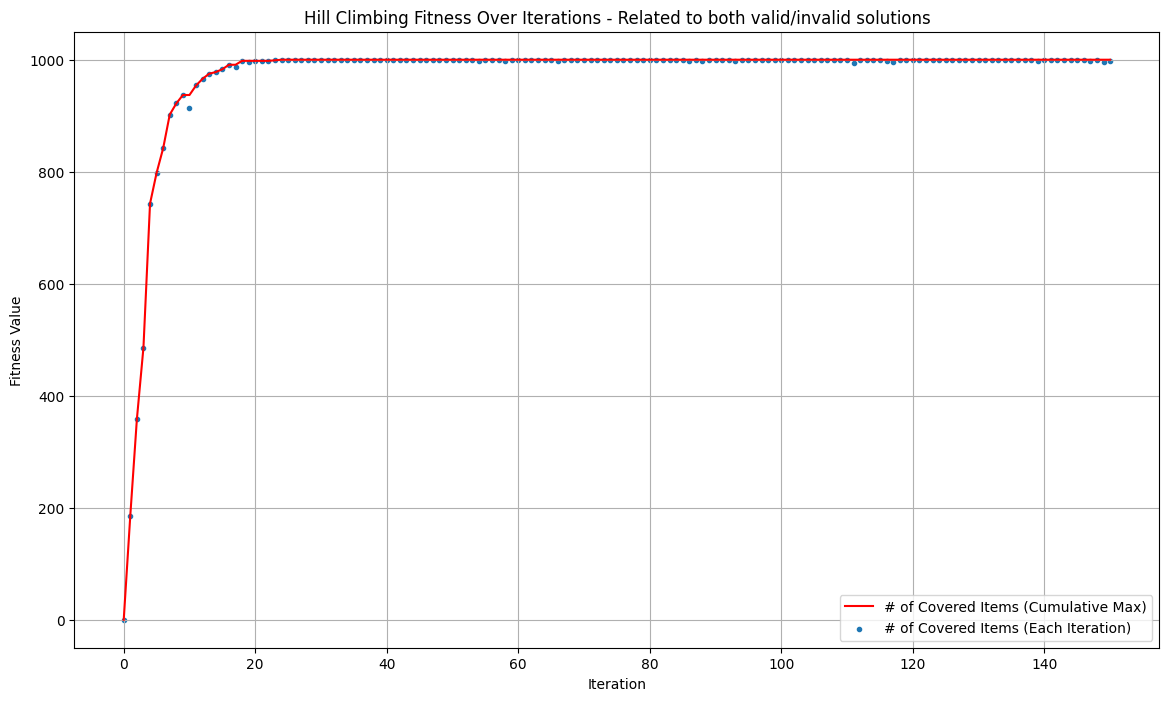

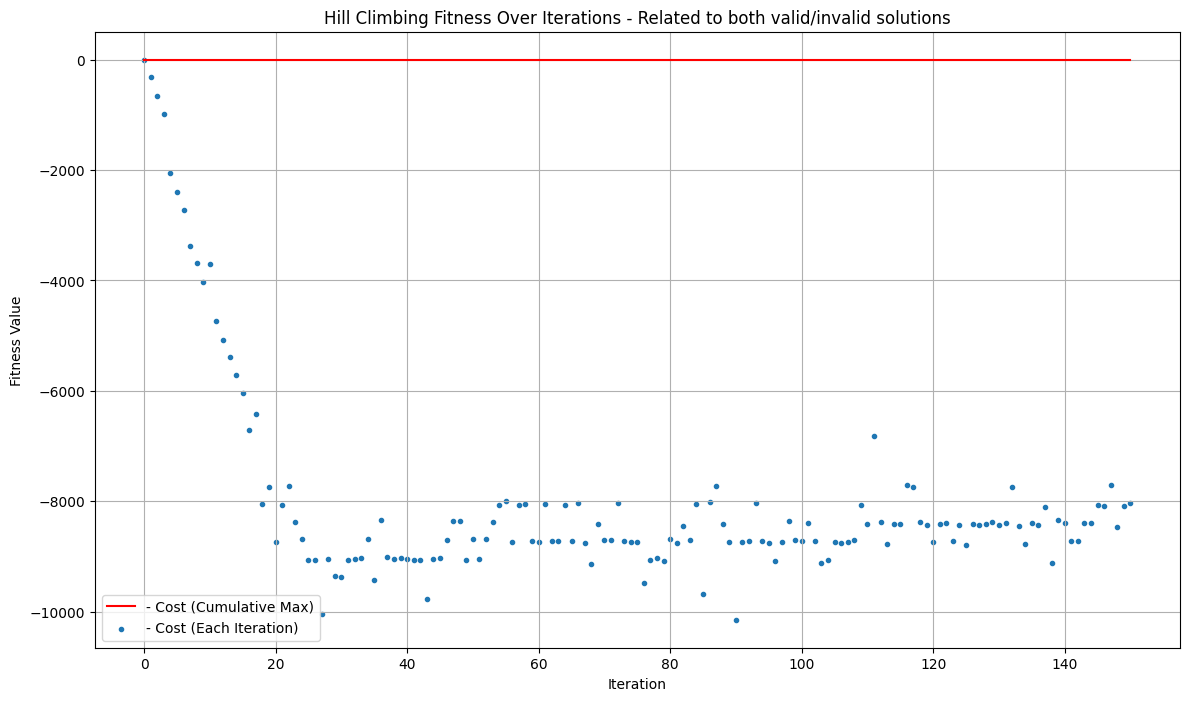

ic| UNIVERSE_SIZE: 10000
    NUM_SETS: 1000
    DENSITY: 0.2
    valid(s): np.True_
    cost(s): np.float64(144952.5463135609)
    num_steps: 128


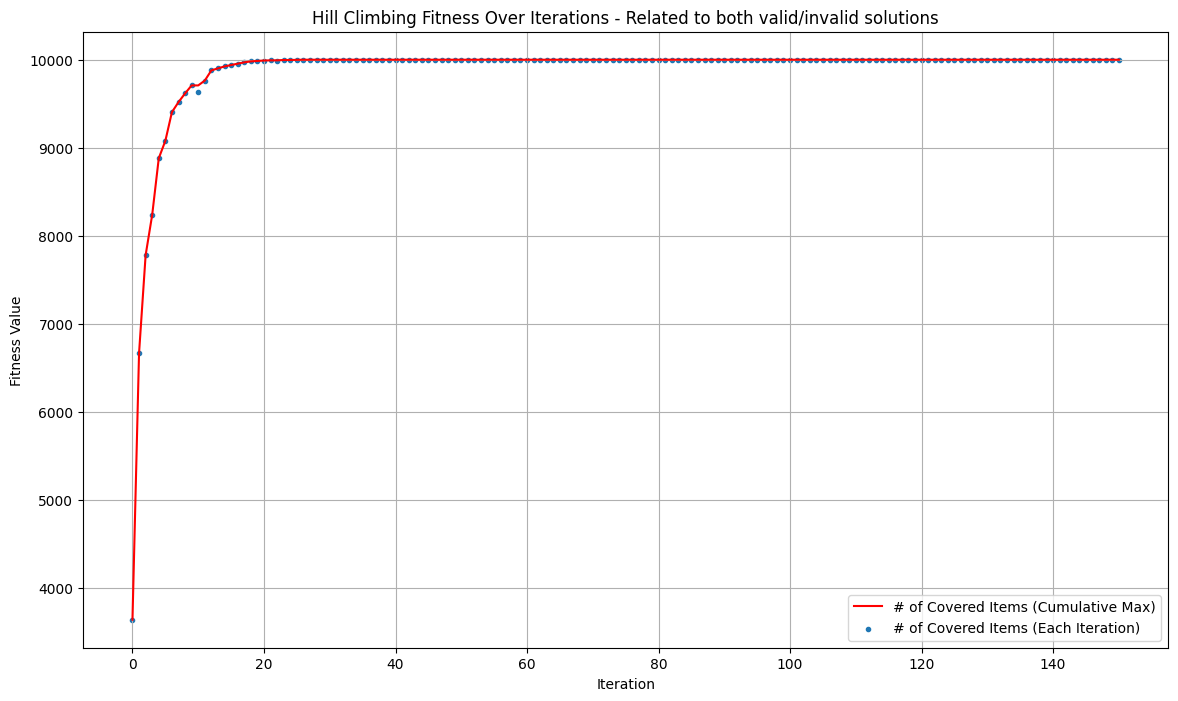

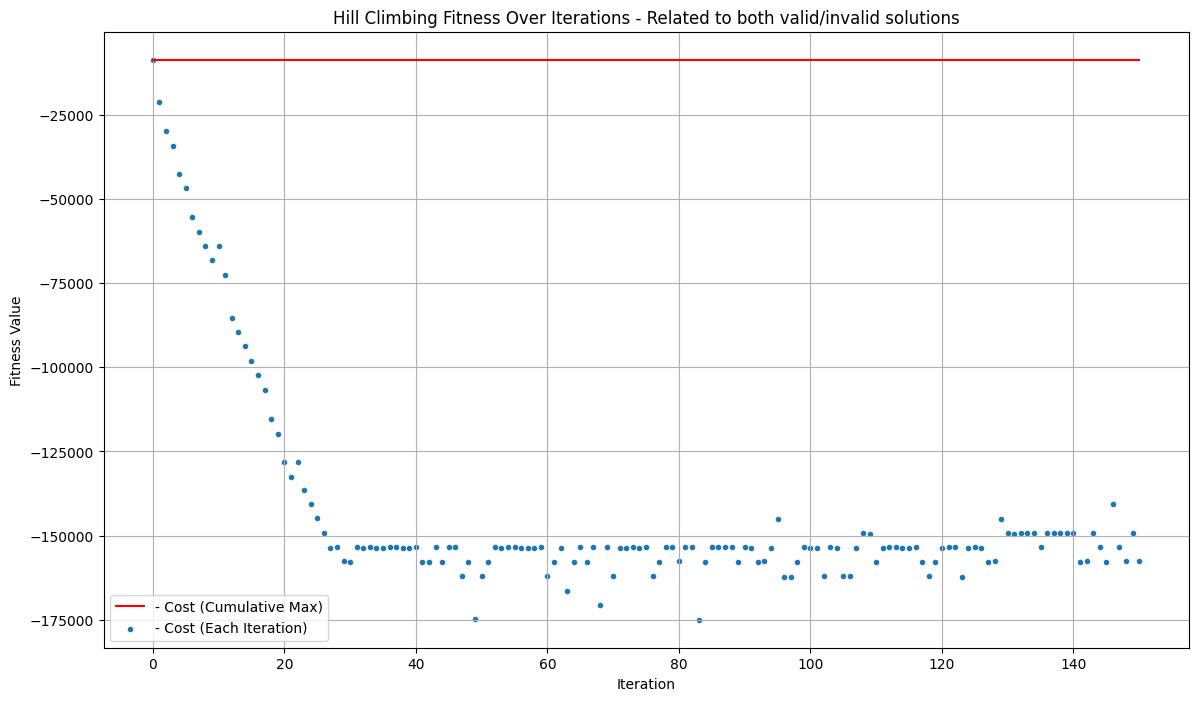

ic| UNIVERSE_SIZE: 100000
    NUM_SETS: 10000
    DENSITY: 0.1
    valid(s): np.True_
    cost(s): np.float64(2615600.70747767)
    num_steps: 54


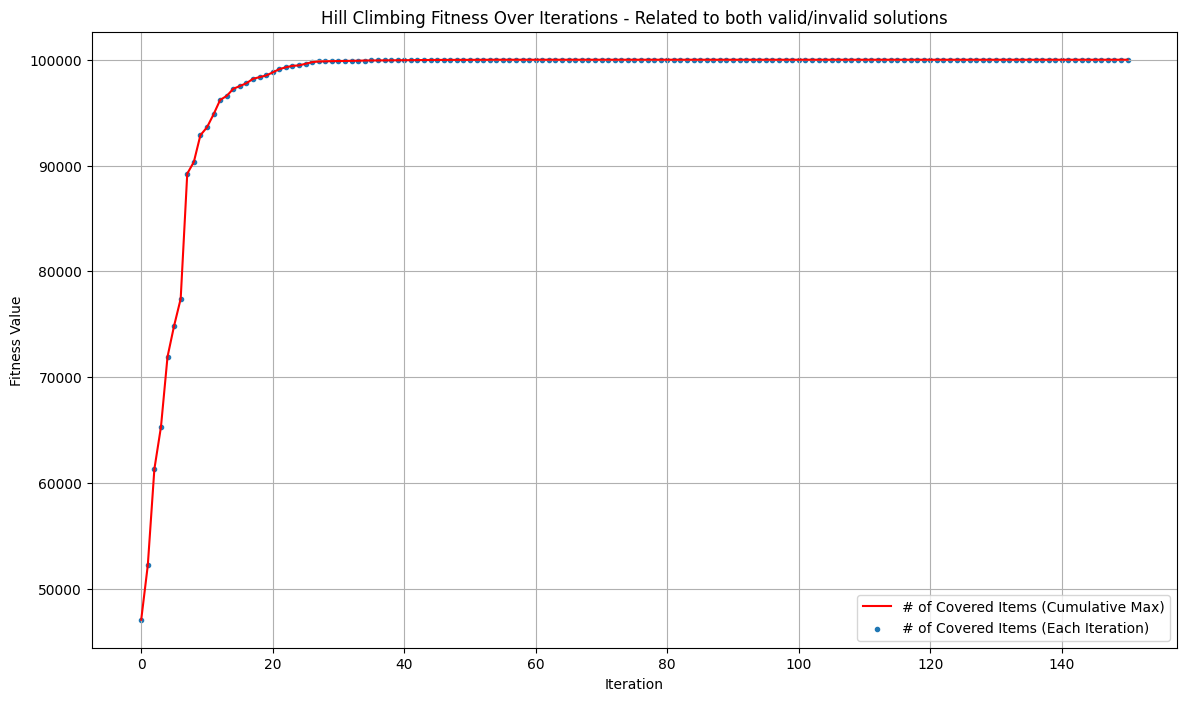

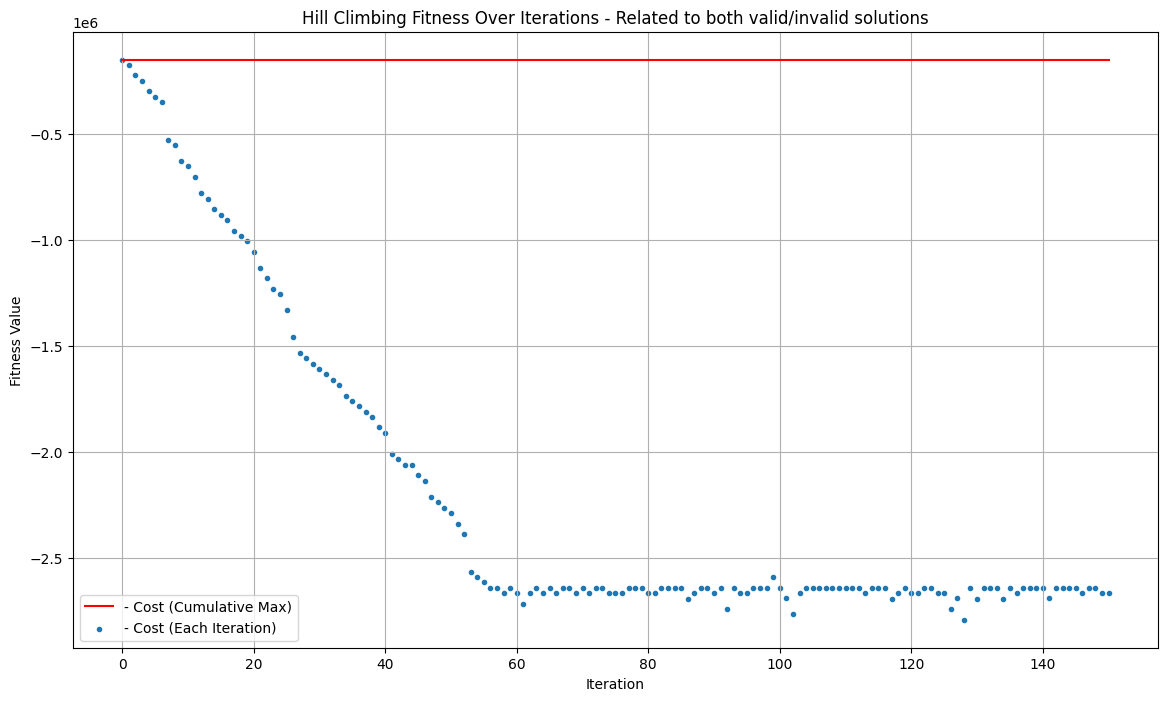

ic| UNIVERSE_SIZE: 100000
    NUM_SETS: 10000
    DENSITY: 0.2
    valid(s): np.True_
    cost(s): np.float64(2530235.441073662)
    num_steps: 22


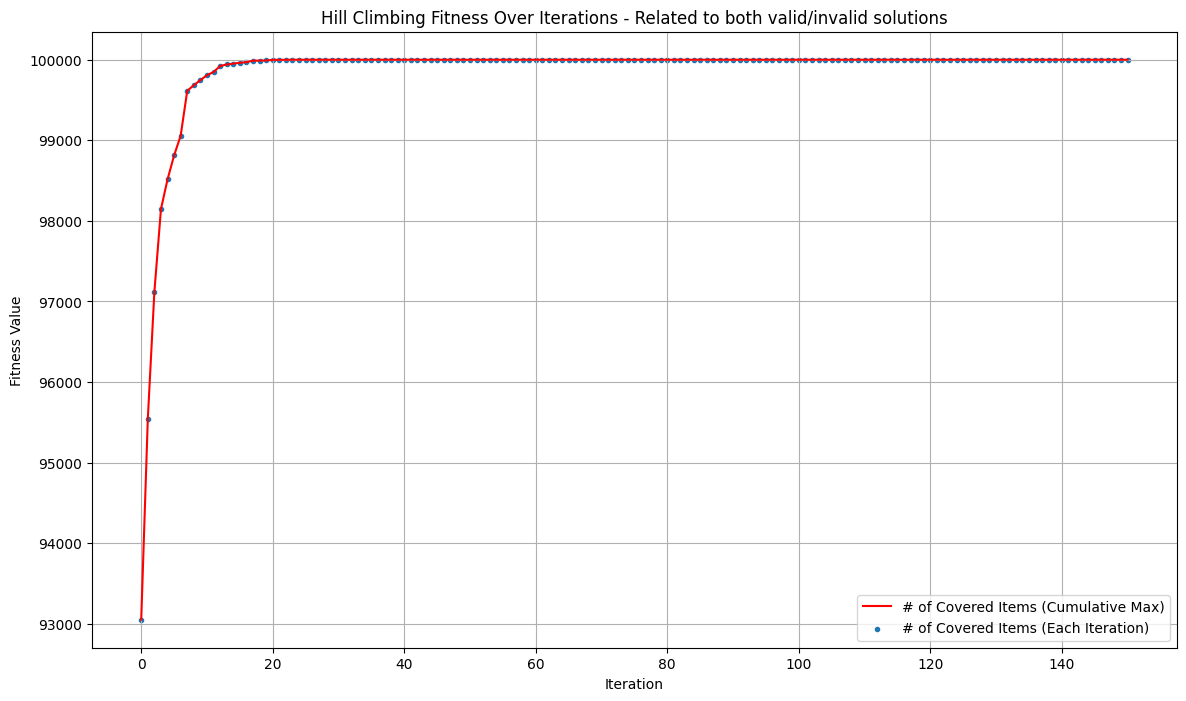

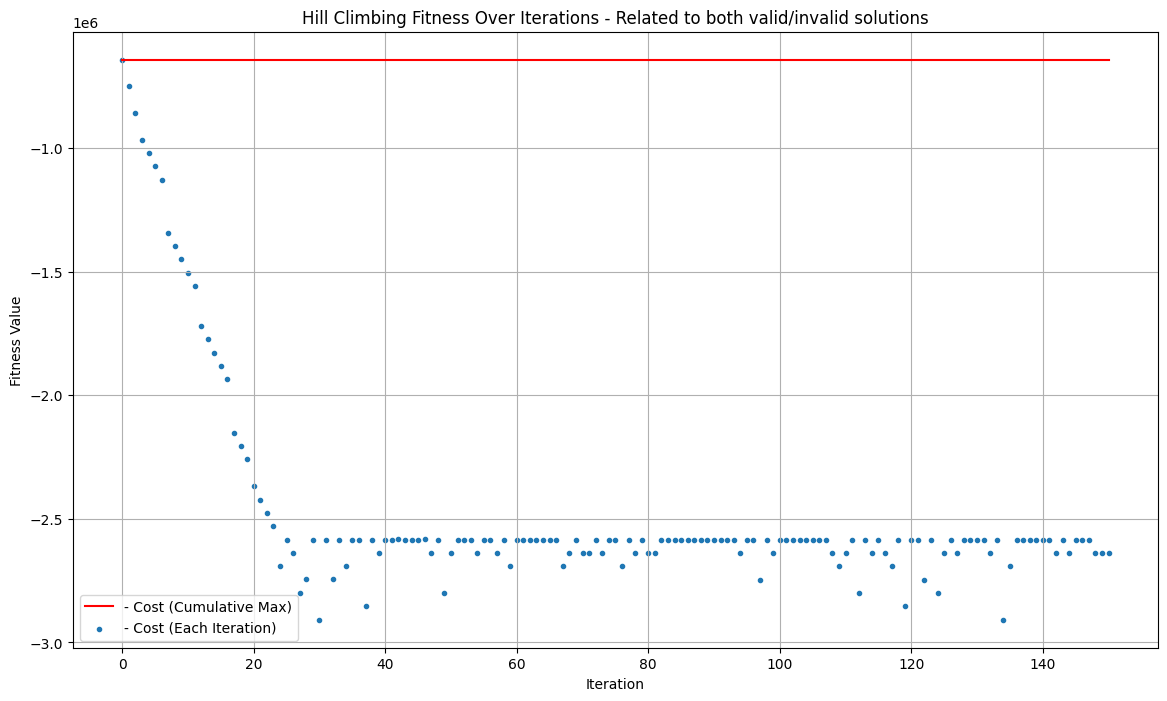

ic| UNIVERSE_SIZE: 100000
    NUM_SETS: 10000
    DENSITY: 0.3
    valid(s): np.True_
    cost(s): np.float64(2607641.1191011514)
    num_steps: 5


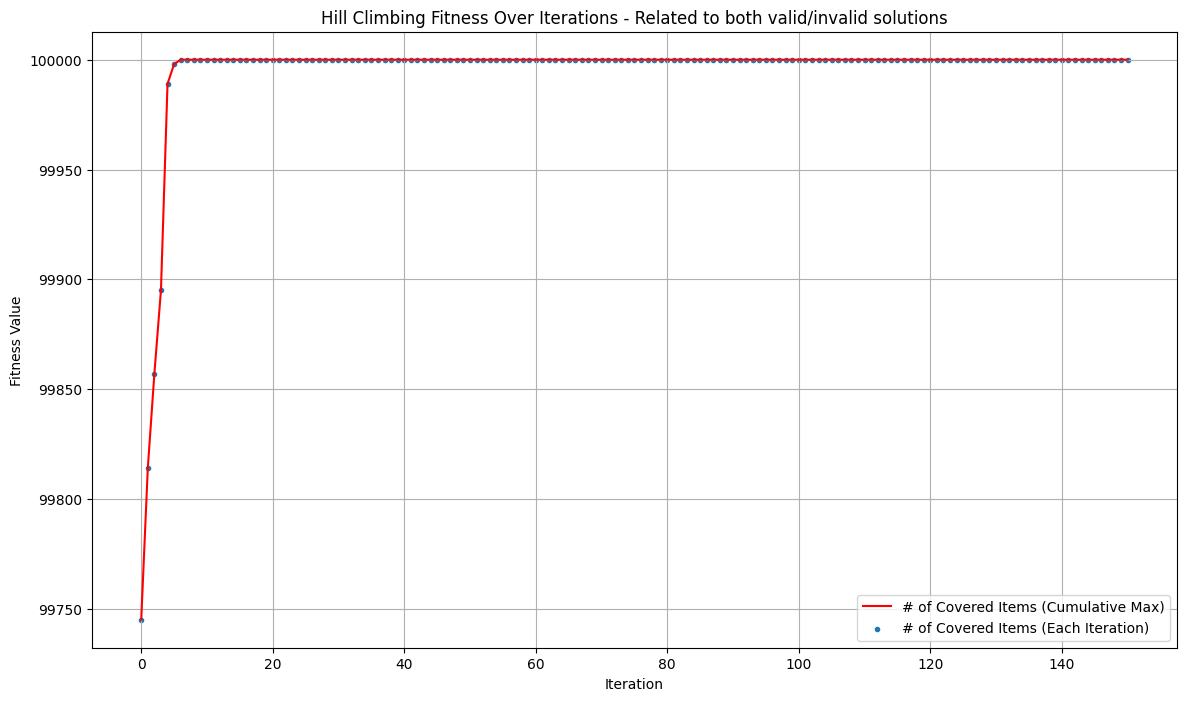

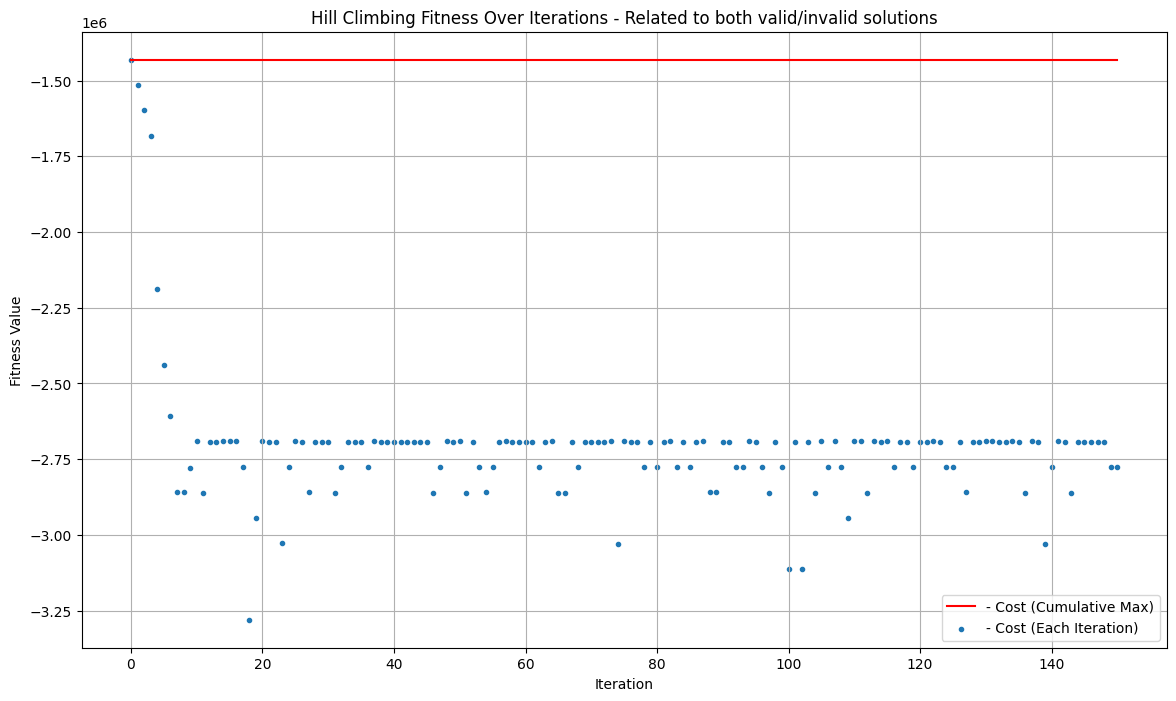

In [6]:
with open(file_path, 'a') as file:
    file.write("\t\t\tHILL CLIMBING - MULTIPLE RANDOM MUTATIONS - SECOND FITNESS AND STARTING POINT\n")
    for index in range(num_instances):
        initialize_set_cover_problem(universe_size_instances[index], num_sets_instances[index], density_instances[index])

        s, history, num_steps = hill_climbing(tweak_2, fitness_2, starting_point_2)
        stats = f"Instance {index + 1}:\n" \
                f"UNIVERSE_SIZE = {UNIVERSE_SIZE}, NUM_SETS = {NUM_SETS}, DENSITY = {DENSITY}\n" \
                f"Valid Solution: {valid(s)}, Cost: {cost(s)}, # steps: {num_steps}\n\n"
        ic(UNIVERSE_SIZE, NUM_SETS, DENSITY, valid(s), cost(s), num_steps)
        file.write(stats)

        #first criterion: # of covered items, second criterion: -cost
        fitness_values = [first_fitness_criterion for first_fitness_criterion, second_fitness_criterion in history]
        fitness_plot(fitness_values, "# of Covered Items (Cumulative Max)", "# of Covered Items (Each Iteration)")

        #first criterion: validity, second criterion: -cost
        fitness_values = [second_fitness_criterion for first_fitness_criterion, second_fitness_criterion in history]
        fitness_plot(fitness_values, "- Cost (Cumulative Max)", "- Cost (Each Iteration)")
    file.write("\n\n")

#### Multiple random mutations with an improved tweak function

ic| UNIVERSE_SIZE: 100
    NUM_SETS: 10
    DENSITY: 0.2
    valid(s): np.True_
    cost(s): np.float64(278.98827318170595)
    num_steps: 13


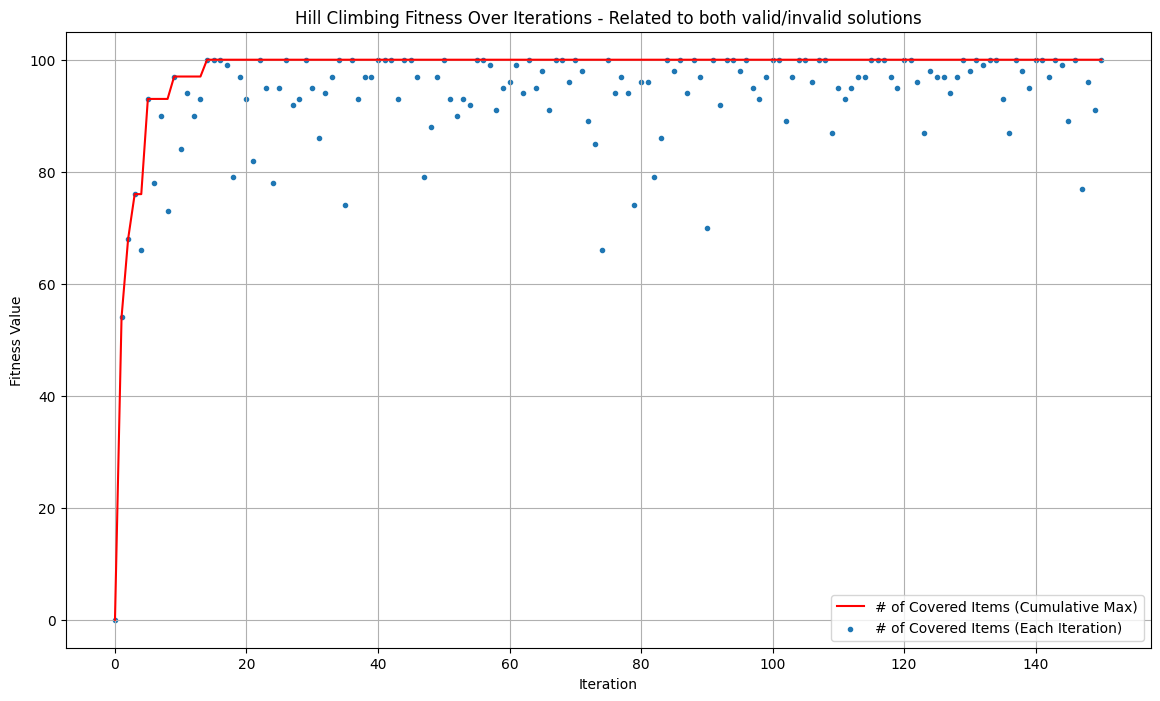

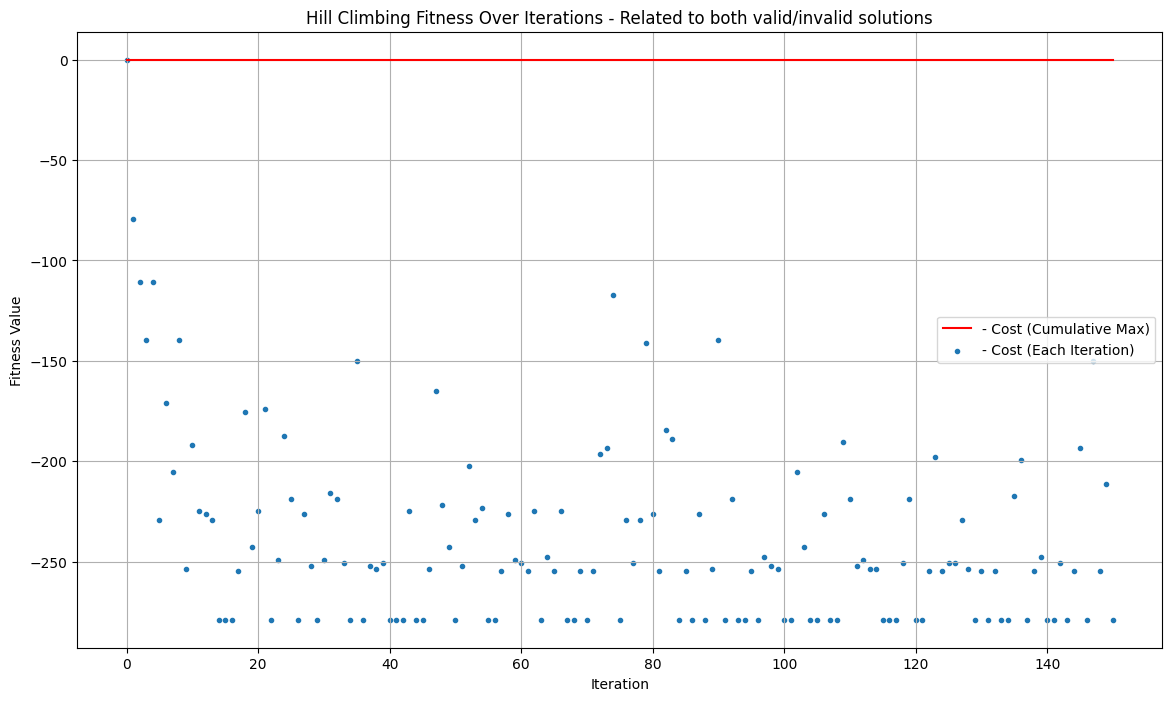

ic| UNIVERSE_SIZE: 1000
    NUM_SETS: 100
    DENSITY: 0.2
    valid(s): np.True_
    cost(s): np.float64(7488.849803352042)
    num_steps: 115


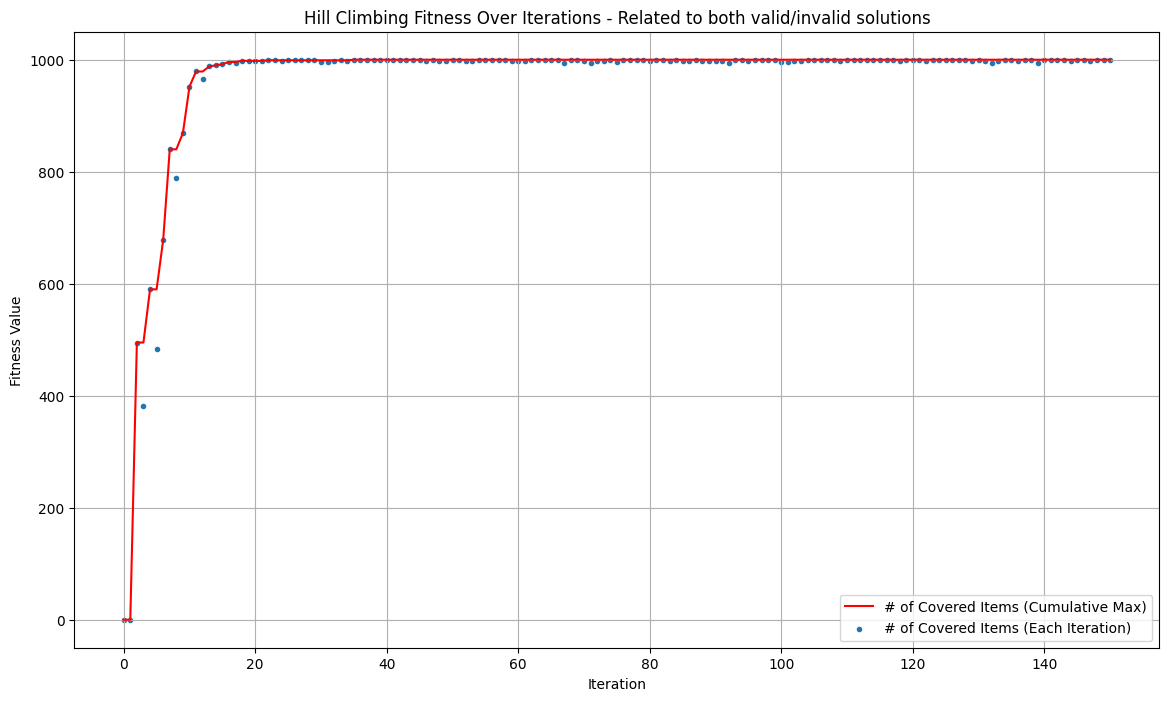

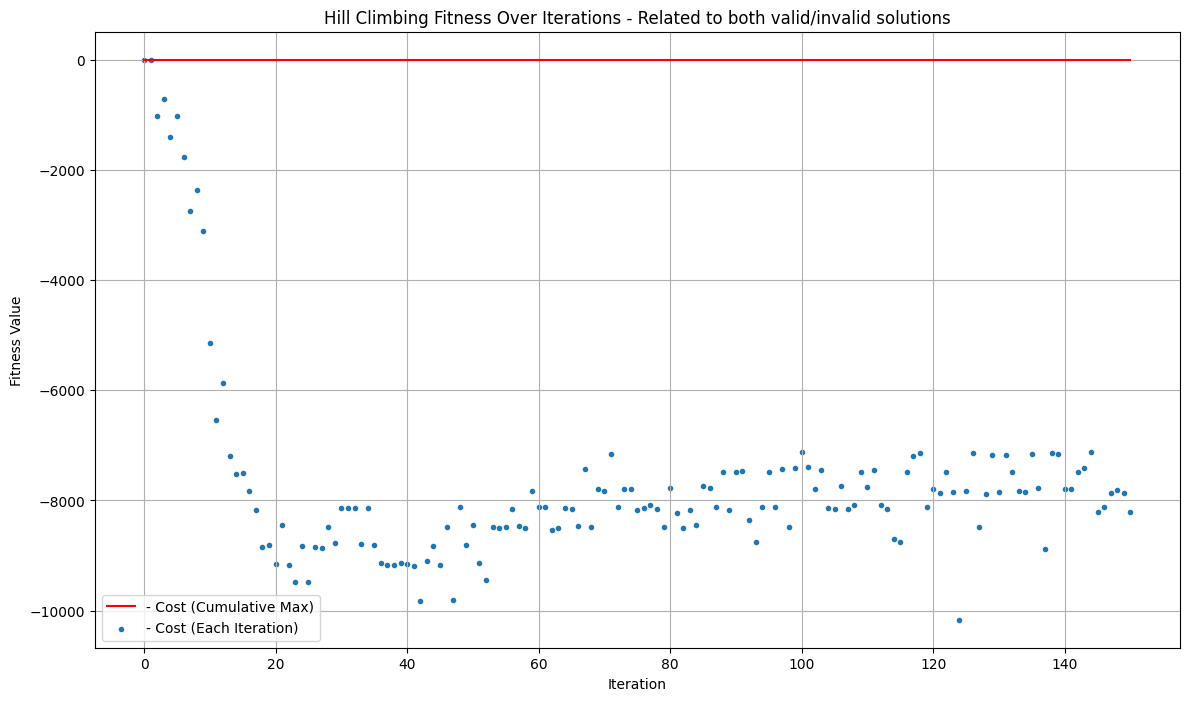

ic| UNIVERSE_SIZE: 10000
    NUM_SETS: 1000
    DENSITY: 0.2
    valid(s): np.True_
    cost(s): np.float64(132757.4706690662)
    num_steps: 148


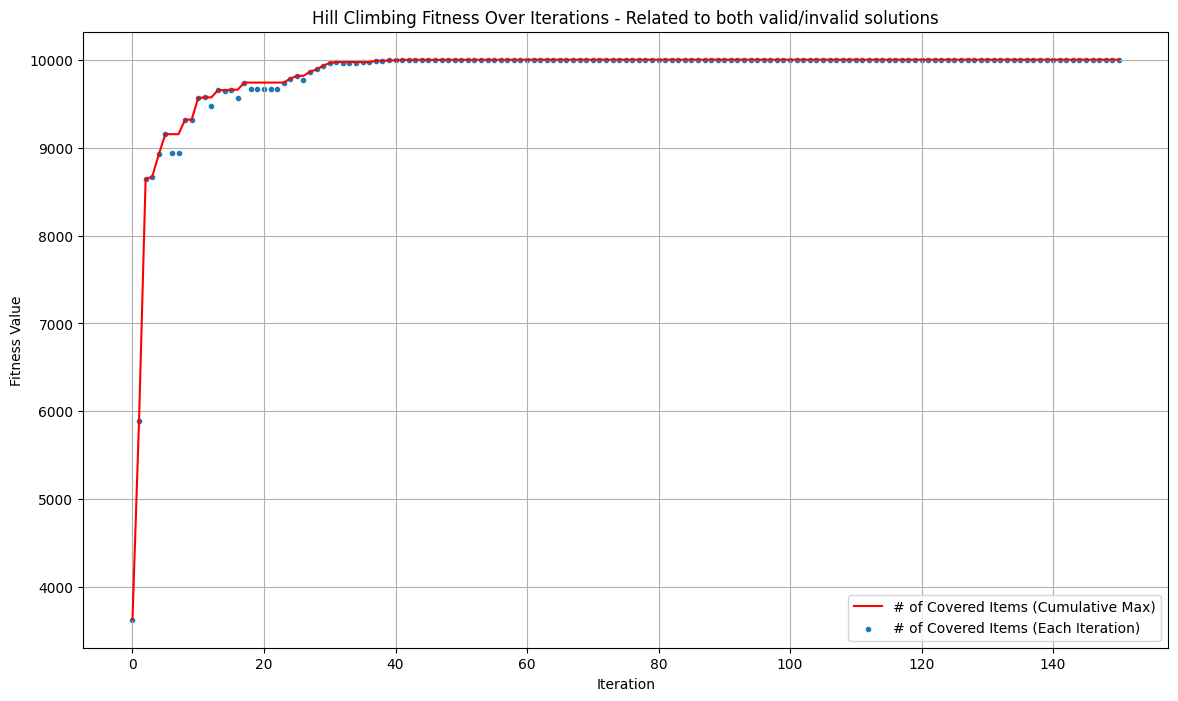

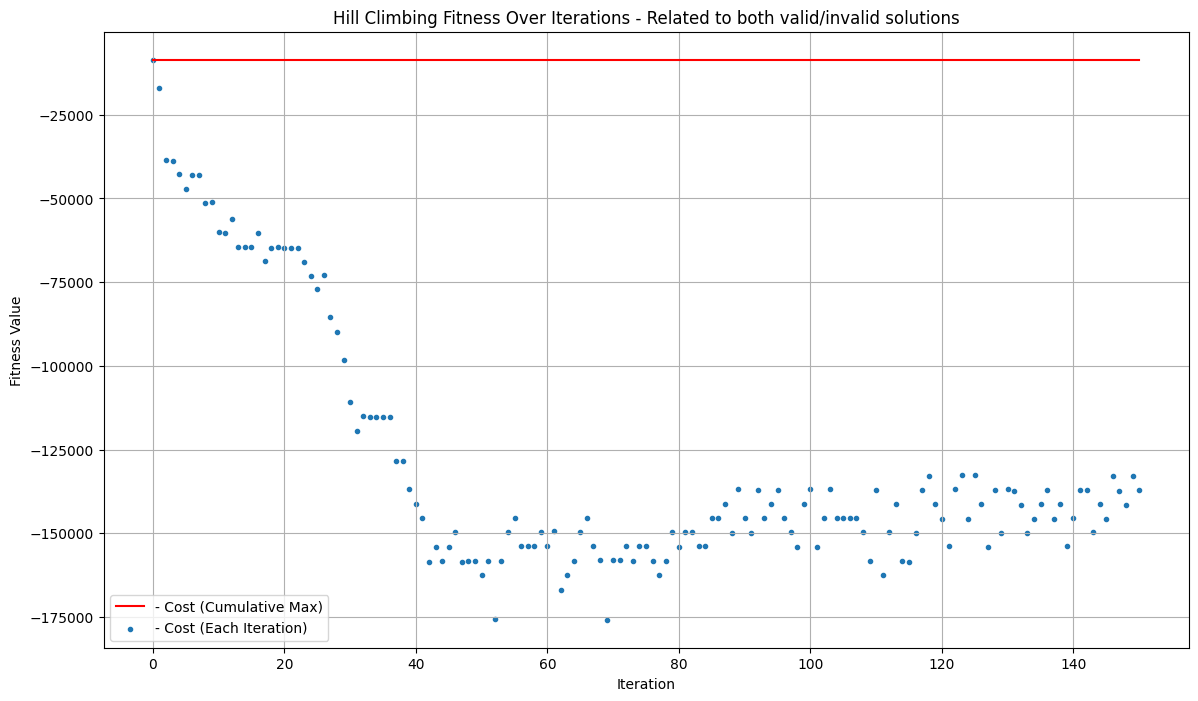

ic| UNIVERSE_SIZE: 100000
    NUM_SETS: 10000
    DENSITY: 0.1
    valid(s): np.True_
    cost(s): np.float64(2289452.7593987496)
    num_steps: 147


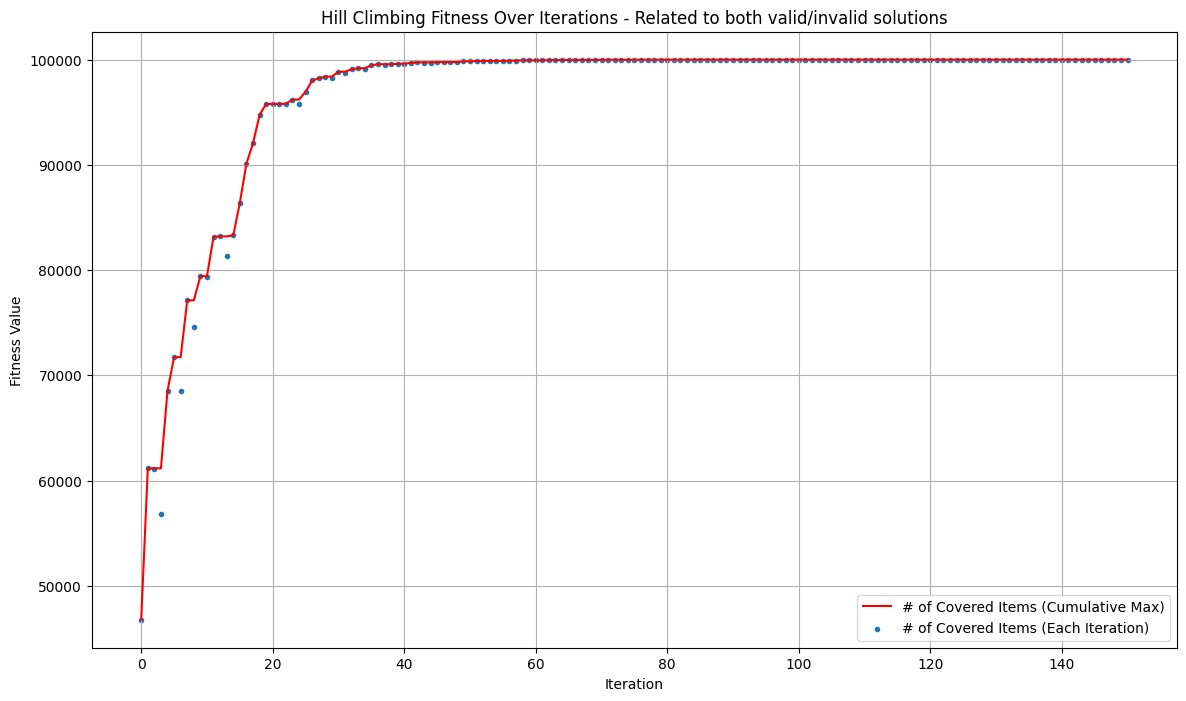

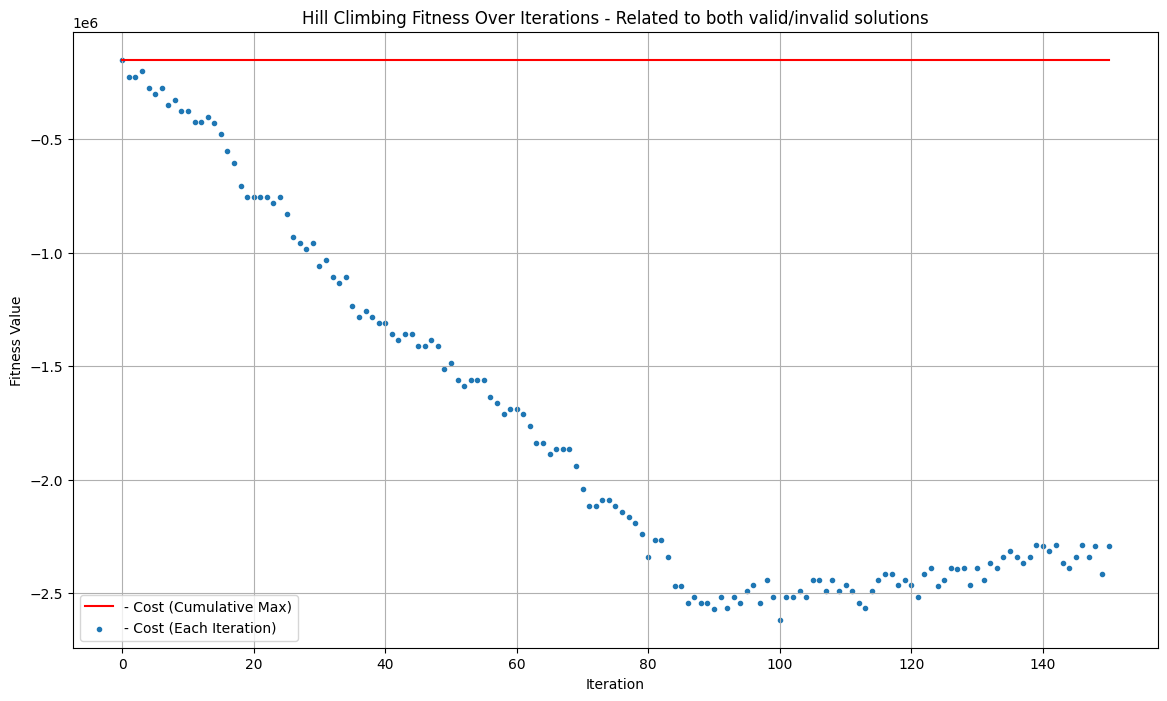

ic| UNIVERSE_SIZE: 100000
    NUM_SETS: 10000
    DENSITY: 0.2
    valid(s): np.True_
    cost(s): np.float64(2097044.607331407)
    num_steps: 133


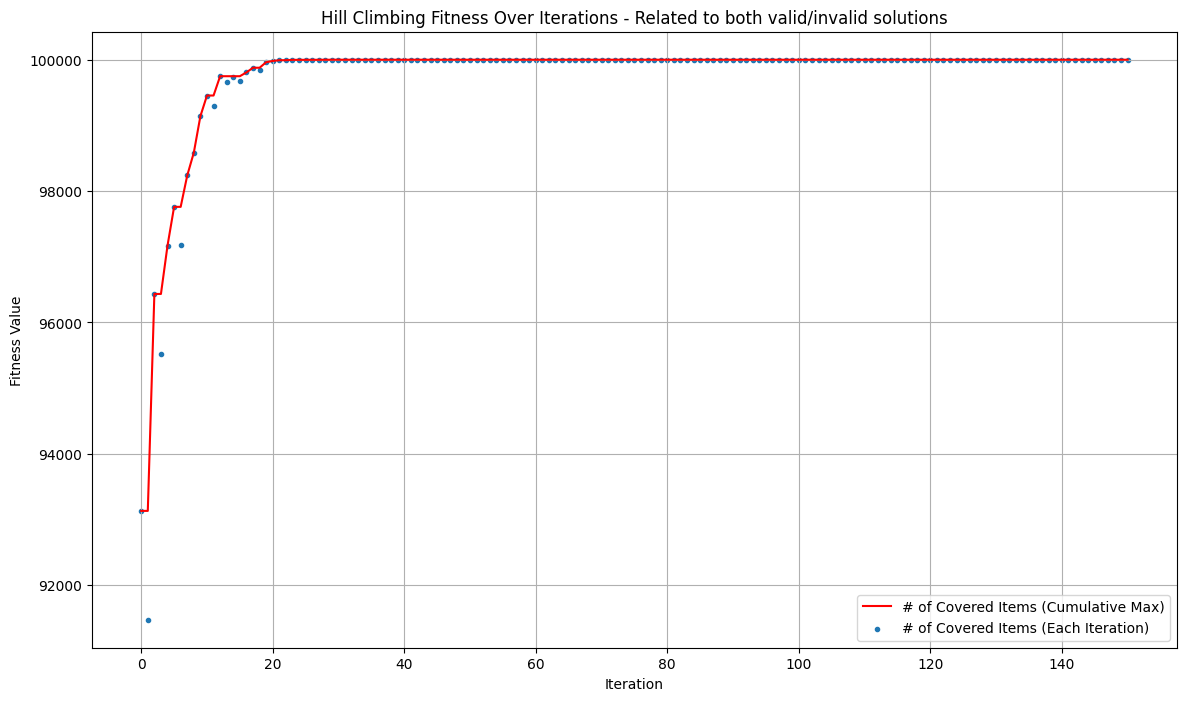

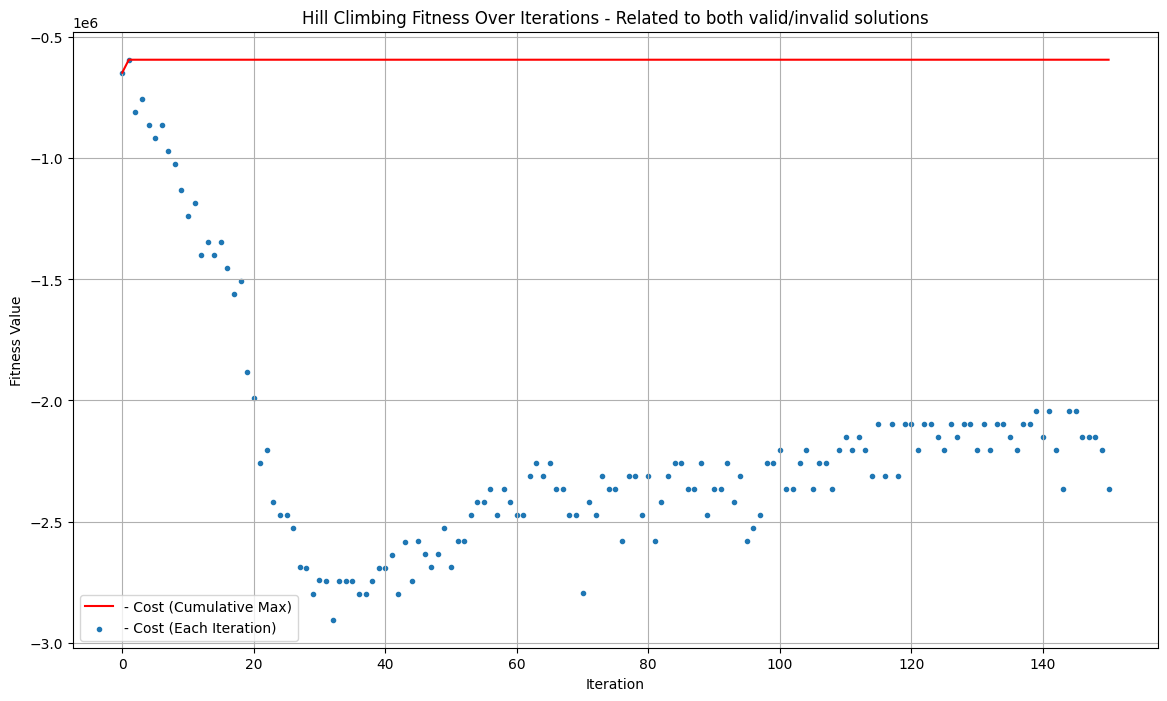

ic| UNIVERSE_SIZE: 100000
    NUM_SETS: 10000
    DENSITY: 0.3
    valid(s): np.True_
    cost(s): np.float64(2267580.044361133)
    num_steps: 76


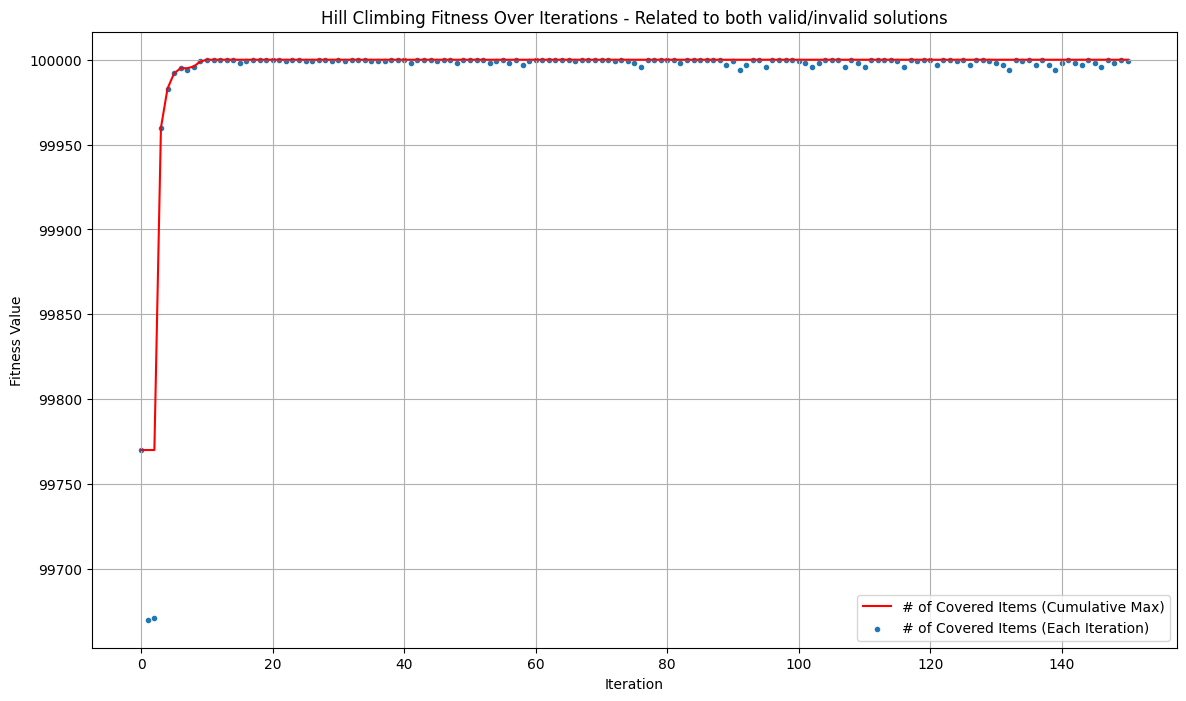

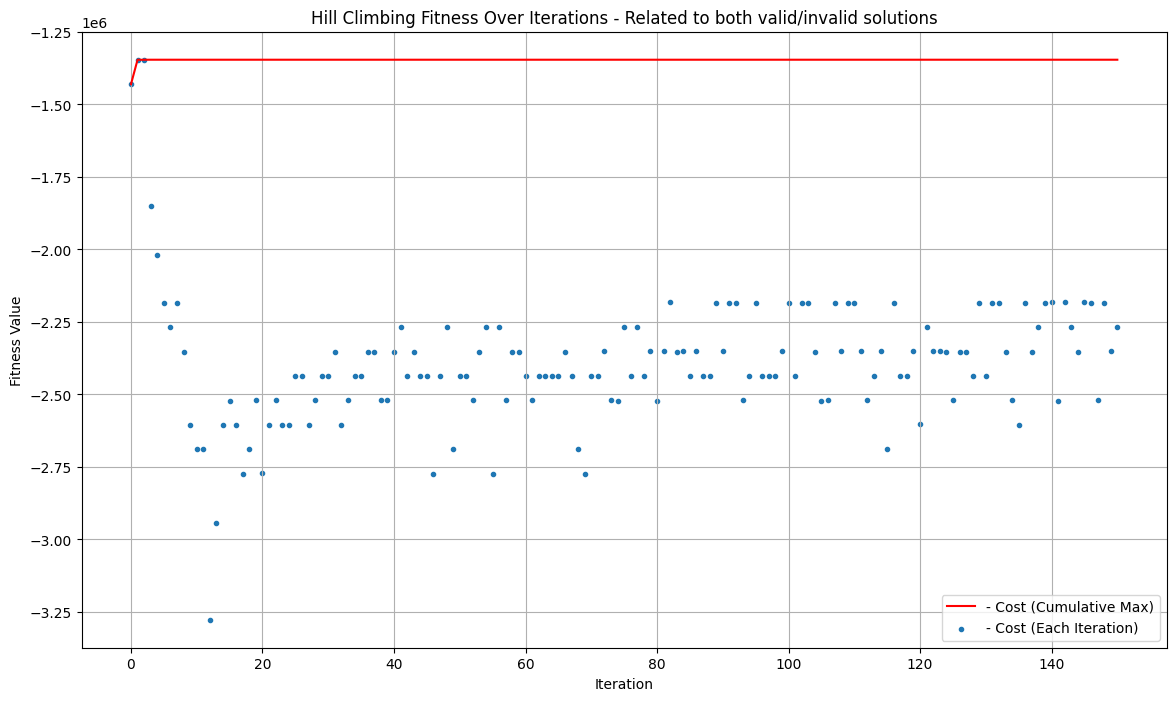

In [7]:
with open(file_path, 'a') as file:
    file.write("\t\t\tHILL CLIMBING - MULTIPLE RANDOM MUTATIONS WITH AN IMPROVED TWEAK FUNCTION\n")    
    for index in range(num_instances):
        initialize_set_cover_problem(universe_size_instances[index], num_sets_instances[index], density_instances[index])

        s, history, num_steps = hill_climbing(tweak_3, fitness_2, starting_point_2)
        stats = f"Instance {index + 1}:\n" \
                f"UNIVERSE_SIZE = {UNIVERSE_SIZE}, NUM_SETS = {NUM_SETS}, DENSITY = {DENSITY}\n" \
                f"Valid Solution: {valid(s)}, Cost: {cost(s)}, #steps: {num_steps}\n\n"
        ic(UNIVERSE_SIZE, NUM_SETS, DENSITY, valid(s), cost(s), num_steps)
        file.write(stats)

        #first criterion: # of covered items, second criterion: -cost
        fitness_values = [first_fitness_criterion for first_fitness_criterion, second_fitness_criterion in history]
        fitness_plot(fitness_values, "# of Covered Items (Cumulative Max)", "# of Covered Items (Each Iteration)")

        #first criterion: validity, second criterion: -cost
        fitness_values = [second_fitness_criterion for first_fitness_criterion, second_fitness_criterion in history]
        fitness_plot(fitness_values, "- Cost (Cumulative Max)", "- Cost (Each Iteration)")
    file.write("\n\n")

### Hill Climbing - Steepest Step and Restart

In [40]:
NUM_RESTARTS = 3
STEEPEST_STEP_CANDIDATES = 5
TRUE_MAX_STEPS = max(stopping_criterion(NUM_STEPS=300)) // STEEPEST_STEP_CANDIDATES

def steepest_step(solution, history, tweak=tweak_2, fitness=fitness_1):
    # Find the best tweak among a set of candidates
    best_solution = solution
    best_fitness = fitness(solution)
    best_index = 0
    for index in range(STEEPEST_STEP_CANDIDATES):
        candidate = tweak(solution)
        candidate_fitness = fitness(candidate)
        history.append(candidate_fitness)
        if candidate_fitness > best_fitness:
            best_solution = candidate
            best_fitness = candidate_fitness
            best_index = index
    return best_solution, best_index

def hill_climbing_with_restarts(init_fitness, fitness, starting_point):
    # Run hill climbing with multiple restarts
    best_solution = None
    best_fitness = init_fitness
    history = list()
    best_step = 0  # Track the step at which the best solution was found
    global_step = 0  # Track the global step

    for _ in range(NUM_RESTARTS):
        solution = starting_point()
        solution_fitness = fitness(solution)
        history.append(solution_fitness)
        global_step += 1  # Increment the global step after each restart
        
        # If the current solution is better than the best solution so far, update the best solution
        if solution_fitness > best_fitness:
            best_fitness = solution_fitness
            best_step = global_step  # Update the best step

        # Run hill climbing for this restart
        for _ in range(TRUE_MAX_STEPS // NUM_RESTARTS):
            new_solution, _ = steepest_step(solution, history, fitness=fitness)
            new_fitness = fitness(new_solution)
            global_step += 1  # Increase the global step counter after each iteration
            
            # Check if we have found a new best fitness
            if new_fitness > best_fitness:
                best_solution = new_solution
                best_fitness = new_fitness
                best_step = global_step  # Update the best step

            if new_fitness > fitness(solution):
                solution = new_solution

    return best_solution, history, best_step

#### Steepest Step and Restart with first fitness and starting point

ic| UNIVERSE_SIZE: 100
    NUM_SETS: 10
    DENSITY: 0.2
    valid(s): np.False_
    cost(s): np.float64(283.9830331201974)
    num_steps: 1


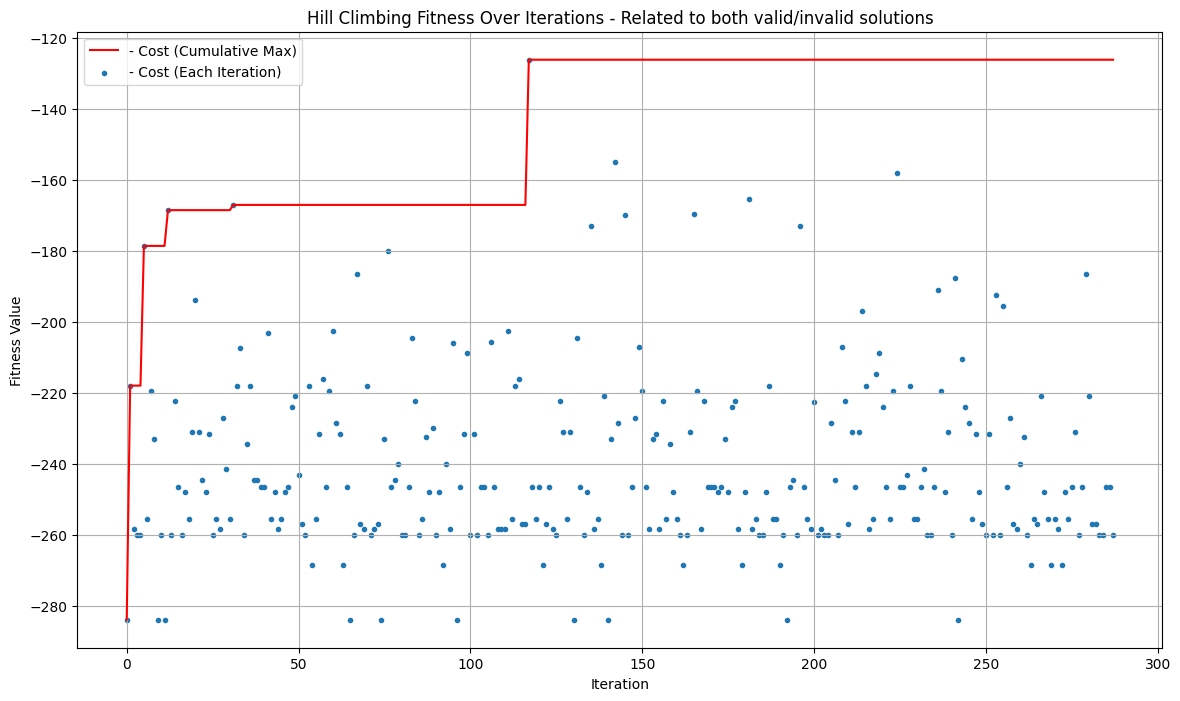

ic| UNIVERSE_SIZE: 1000
    NUM_SETS: 100
    DENSITY: 0.2
    valid(s): np.True_
    cost(s): np.float64(17754.90898689799)
    num_steps: 60


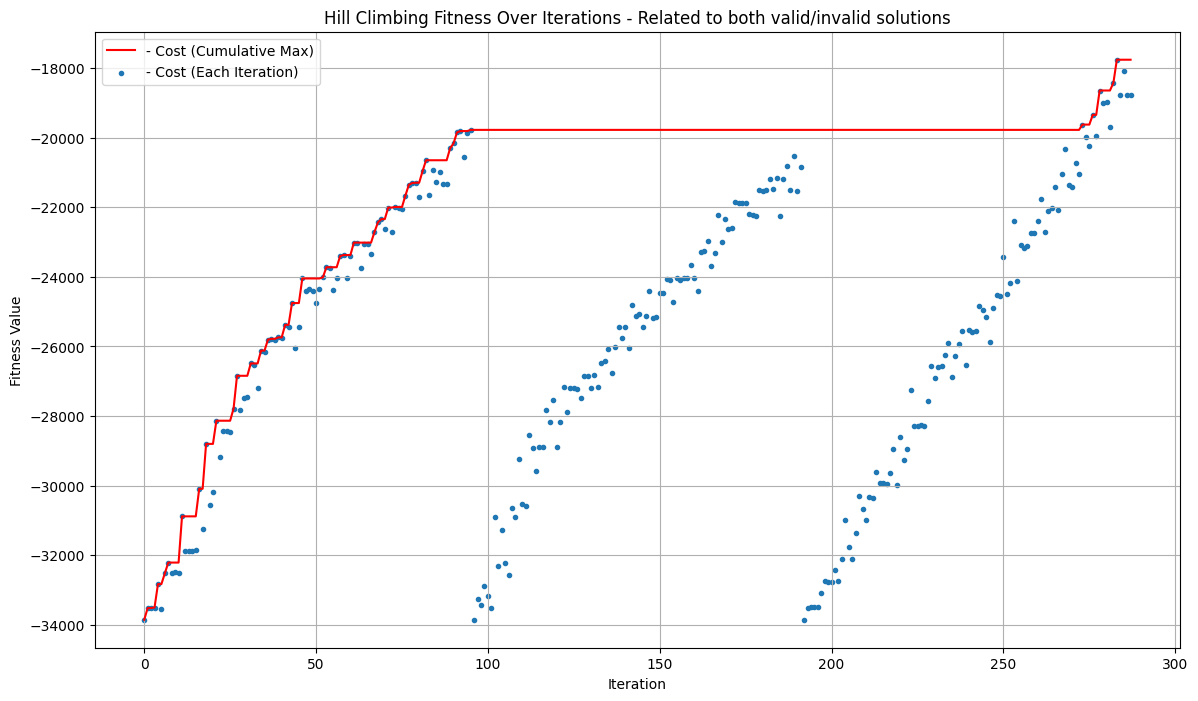

ic| UNIVERSE_SIZE: 10000
    NUM_SETS: 1000
    DENSITY: 0.2
    valid(s): np.True_
    cost(s): np.float64(4044998.357181617)
    num_steps: 20


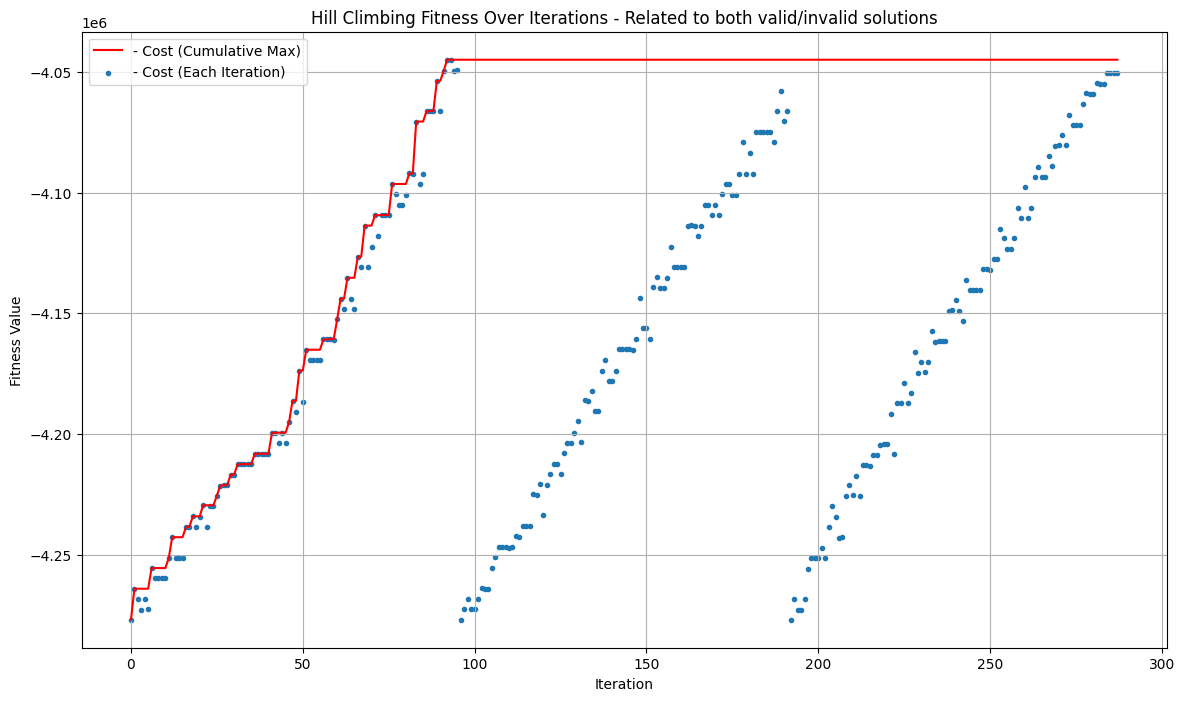

ic| UNIVERSE_SIZE: 100000
    NUM_SETS: 10000
    DENSITY: 0.1
    valid(s): np.True_
    cost(s): np.float64(249625311.4819492)
    num_steps: 20


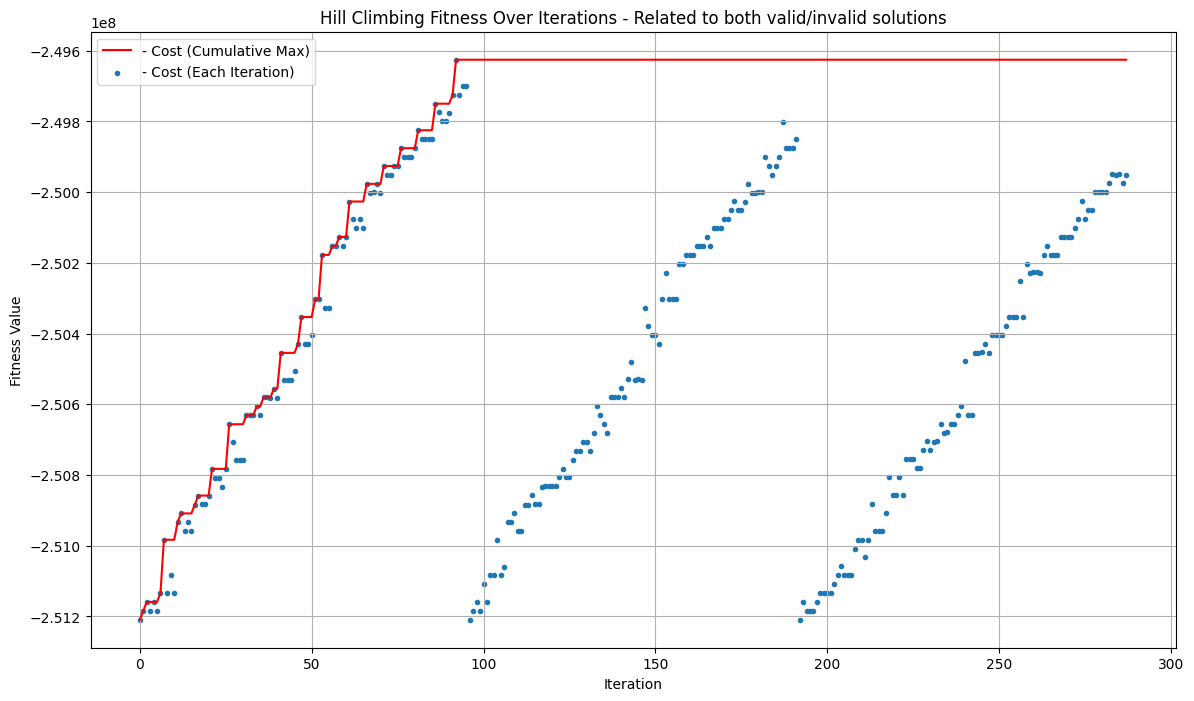

ic| UNIVERSE_SIZE: 100000
    NUM_SETS: 10000
    DENSITY: 0.2
    valid(s): np.True_
    cost(s): np.float64(535291925.9467063)
    num_steps: 60


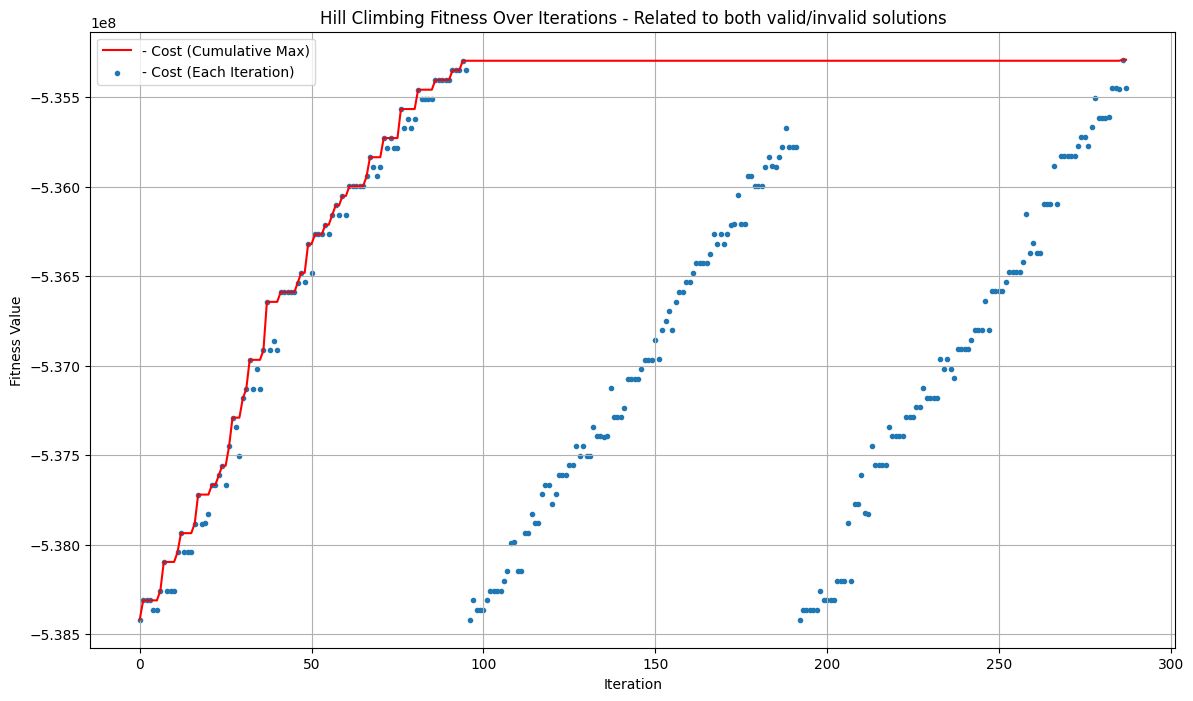

ic| UNIVERSE_SIZE: 100000
    NUM_SETS: 10000
    DENSITY: 0.3
    valid(s): np.True_
    cost(s): np.float64(835681945.1261017)
    num_steps: 60


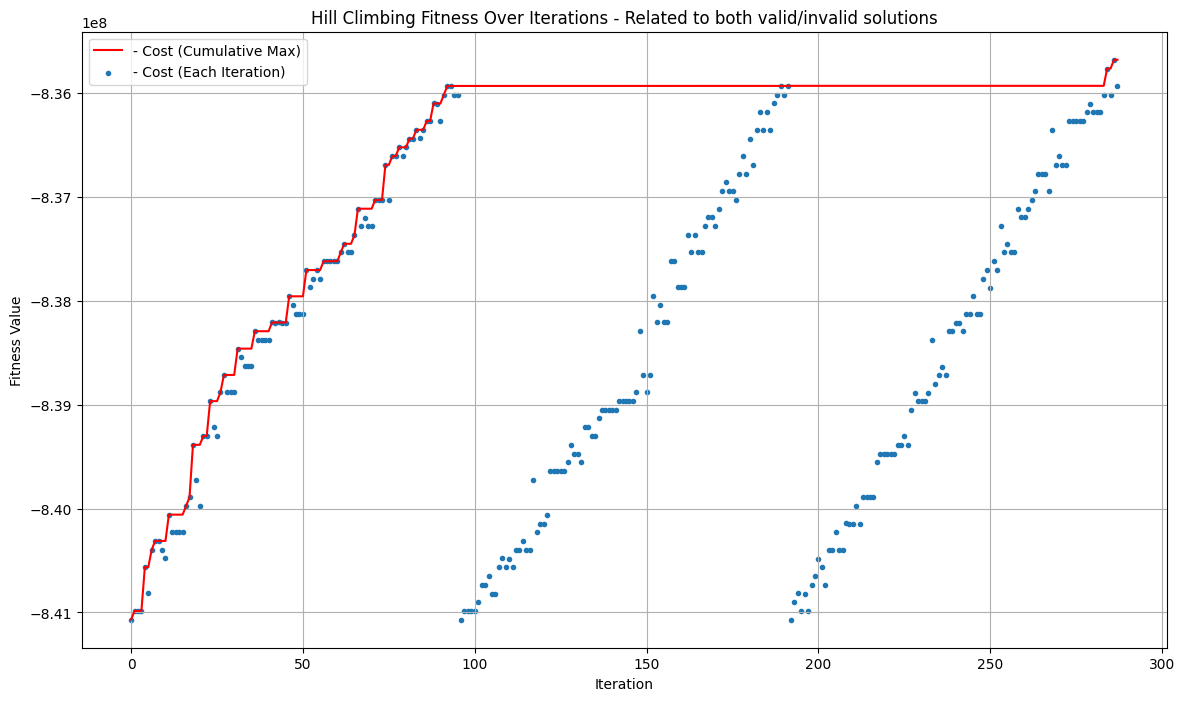

In [41]:
with open(file_path, 'a') as file:
    file.write("\t\t\tHILL CLIMBING - STEEPEST STEP AND RESTART - FIRST FITNESS AND STARTING POINT\n")   
    for index in range(num_instances):
        initialize_set_cover_problem(universe_size_instances[index], num_sets_instances[index], density_instances[index])

        init_fitness = (False, float('-inf'))
        s, history, num_steps = hill_climbing_with_restarts(init_fitness, fitness=fitness_1, starting_point=starting_point_1)
        stats = f"Instance {index + 1}:\n" \
                f"UNIVERSE_SIZE = {UNIVERSE_SIZE}, NUM_SETS = {NUM_SETS}, DENSITY = {DENSITY}\n" \
                f"Valid Solution: {valid(s)}, Cost: {cost(s)}, #steps: {num_steps}\n\n"
        ic(UNIVERSE_SIZE, NUM_SETS, DENSITY, valid(s), cost(s), num_steps)
        file.write(stats)

        #first criterion: validity, second criterion: -cost
        fitness_values = [second_fitness_criterion for first_fitness_criterion, second_fitness_criterion in history]
        fitness_plot(fitness_values, "- Cost (Cumulative Max)", "- Cost (Each Iteration)")
    file.write("\n\n")

#### Steepest Step and Restart with second fitness and starting point

ic| UNIVERSE_SIZE: 100
    NUM_SETS: 10
    DENSITY: 0.2
    valid(s): np.True_
    cost(s): np.float64(286.913937826)
    num_steps: 9


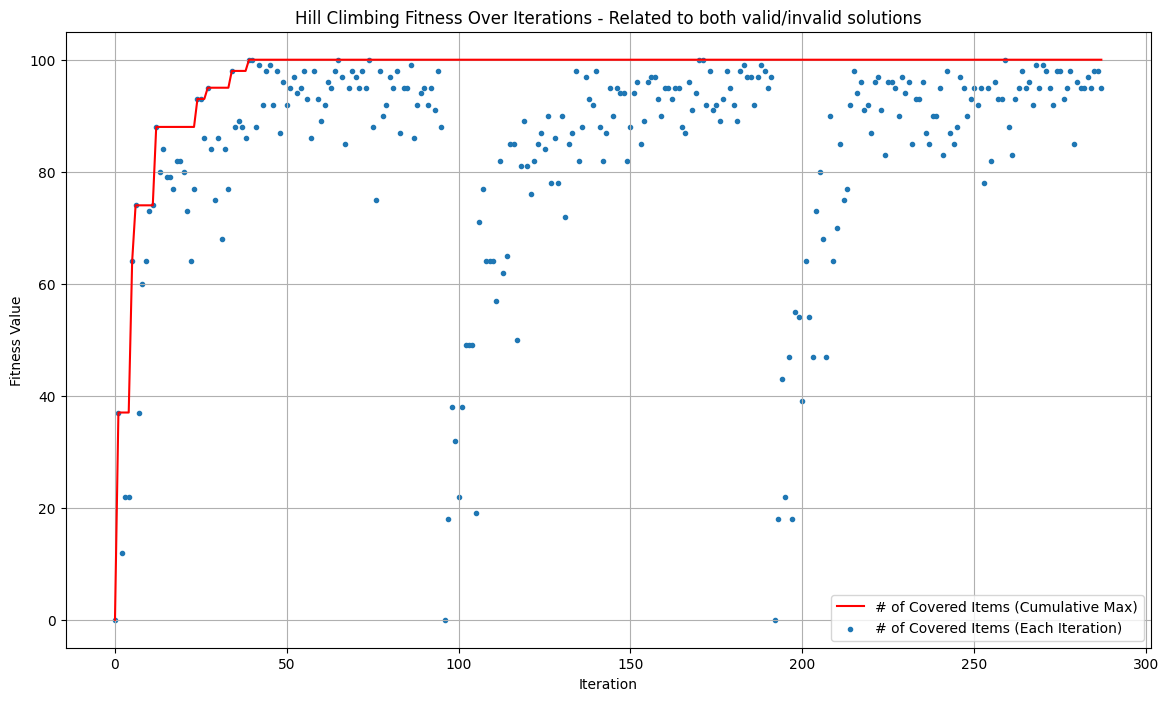

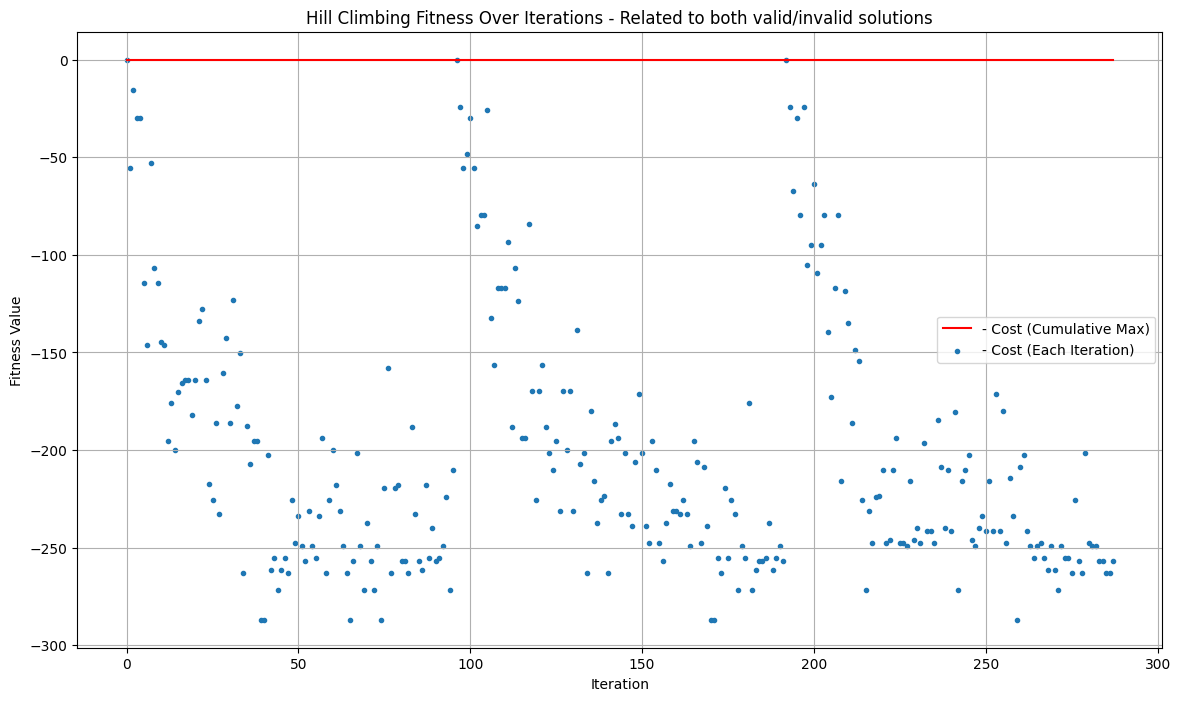

ic| UNIVERSE_SIZE: 1000
    NUM_SETS: 100
    DENSITY: 0.2
    valid(s): np.True_
    cost(s): np.float64(7762.189273788736)
    num_steps: 20


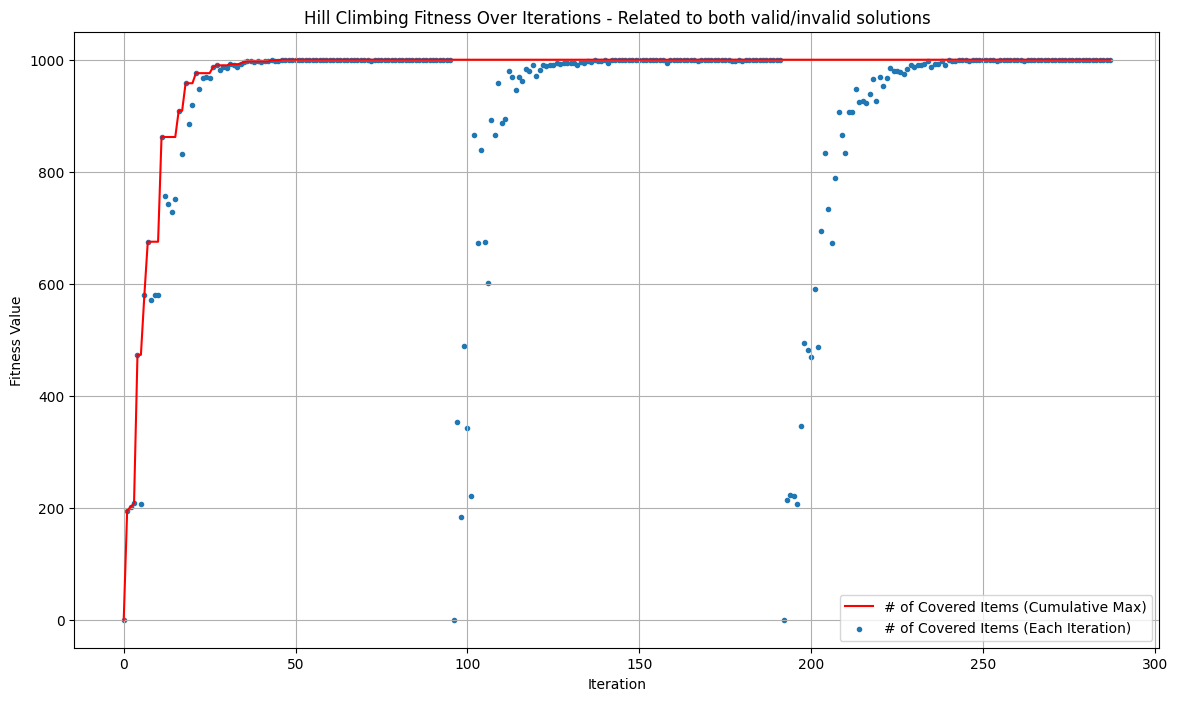

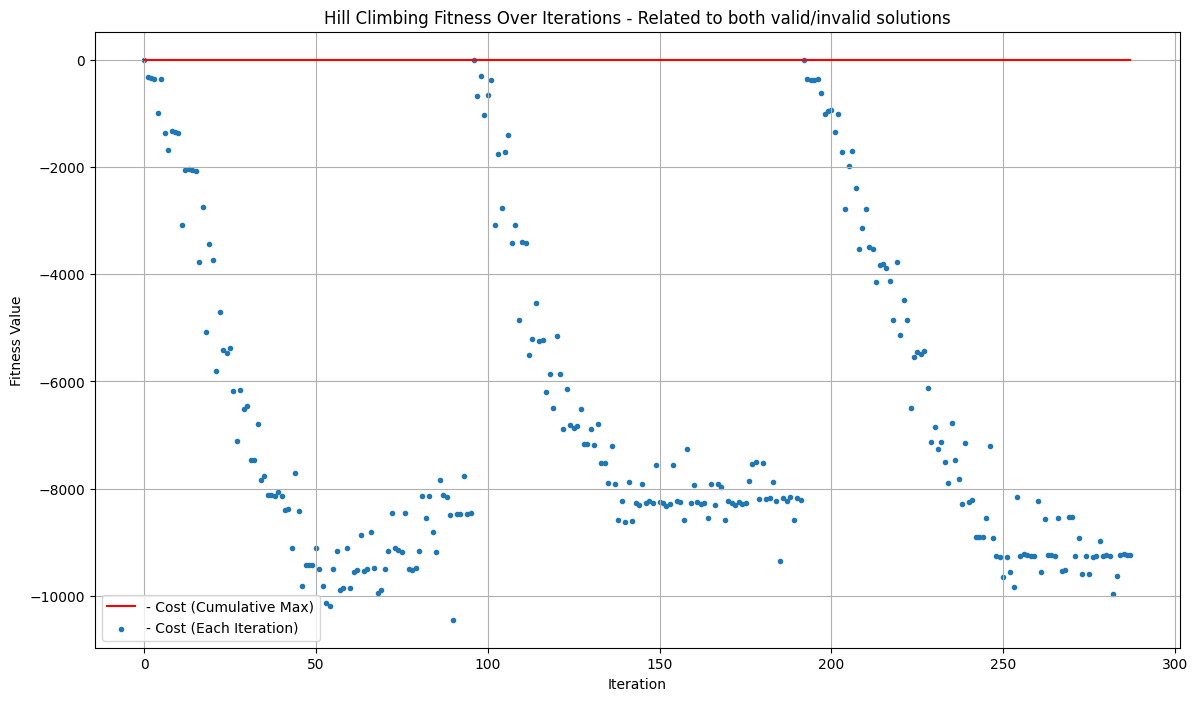

ic| UNIVERSE_SIZE: 10000
    NUM_SETS: 1000
    DENSITY: 0.2
    valid(s): np.True_
    cost(s): np.float64(149385.62546115692)
    num_steps: 34


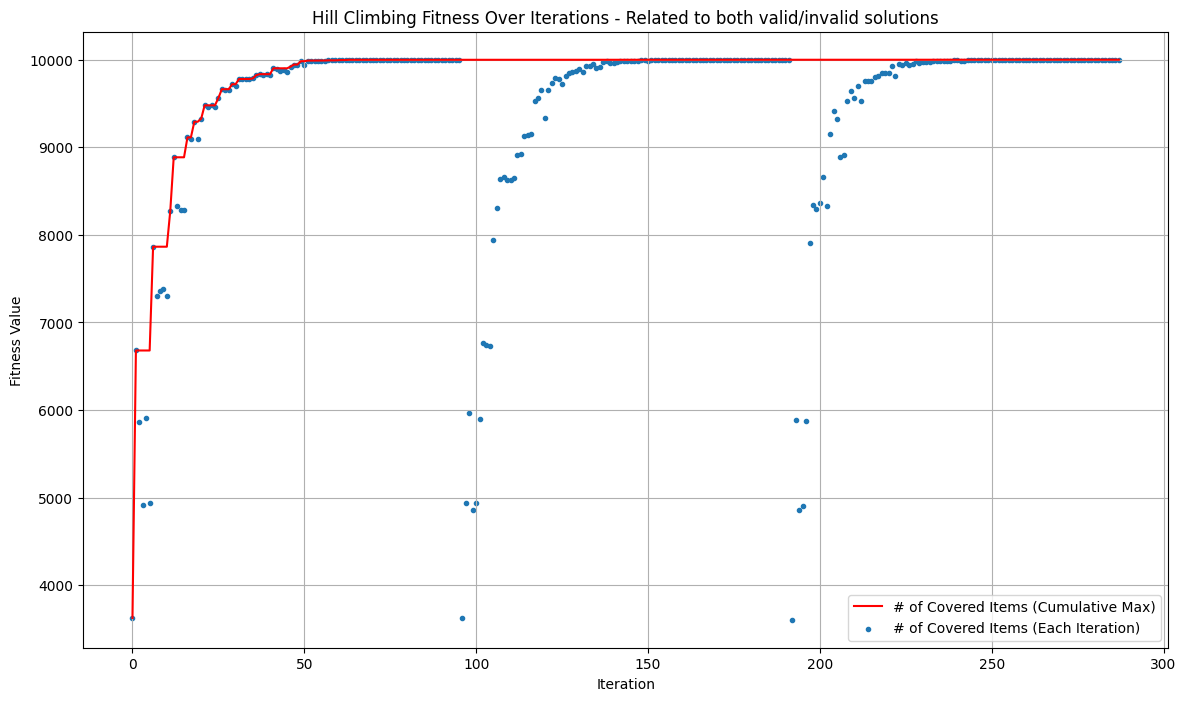

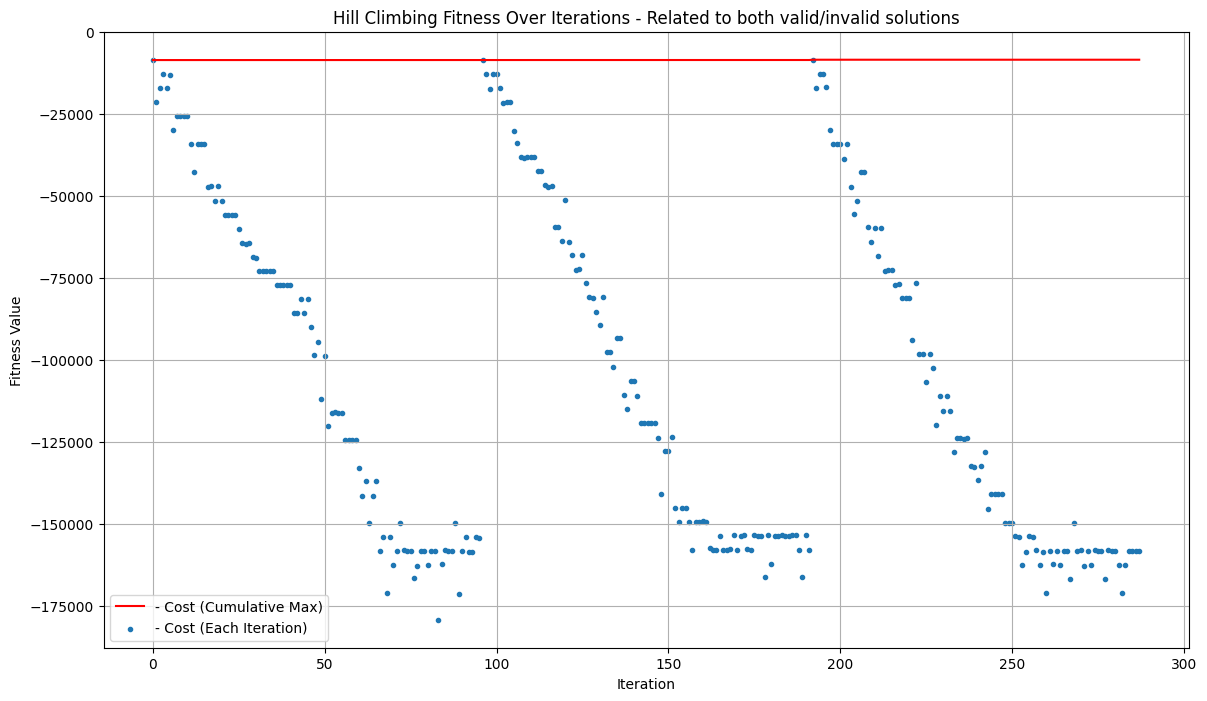

ic| UNIVERSE_SIZE: 100000
    NUM_SETS: 10000
    DENSITY: 0.1
    valid(s): np.False_
    cost(s): np.float64(1709166.0629664082)
    num_steps: 60


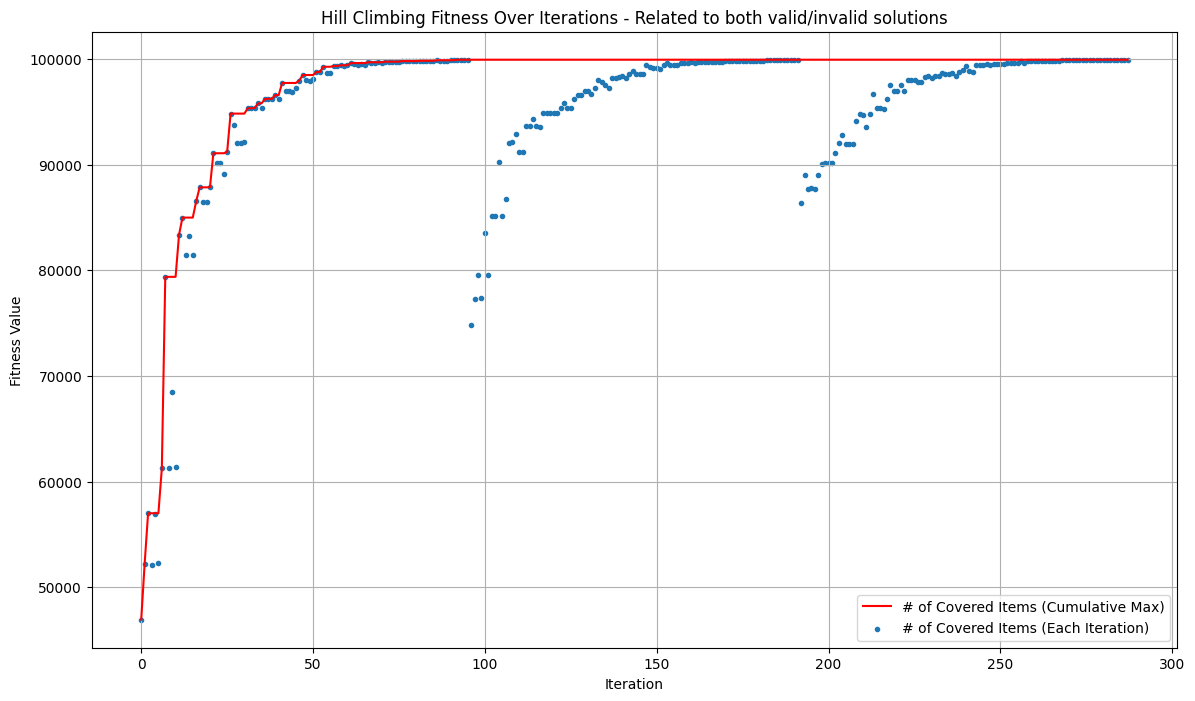

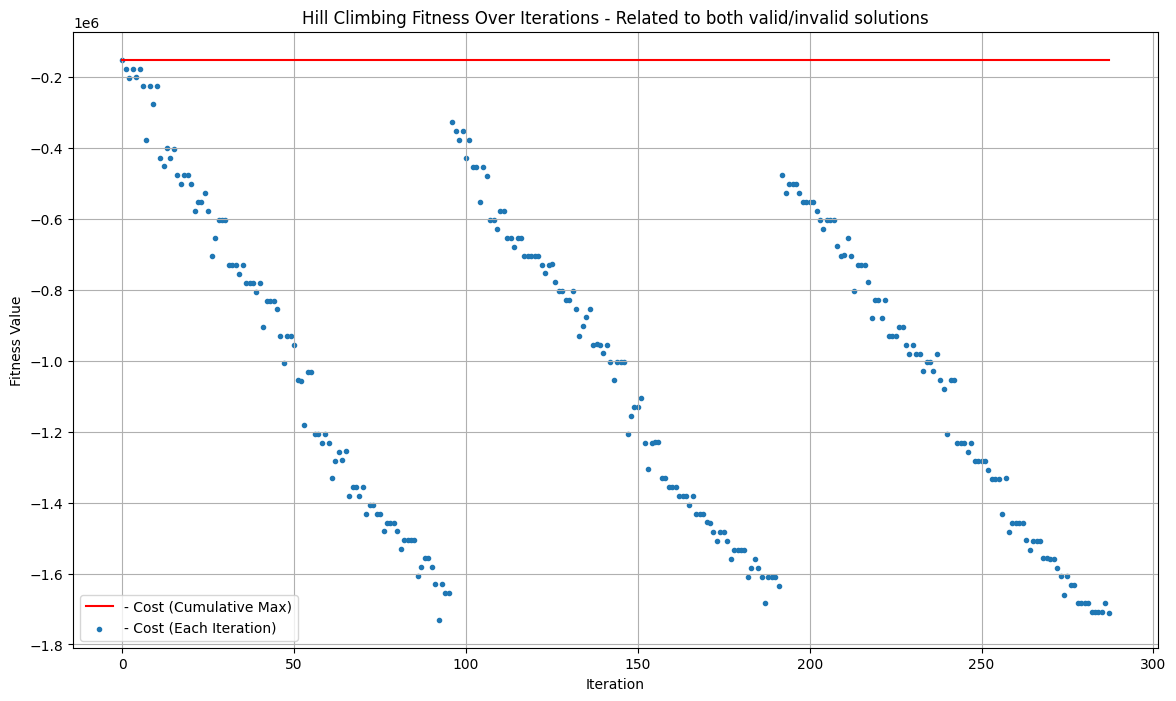

ic| UNIVERSE_SIZE: 100000
    NUM_SETS: 10000
    DENSITY: 0.2
    valid(s): np.True_
    cost(s): np.float64(2476388.559224483)
    num_steps: 55


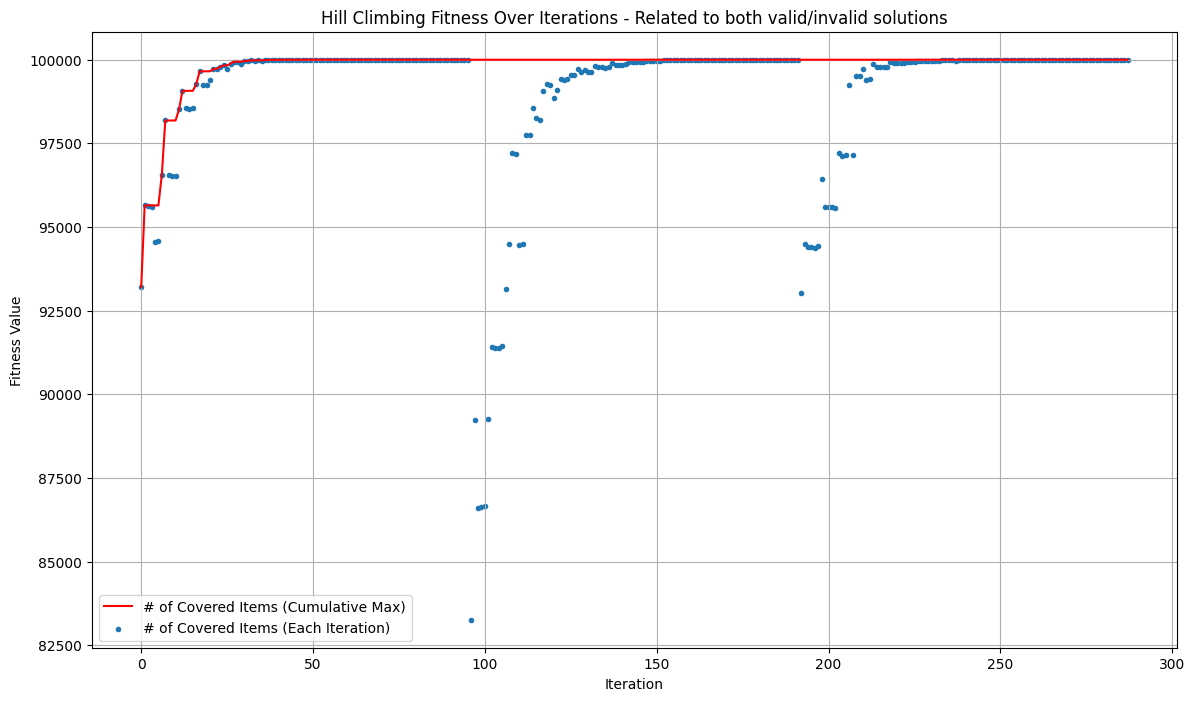

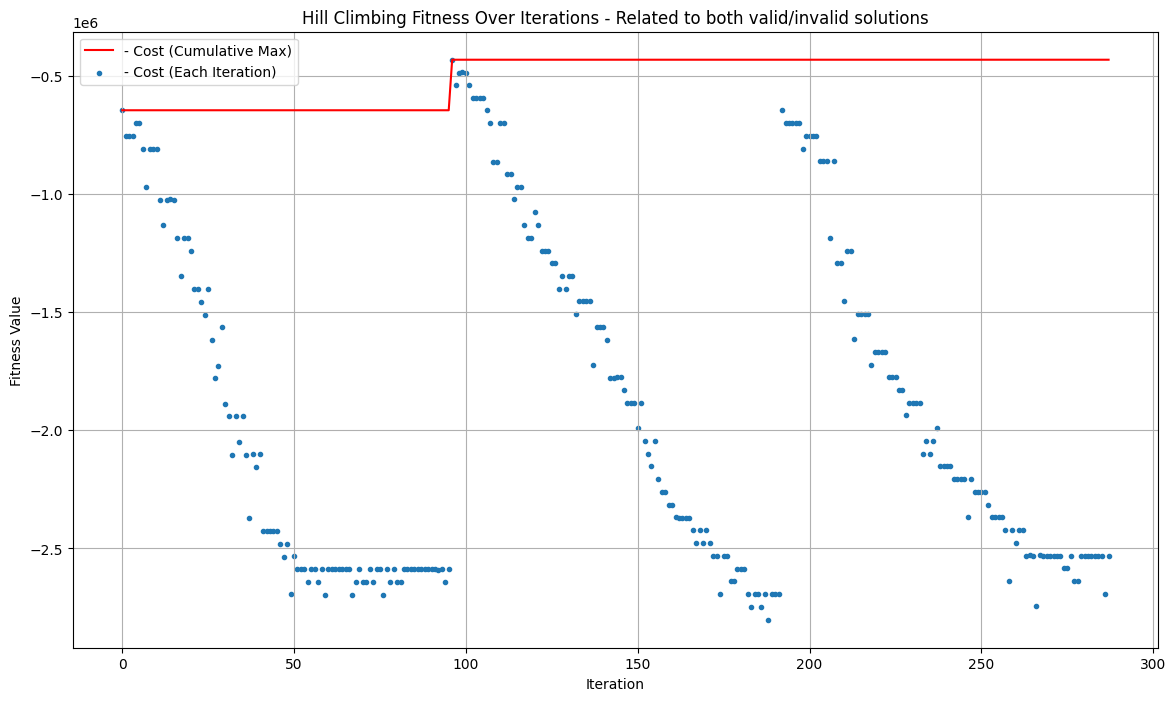

ic| UNIVERSE_SIZE: 100000
    NUM_SETS: 10000
    DENSITY: 0.3
    valid(s): np.True_
    cost(s): np.float64(2436145.2692907)
    num_steps: 29


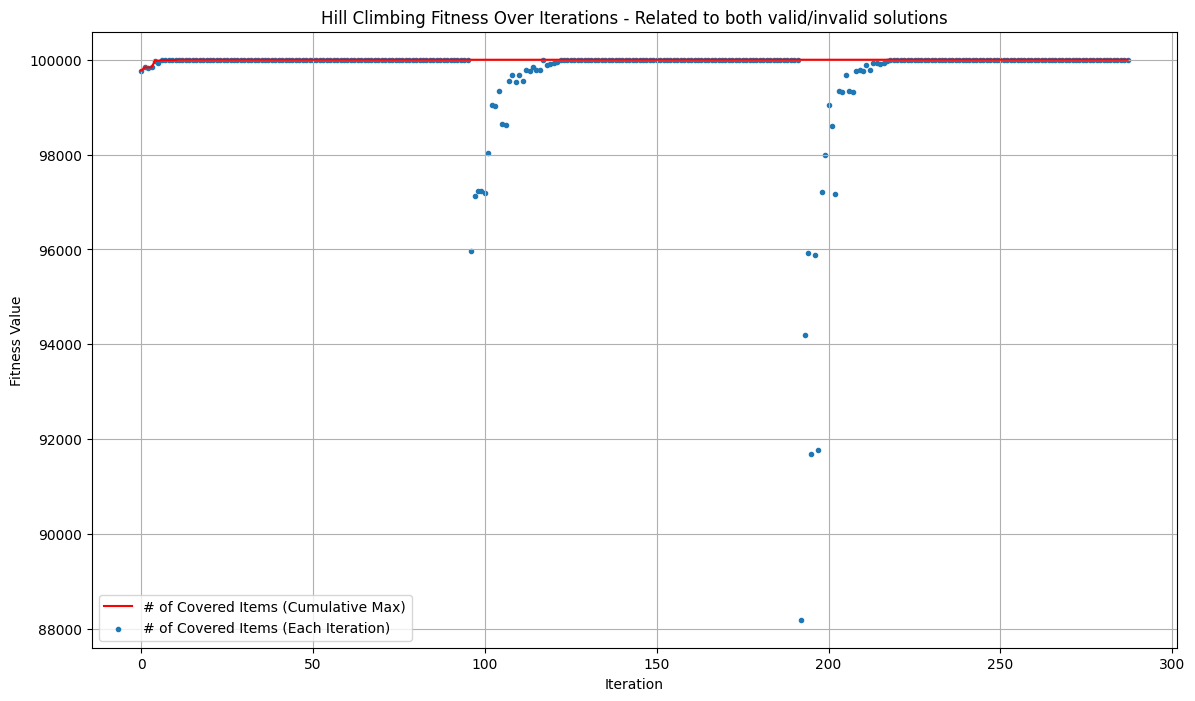

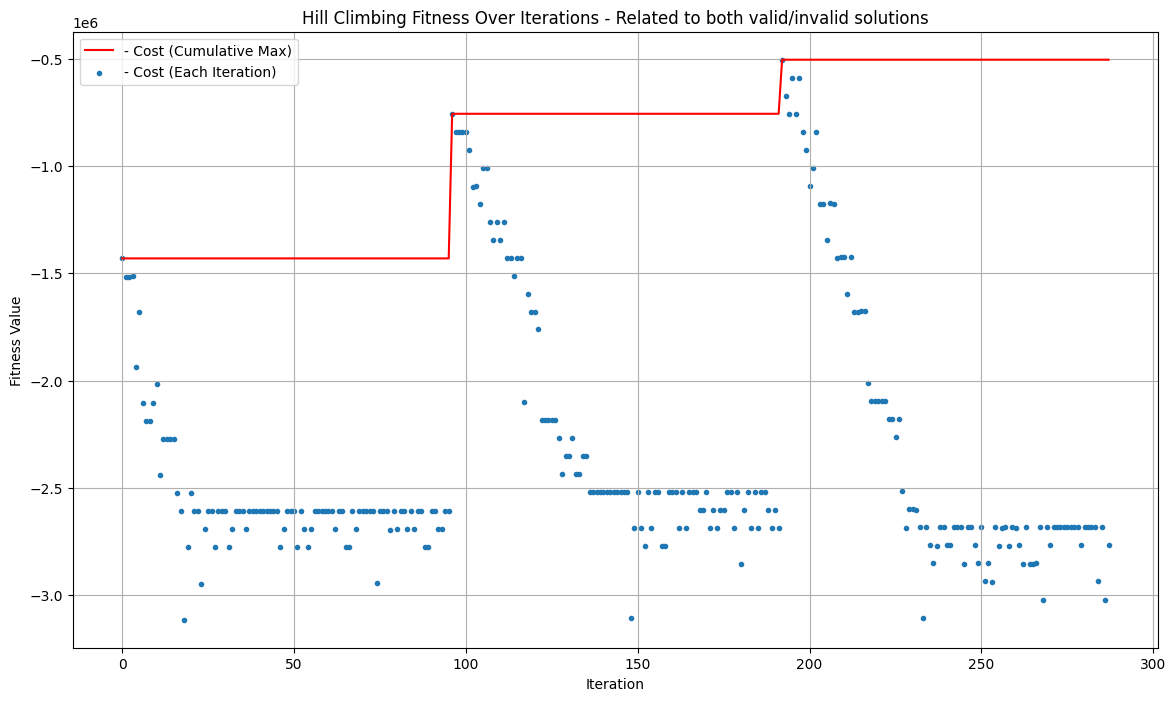

In [42]:
with open(file_path, 'a') as file:
    file.write("\t\t\tHILL CLIMBING - STEEPEST STEP AND RESTART - SECOND FITNESS AND STARTING POINT\n")
    for index in range(num_instances):
        initialize_set_cover_problem(universe_size_instances[index], num_sets_instances[index], density_instances[index])

        init_fitness = (0, float('-inf'))
        s, history, num_steps = hill_climbing_with_restarts(init_fitness, fitness=fitness_2, starting_point=starting_point_2)
        stats = f"Instance {index + 1}:\n" \
                f"UNIVERSE_SIZE = {UNIVERSE_SIZE}, NUM_SETS = {NUM_SETS}, DENSITY = {DENSITY}\n" \
                f"Valid Solution: {valid(s)}, Cost: {cost(s)}, # steps: {num_steps}\n\n"
        ic(UNIVERSE_SIZE, NUM_SETS, DENSITY, valid(s), cost(s), num_steps)
        file.write(stats)

        #first criterion: # of covered items, second criterion: -cost
        fitness_values = [first_fitness_criterion for first_fitness_criterion, second_fitness_criterion in history]
        fitness_plot(fitness_values, "# of Covered Items (Cumulative Max)", "# of Covered Items (Each Iteration)")

        #first criterion: validity, second criterion: -cost
        fitness_values = [second_fitness_criterion for first_fitness_criterion, second_fitness_criterion in history]
        fitness_plot(fitness_values, "- Cost (Cumulative Max)", "- Cost (Each Iteration)")
    file.write("\n\n")

## Simulated Annealing

In [46]:
INITIAL_TEMPERATURE = 600  # Initial temperature
COOLING_RATE = 0.995  # Cooling factor
threshold_stop = 1e-10  # Threshold for stopping the algorithm

def simulated_annealing(tweak, starting_point, fitness, penalty_weight=1e6):
    # Initial starting point
    S = starting_point()  # Initial solution
    best_solution = S.copy()  # Best solution found so far
    current_fitness = fitness(S)  # Fitness of the current solution

    # Apply penalty if solution is not valid
    current_penalty = penalty_weight * (not valid(S))  # Large penalty for invalid solutions
    current_fitness = (current_fitness[0] - current_penalty, current_fitness[1] - current_penalty)

    # Temperature initialization
    temperature = INITIAL_TEMPERATURE

    # History to track the evolution of fitness (value, cost)
    history = [current_fitness]

    step = 0  # Track the number of step
    best_step = 0  # Track the step at which the best solution was found

    # Main loop
    while temperature > threshold_stop:
        # Create a new solution by tweaking the current one
        R = tweak(S.copy())  # Tweak the current solution
        new_fitness = fitness(R)  # Fitness of the new solution

        # Apply penalty if solution is not valid
        new_penalty = penalty_weight * (not valid(R))  # Large penalty for invalid solutions
        new_fitness = (new_fitness[0] - new_penalty, new_fitness[1] - new_penalty)  # Adjust fitness with penalty'''

        # Calculate the change in energy from S to R
        euclidean_distance_fitness = np.sqrt((new_fitness[0] - current_fitness[0])**2 + (new_fitness[1] - current_fitness[1])**2)

        # If the new solution is better or accepted probabilistically
        if euclidean_distance_fitness > 0 or rng.random() < math.exp(euclidean_distance_fitness / temperature):
            S = R  # Update the current solution
            current_value, current_cost = new_fitness[0], new_fitness[1]  # Update value and cost
            history.append((current_value, current_cost))  # Store in history

            # Update best_solution if the new solution is better and valid
            if new_fitness > fitness(best_solution) and valid(R):  # Ensure solution is valid before updating best_solution
                best_solution = S.copy()  # Update the best solution
                best_step = step

            # Update current fitness to the new fitness
            current_fitness = new_fitness

        # Reduce the temperature according to the cooling schedule
        temperature *= COOLING_RATE

        step += 1  # Increment the number of steps

    return best_solution, history, best_step  # Return the best solution found and the fitness history


ic| UNIVERSE_SIZE: 100
    NUM_SETS: 10
    DENSITY: 0.2
    valid(s): np.True_
    cost(s): np.float64(279.13315245667366)
    num_steps: 23


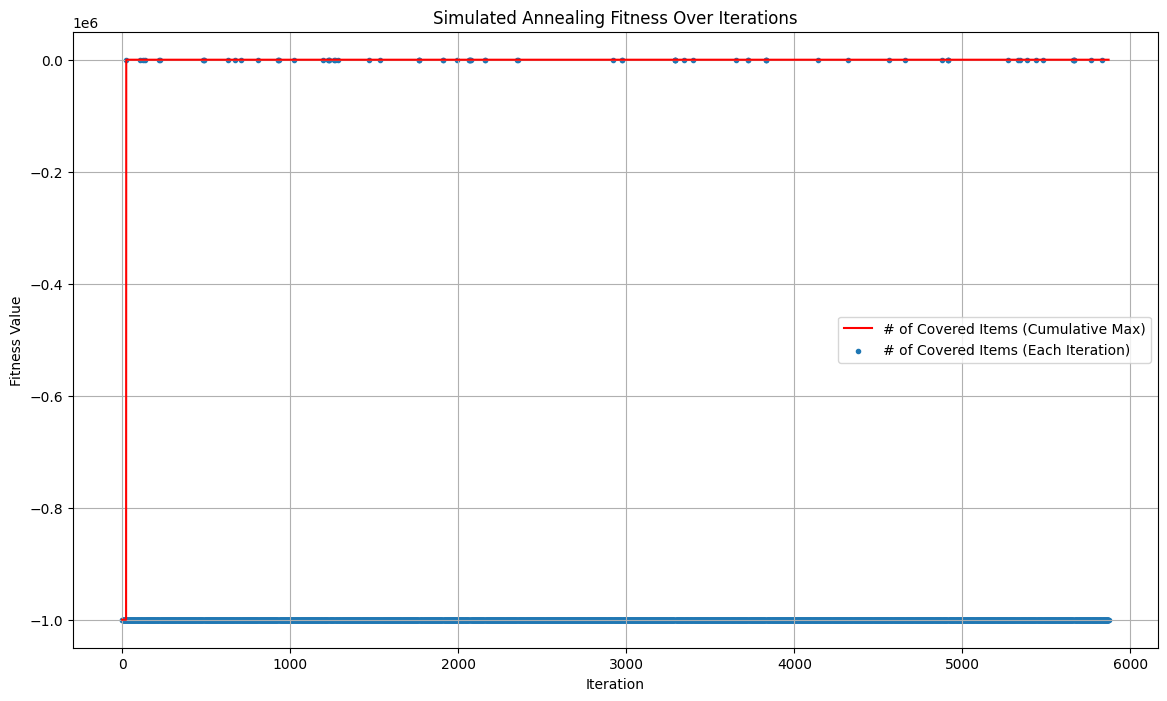

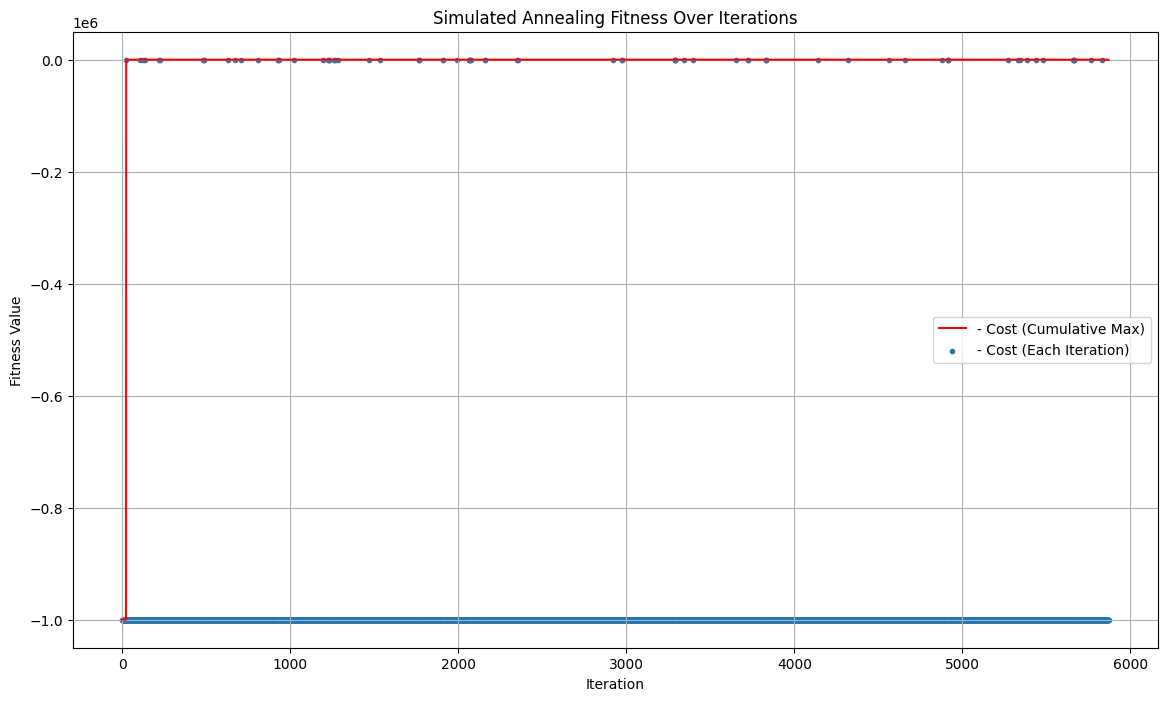

ic| UNIVERSE_SIZE: 1000
    NUM_SETS: 100
    DENSITY: 0.2
    valid(s): np.True_
    cost(s): np.float64(9490.630845200678)
    num_steps: 38


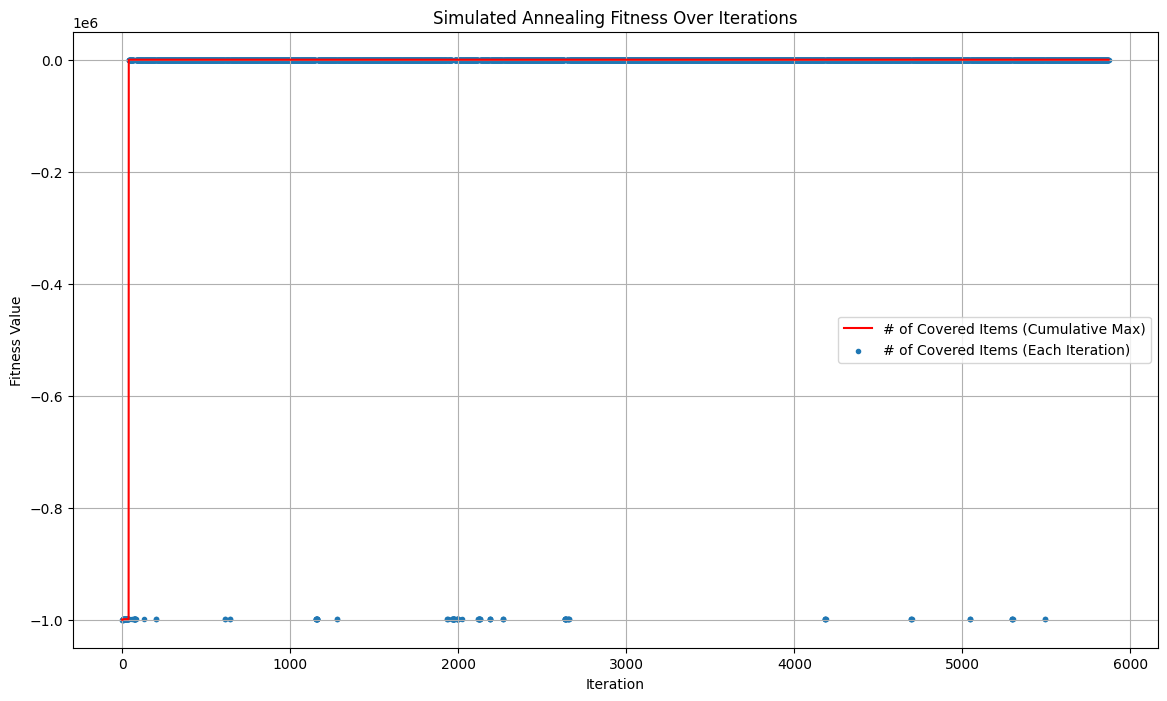

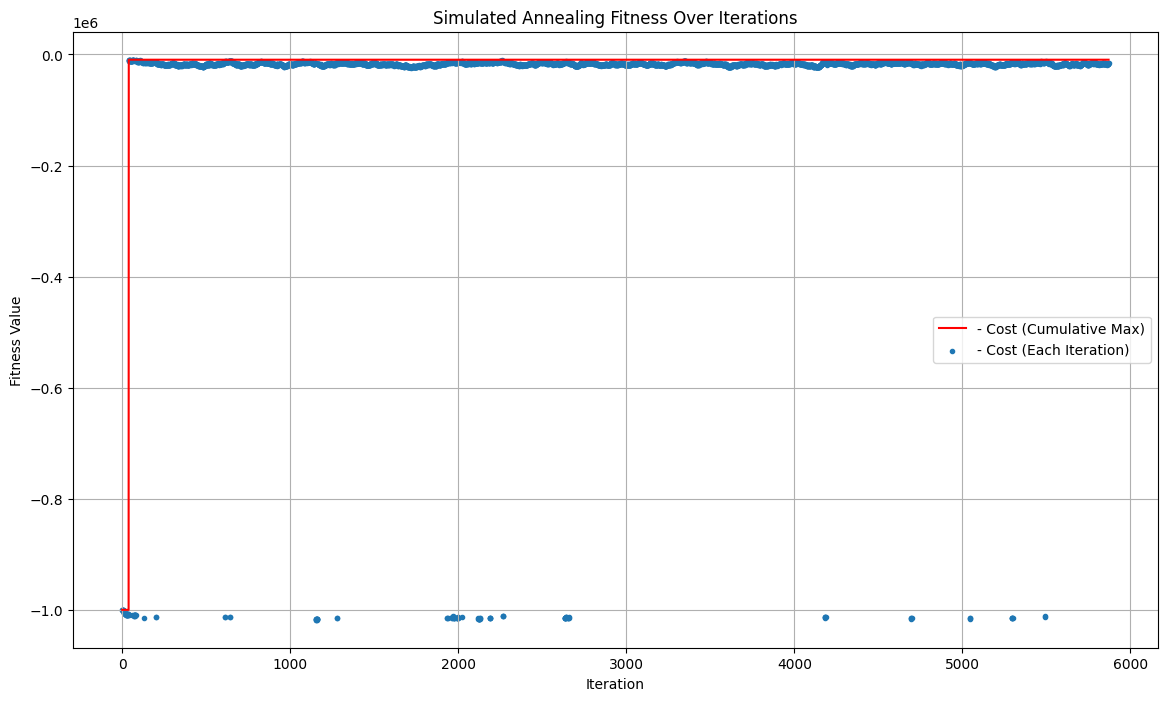

ic| UNIVERSE_SIZE: 10000
    NUM_SETS: 1000
    DENSITY: 0.2
    valid(s): np.True_
    cost(s): np.float64(213425.38997145818)
    num_steps: 68


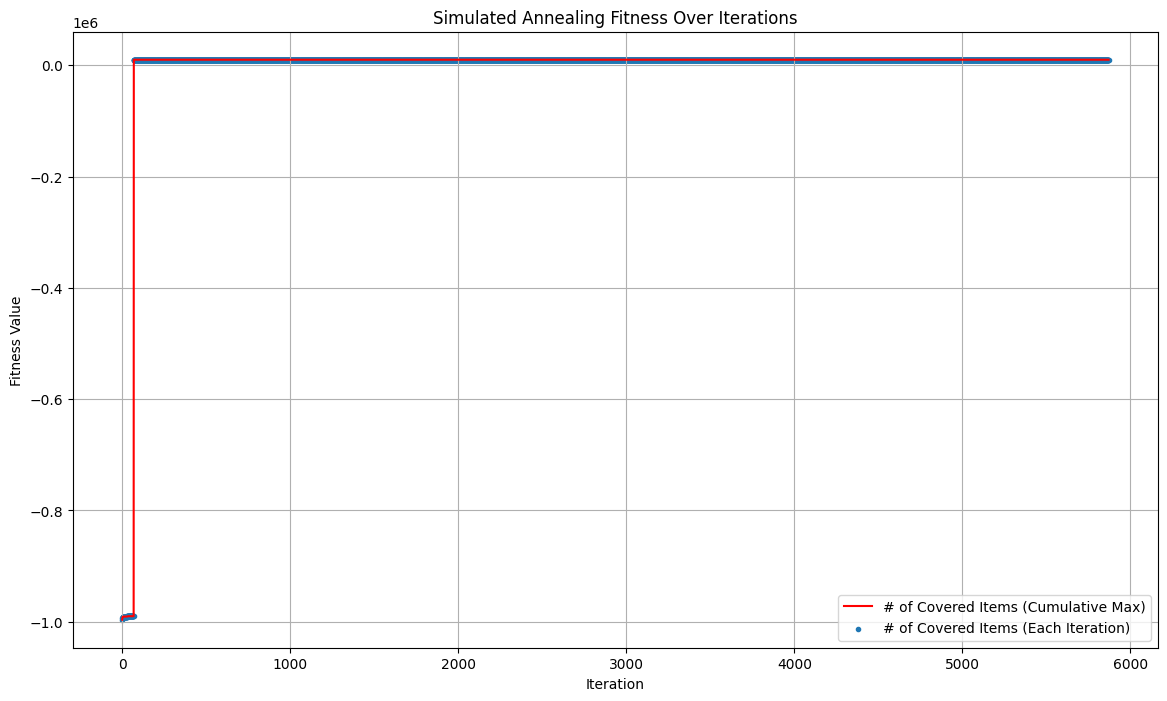

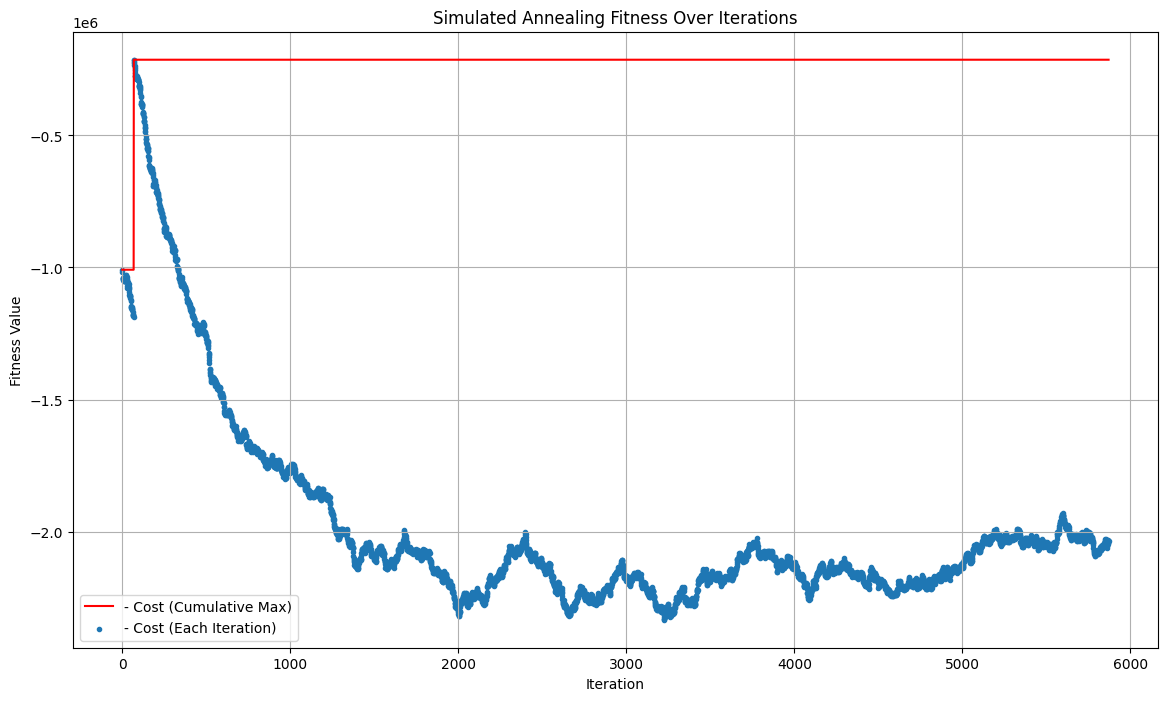

ic| UNIVERSE_SIZE: 100000
    NUM_SETS: 10000
    DENSITY: 0.1
    valid(s): np.True_
    cost(s): np.float64(2914794.627488354)
    num_steps: 122


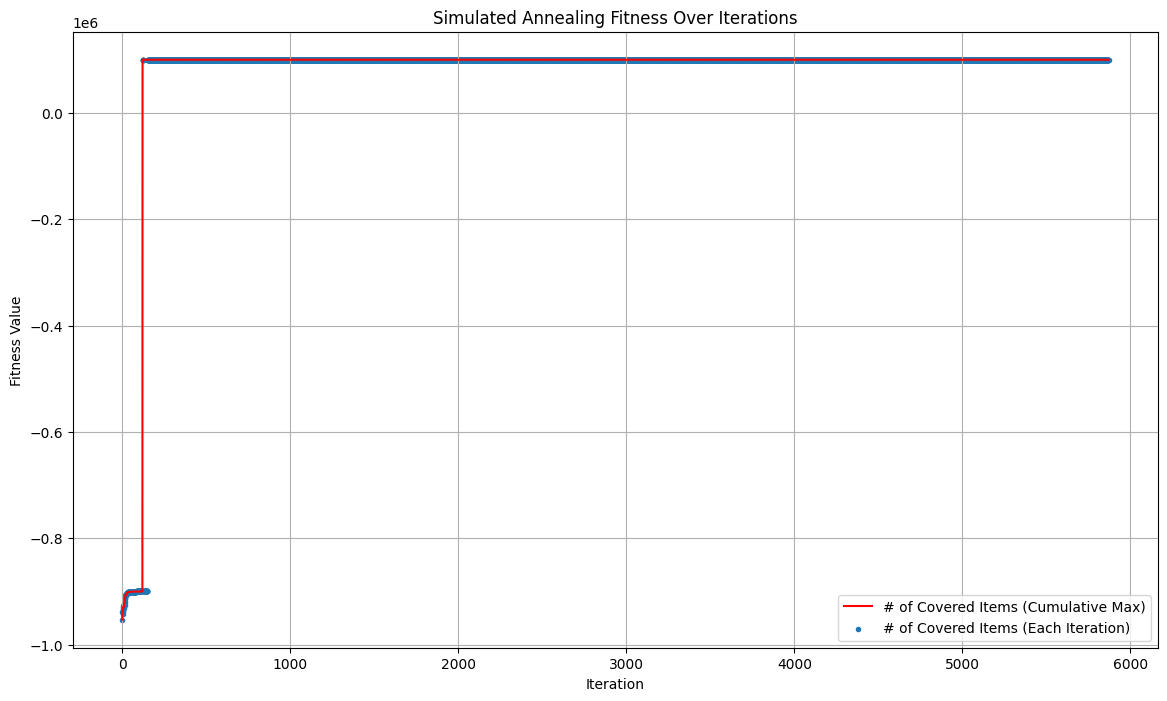

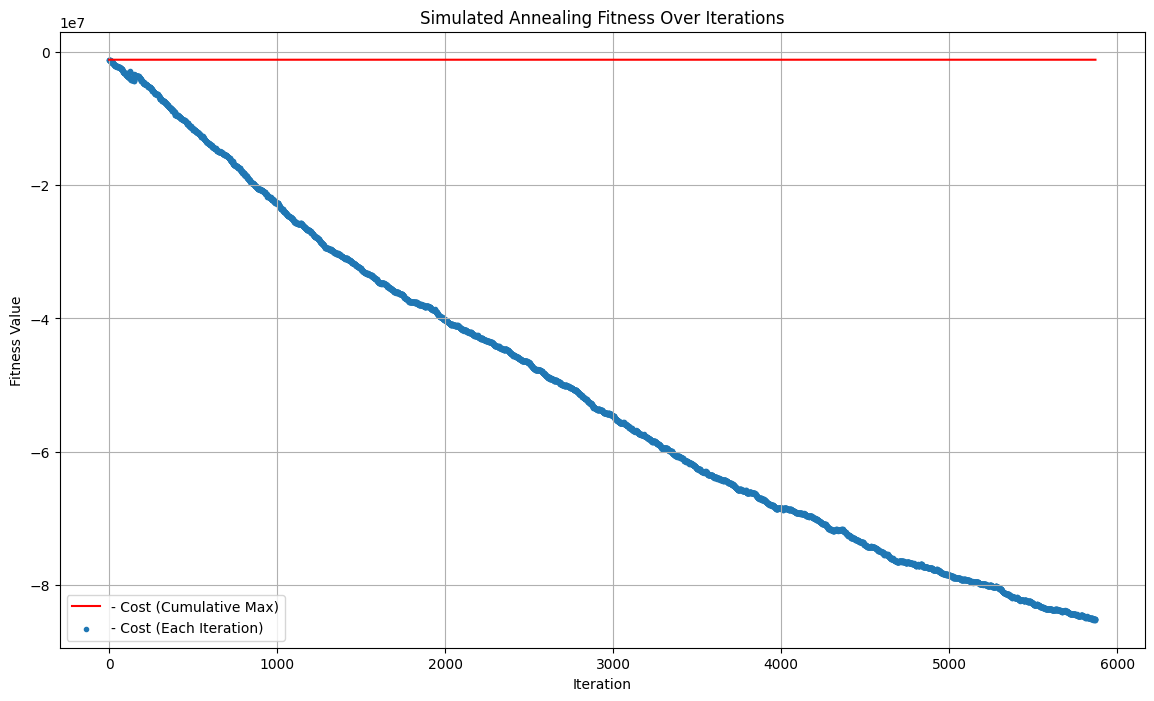

ic| UNIVERSE_SIZE: 100000
    NUM_SETS: 10000
    DENSITY: 0.2
    valid(s): np.True_
    cost(s): np.float64(2954034.7359691695)
    num_steps: 31


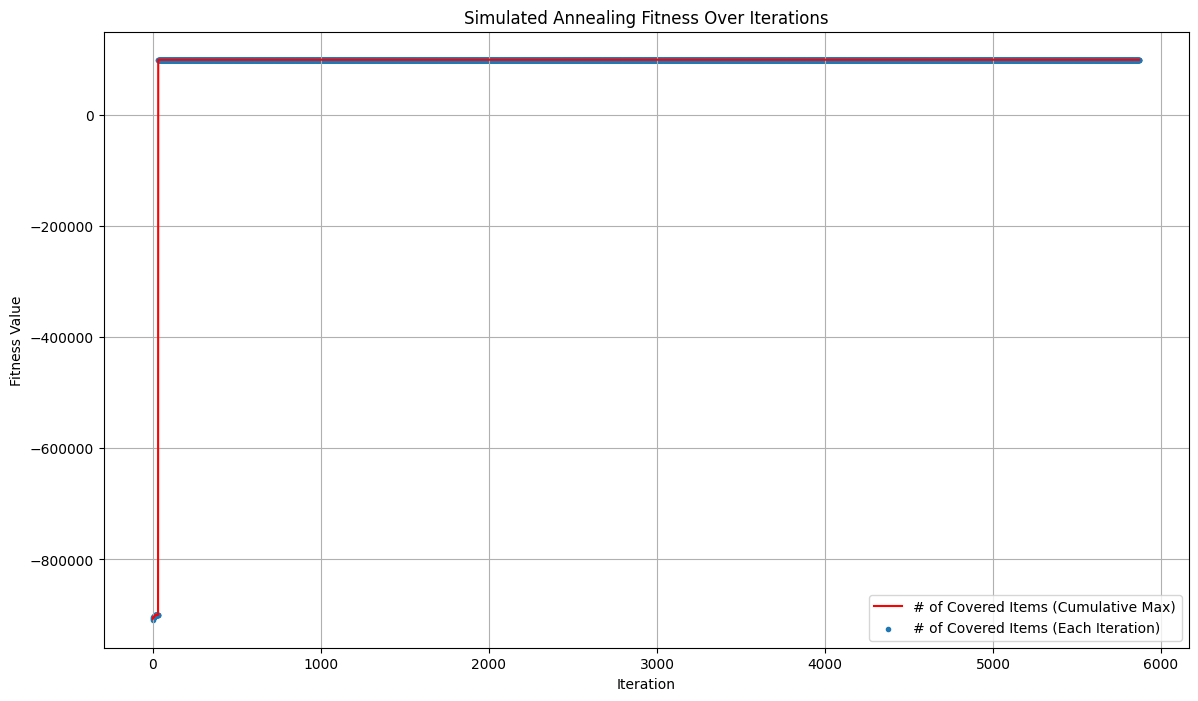

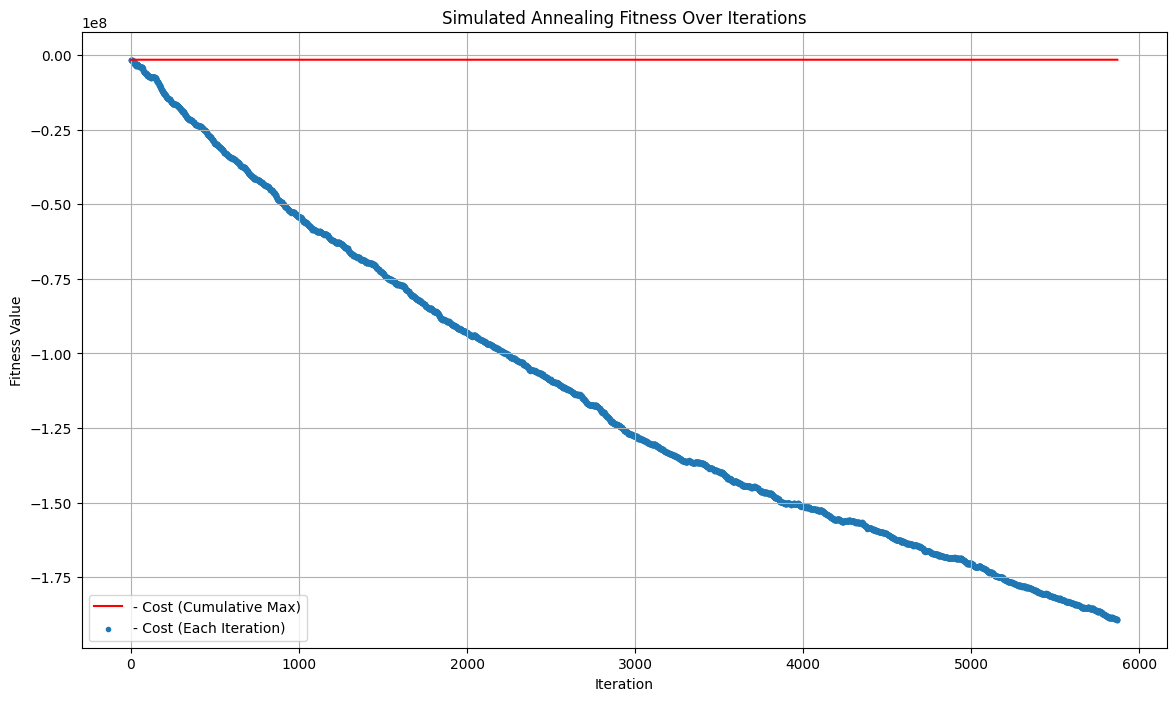

ic| UNIVERSE_SIZE: 100000
    NUM_SETS: 10000
    DENSITY: 0.3
    valid(s): np.True_
    cost(s): np.float64(3023534.522846177)
    num_steps: 11


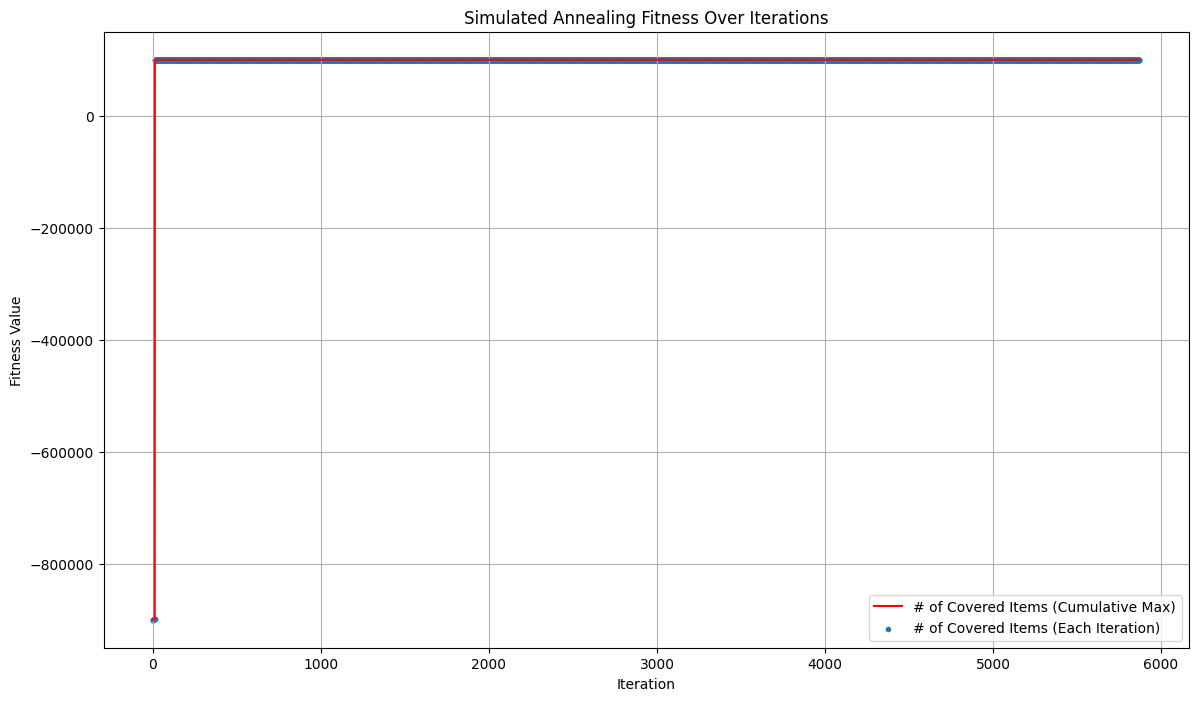

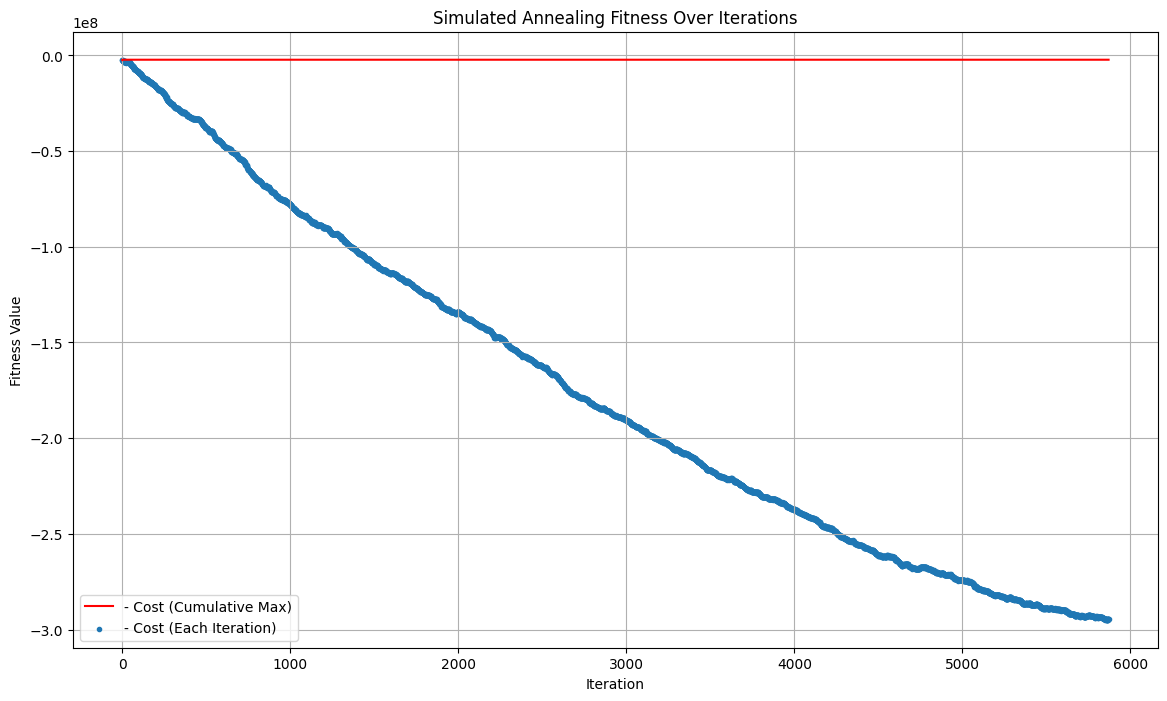

In [47]:
with open(file_path, 'a') as file:
    file.write("\t\t\tSIMULATED ANNEALING\n")
    for index in range(num_instances):
        initialize_set_cover_problem(universe_size_instances[index], num_sets_instances[index], density_instances[index])
            
        # Run the Simulated Annealing algorithm
        s, history, num_steps = simulated_annealing(tweak_3, starting_point_2, fitness_2)
        stats = f"Instance {index + 1}:\n" \
                f"UNIVERSE_SIZE = {UNIVERSE_SIZE}, NUM_SETS = {NUM_SETS}, DENSITY = {DENSITY}\n" \
                f"Valid Solution: {valid(s)}, Cost: {cost(s)}, # steps: {num_steps}\n\n"
        ic(UNIVERSE_SIZE, NUM_SETS, DENSITY, valid(s), cost(s), num_steps)
        file.write(stats)

        #first criterion: # of covered items, second criterion: -cost
        fitness_values = [first_fitness_criterion for first_fitness_criterion, second_fitness_criterion in history]
        fitness_plot(fitness_values, "# of Covered Items (Cumulative Max)", "# of Covered Items (Each Iteration)", "Simulated Annealing Fitness Over Iterations")

        #first criterion: validity, second criterion: -cost
        fitness_values = [second_fitness_criterion for first_fitness_criterion, second_fitness_criterion in history]
        fitness_plot(fitness_values, "- Cost (Cumulative Max)", "- Cost (Each Iteration)", "Simulated Annealing Fitness Over Iterations")
    file.write("\n\n")

### Tabu Search

In [43]:
def tabu_search(tweak, starting_point, fitness, tabu_size=50, max_iterations=1000, penalty_weight=1e6):
    # Initial starting point
    S = starting_point()  # Initial solution
    best_solution = S.copy()  # Best solution found so far
    current_fitness = fitness(S)  # Fitness of the current solution

    # Apply penalty if solution is not valid
    current_penalty = penalty_weight * (not valid(S))  # Large penalty for invalid solutions
    current_fitness = (current_fitness[0] - current_penalty, current_fitness[1] - current_penalty) #Adjust fitness with penalty

    # History to track the evolution of fitness (value, cost)
    history = [current_fitness]

    # Tabu list to store recent solutions or solution hashes (for quick comparison)
    tabu_list = []

    # Track the best fitness overall and the corresponding iteration index
    best_step = 0  # Track the iteration index of the best fitness

    # Main loop with a set number of iterations
    for step in range(max_iterations):
        # Generate neighborhood solutions by tweaking the current one
        neighborhood = [tweak(S.copy()) for _ in range(10)]  # Generate multiple neighbors

        # Evaluate the fitness of all neighbors
        neighborhood_fitness = []
        for neighbor in neighborhood:
            fitness_value = fitness(neighbor)

            # Apply penalty if the solution is not valid
            penalty = penalty_weight * (not valid(neighbor))  # Large penalty for invalid solutions
            fitness_value = (fitness_value[0] - penalty, fitness_value[1] - penalty)  # Adjust fitness with penalty
            neighborhood_fitness.append(fitness_value)

        # Select the best non-tabu neighbor
        best_neighbor, best_neighbor_fitness = None, (-float('inf'), -float('inf'))
        for neighbor, (value, cost) in zip(neighborhood, neighborhood_fitness):
            # Use a tuple of the neighbor solution to compare with the tabu list
            if not (neighbor.tobytes() in tabu_list):
                if fitness_value > best_neighbor_fitness:  # Check if the current neighbor is better
                    best_neighbor, best_neighbor_fitness = neighbor, (value, cost)

        # Update current solution to the best found neighbor
        if best_neighbor is not None:
            S = best_neighbor  # Move to the best neighbor
            history.append(best_neighbor_fitness)  # Track progress

            # If new solution is better than best solution found so far
            if best_neighbor_fitness > fitness(best_solution) and valid(S):
                best_solution = S.copy()  # Update best solution
                best_step = step # Update the iteration index of the best fitness

            # Add the move or solution to the tabu list
            tabu_list.append(S.tobytes())  # Add as bytes for quick comparison
            if len(tabu_list) > tabu_size:
                tabu_list.pop(0)  # Keep the tabu list at a fixed size

    return best_solution, history, best_step  # Return the best solution found and the fitness history


ic| UNIVERSE_SIZE: 100
    NUM_SETS: 10
    DENSITY: 0.2
    valid(s): np.True_
    cost(s): np.float64(285.1278946987915)
    num_steps: 5


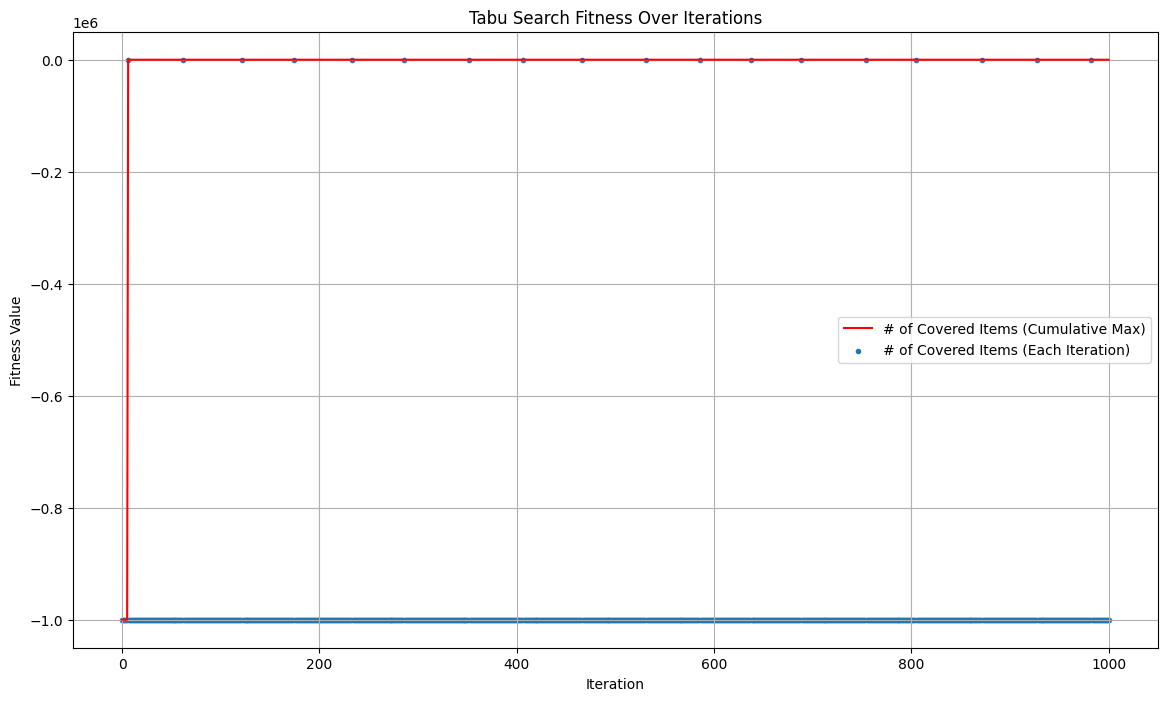

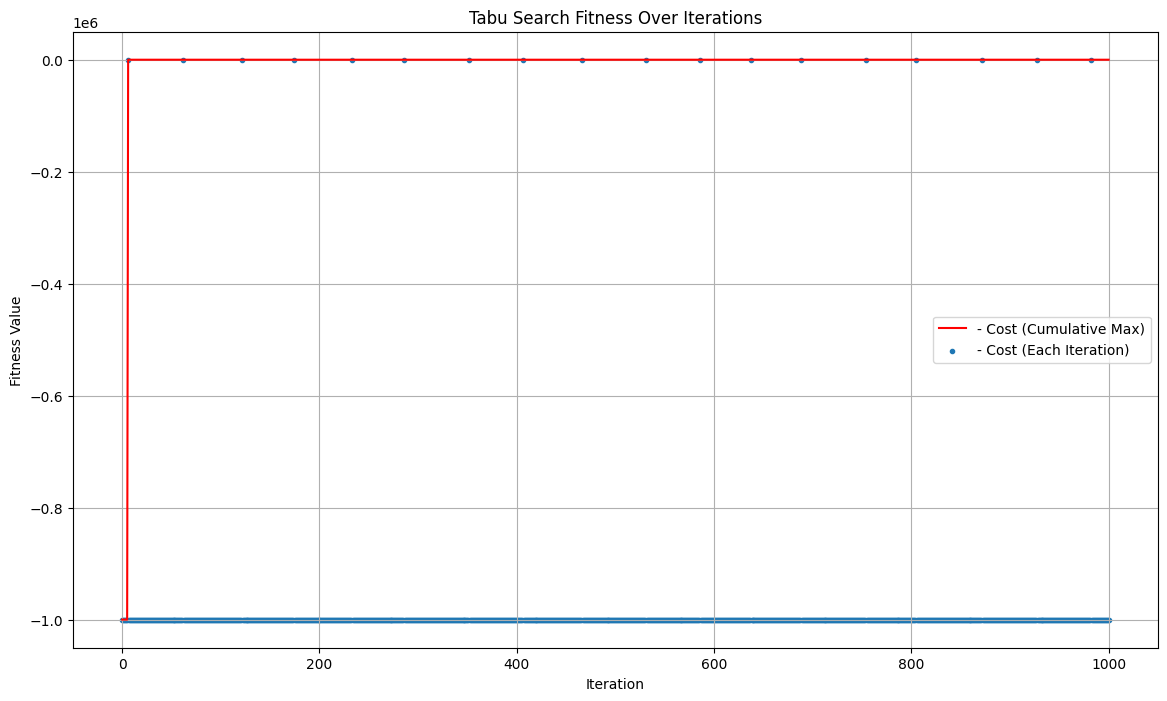

ic| UNIVERSE_SIZE: 1000
    NUM_SETS: 100
    DENSITY: 0.2
    valid(s): np.True_
    cost(s): np.float64(7378.513630981589)
    num_steps: 460


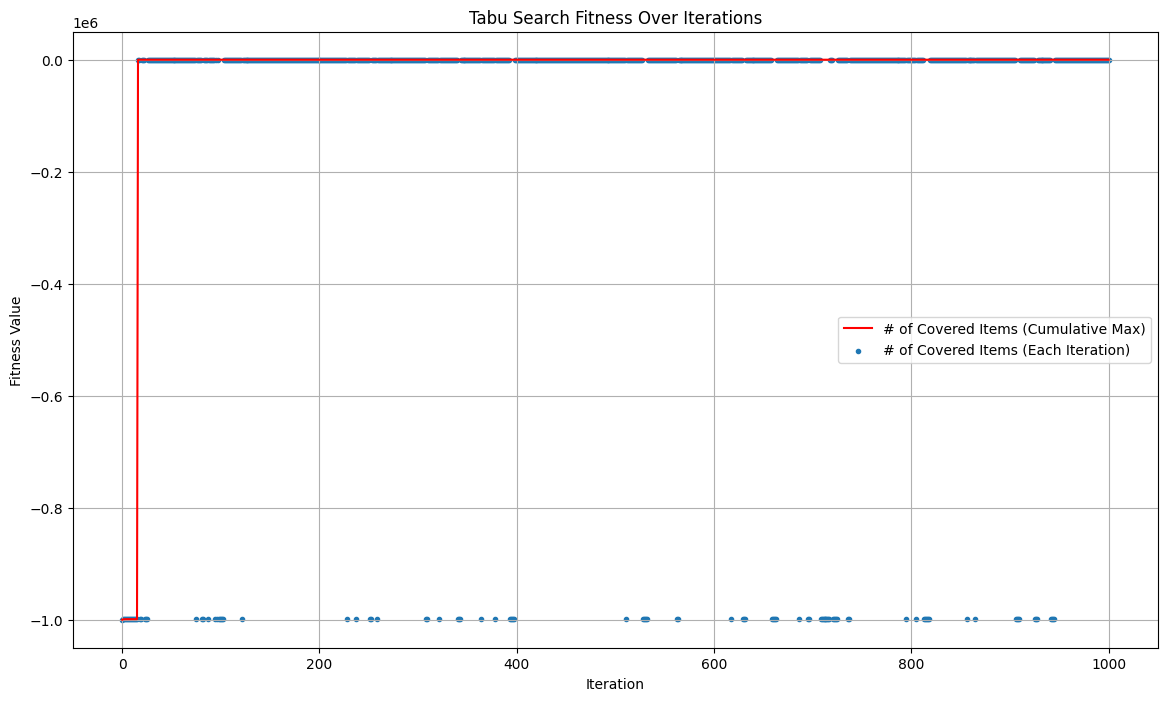

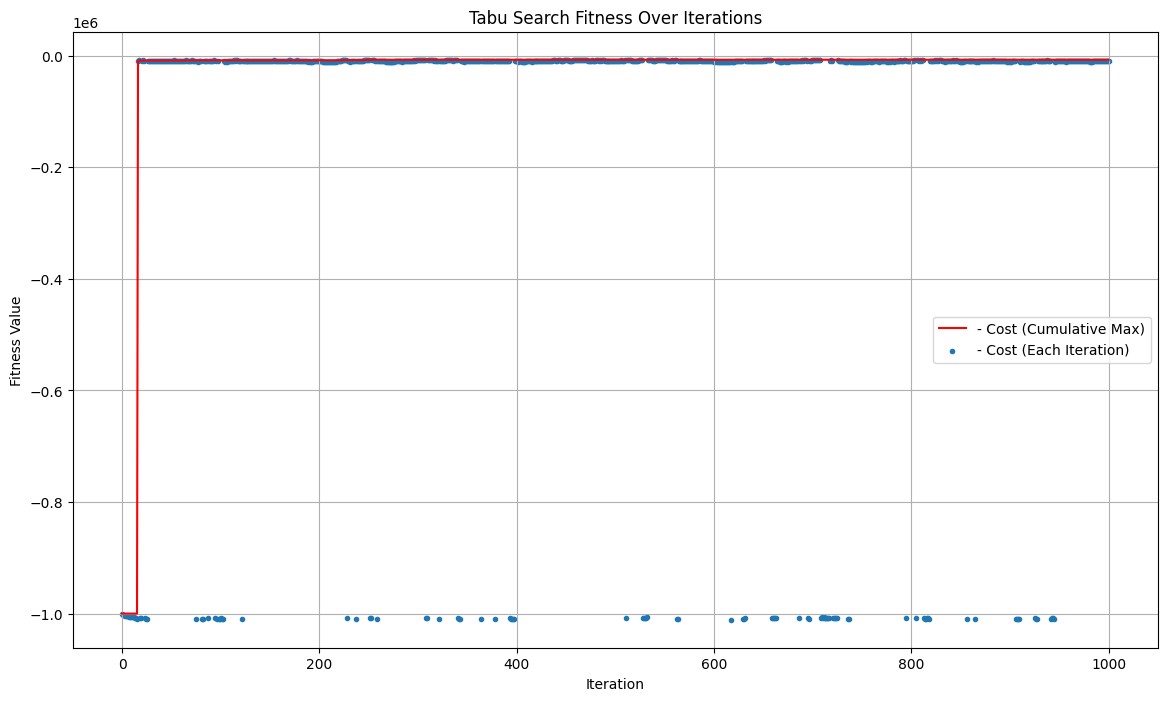

ic| UNIVERSE_SIZE: 10000
    NUM_SETS: 1000
    DENSITY: 0.2
    valid(s): np.True_
    cost(s): np.float64(140215.98489006184)
    num_steps: 177


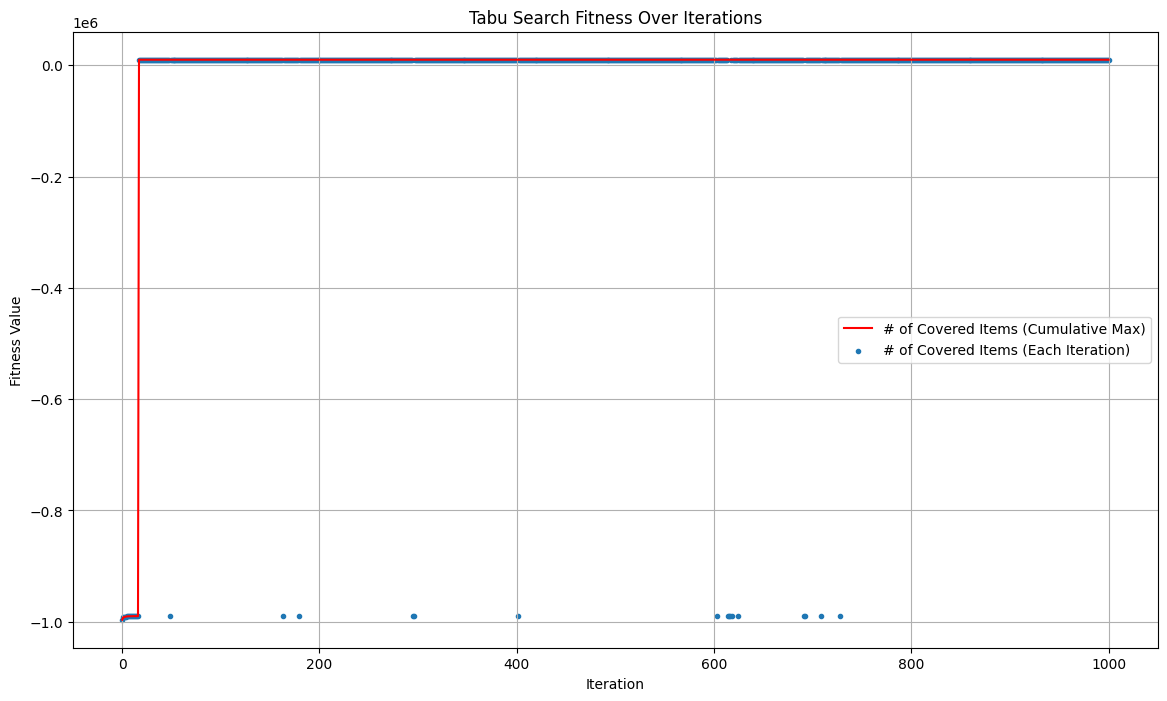

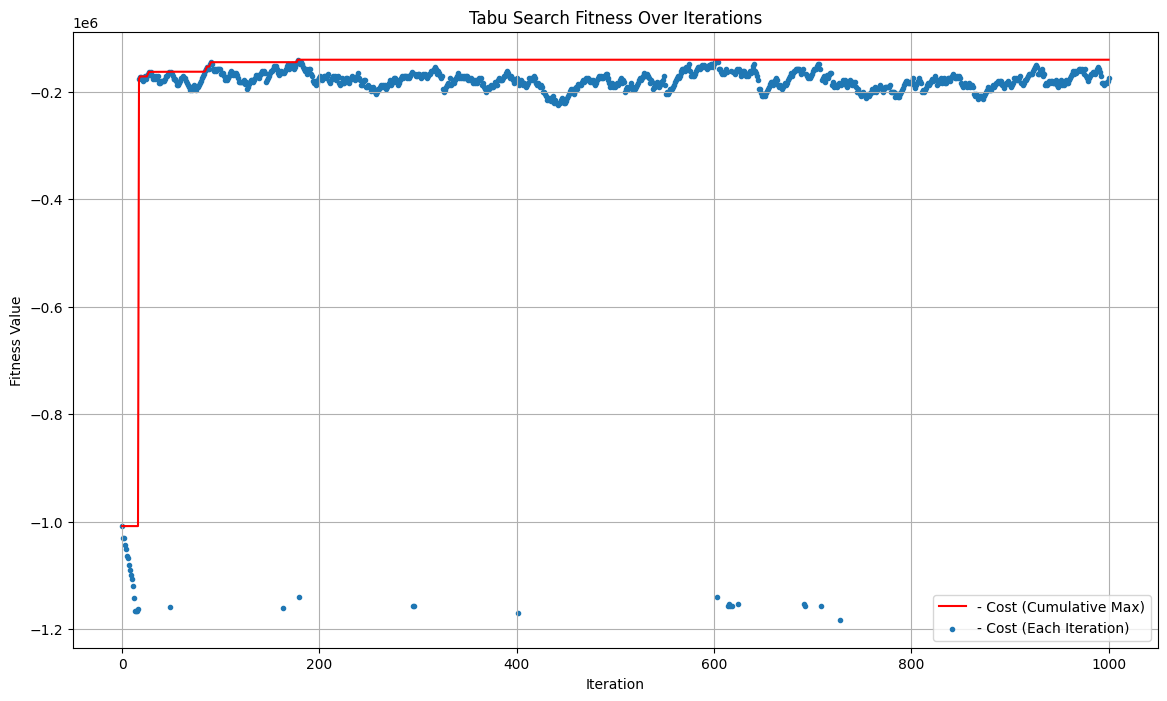

ic| UNIVERSE_SIZE: 100000
    NUM_SETS: 10000
    DENSITY: 0.1
    valid(s): np.True_
    cost(s): np.float64(2254302.815837825)
    num_steps: 435


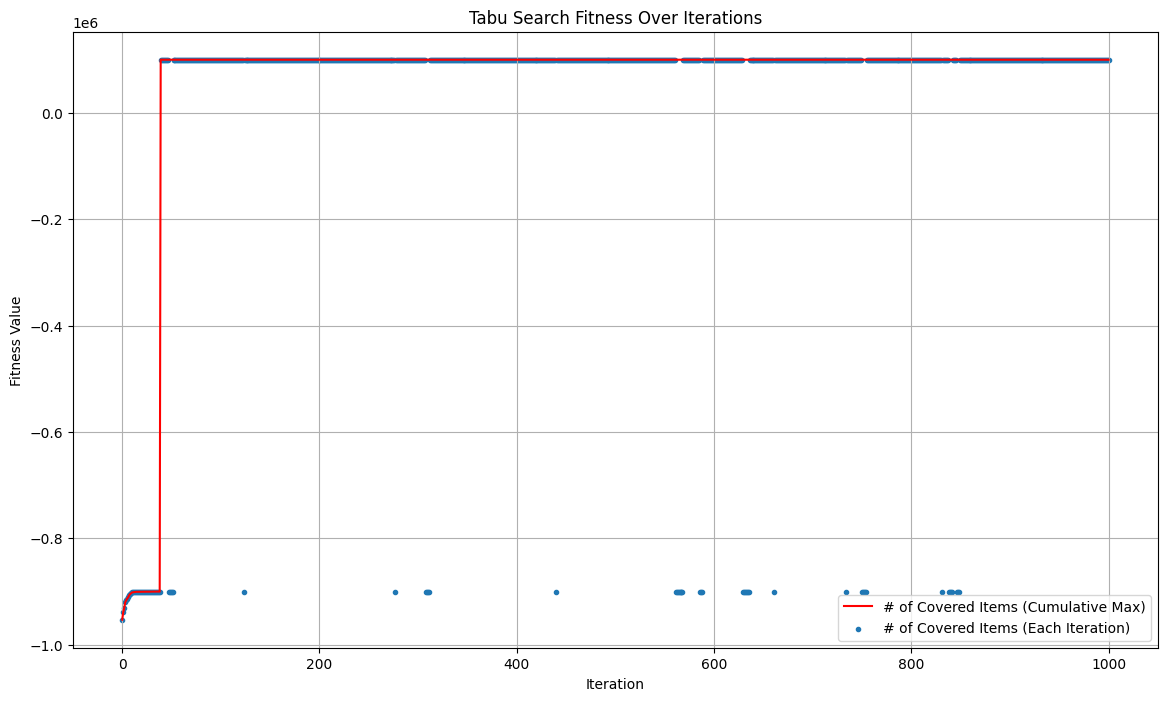

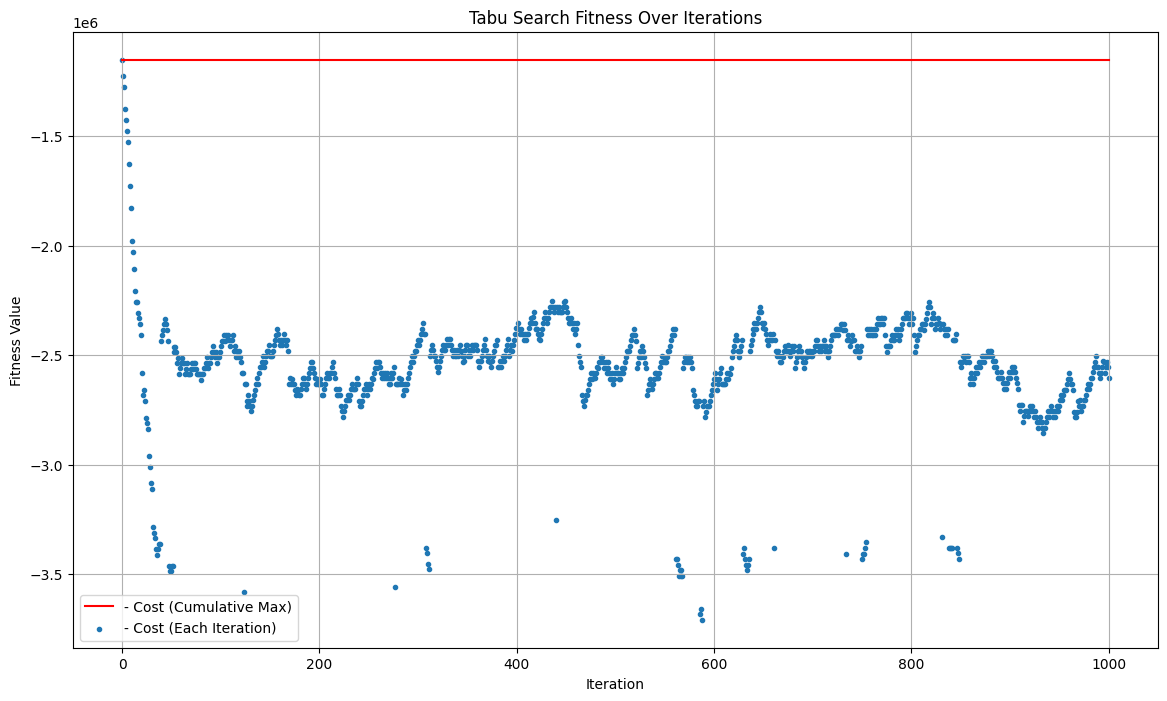

ic| UNIVERSE_SIZE: 100000
    NUM_SETS: 10000
    DENSITY: 0.2
    valid(s): np.True_
    cost(s): np.float64(2365045.710710987)
    num_steps: 994


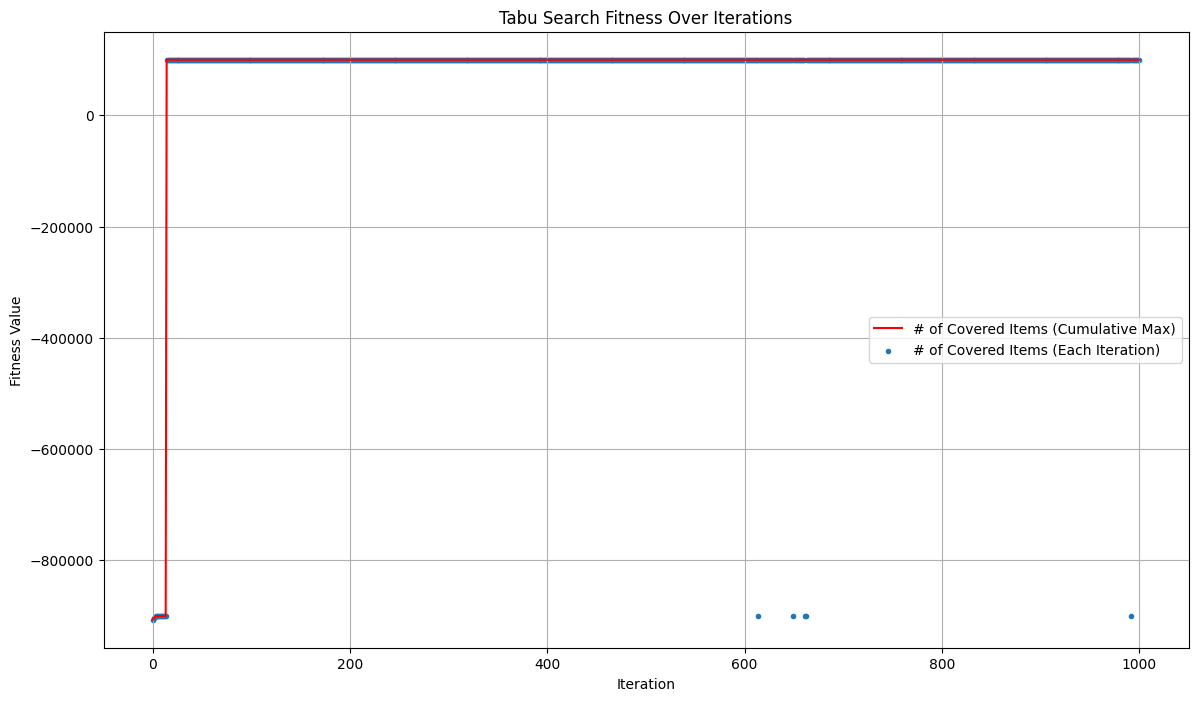

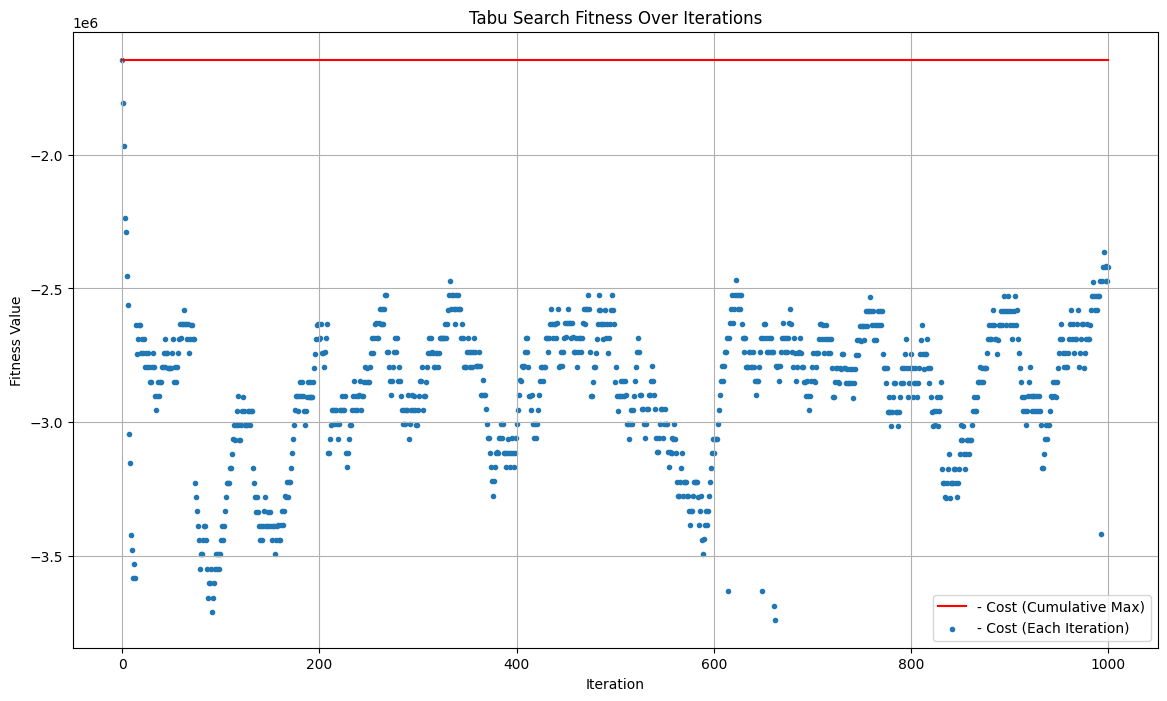

ic| UNIVERSE_SIZE: 100000
    NUM_SETS: 10000
    DENSITY: 0.3
    valid(s): np.True_
    cost(s): np.float64(2430511.2748646066)
    num_steps: 42


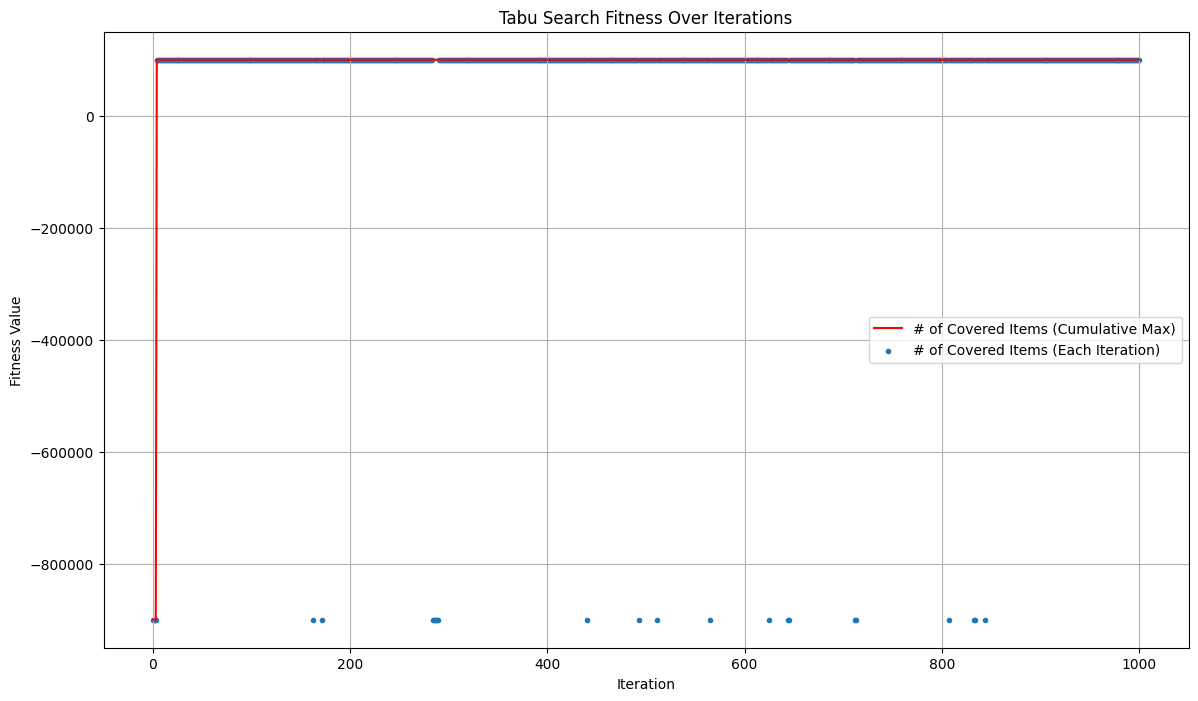

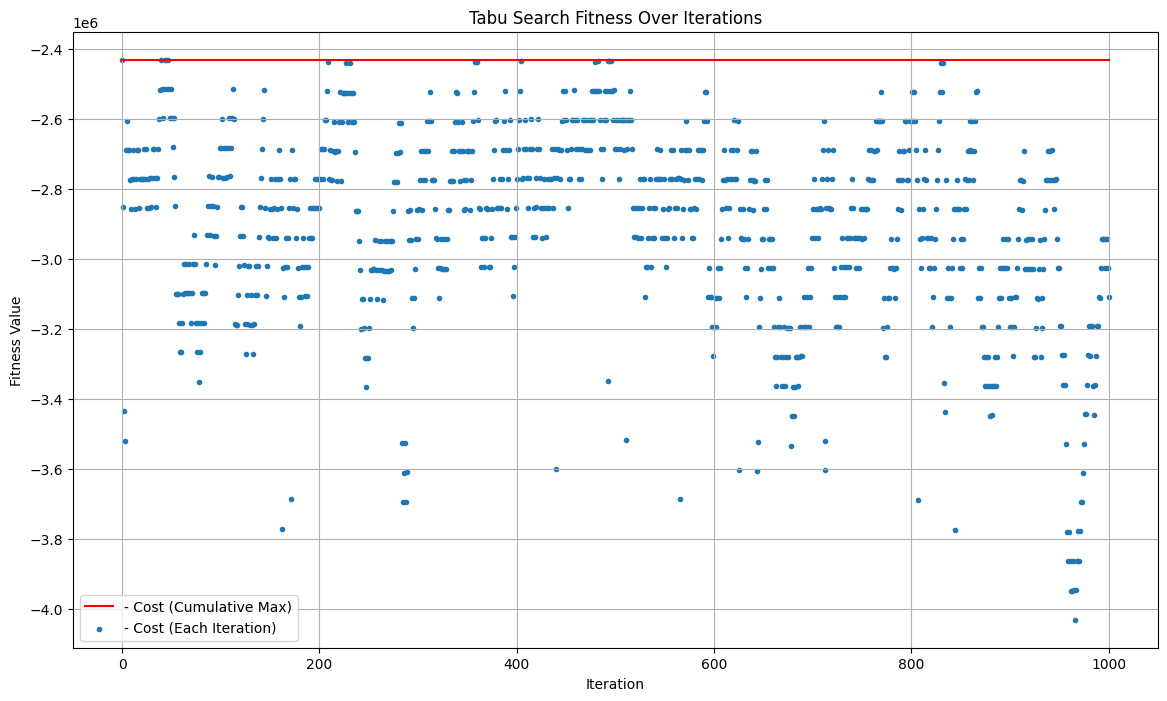

In [44]:
with open(file_path, 'a') as file:
    file.write("\t\t\tTABU SEARCH\n")    
    for index in range(num_instances):
        initialize_set_cover_problem(universe_size_instances[index], num_sets_instances[index], density_instances[index])

        # Run the Tabu Search algorithm
        s, history, num_steps = tabu_search(tweak_3, starting_point_2, fitness_2)
        stats = f"Instance {index + 1}:\n" \
                f"UNIVERSE_SIZE = {UNIVERSE_SIZE}, NUM_SETS = {NUM_SETS}, DENSITY = {DENSITY}\n" \
                f"Valid Solution: {valid(s)}, Cost: {cost(s)}, # steps: {num_steps}\n\n"
        ic(UNIVERSE_SIZE, NUM_SETS, DENSITY, valid(s), cost(s), num_steps)
        file.write(stats)

        #first criterion: # of covered items, second criterion: -cost
        fitness_values = [first_fitness_criterion for first_fitness_criterion, second_fitness_criterion in history]
        fitness_plot(fitness_values, "# of Covered Items (Cumulative Max)", "# of Covered Items (Each Iteration)", "Tabu Search Fitness Over Iterations")

        #first criterion: validity, second criterion: -cost
        fitness_values = [second_fitness_criterion for first_fitness_criterion, second_fitness_criterion in history]
        fitness_plot(fitness_values, "- Cost (Cumulative Max)", "- Cost (Each Iteration)", "Tabu Search Fitness Over Iterations")
    file.write("\n\n")